In [1]:
import nbimporter
import numpy as np
from functools import lru_cache
from scipy import optimize
import datetime

import s03_01_hc_load_general as ld
from s03_02_08_envelope_performance_detail import get_r_env

from s11_01_external_condition import load_outdoor, \
    get_T_ex, \
    get_Theta_ex, \
    get_X_ex, \
    calc_h_ex, \
    load_climate, \
    get_J

from s03_01_hc_load_general import \
    get_A_NR

from s04_07_i_pipe import \
    get_A_A_R

from s11_03_life_schedule import load_schedule, get_schedule_ac



Importing Jupyter notebook from s03_01_hc_load_general.ipynb
Importing Jupyter notebook from s03_01_hc_load_general_file.ipynb
Importing Jupyter notebook from s03_01_d_ventilation_via_underfloor.ipynb
Importing Jupyter notebook from s03_01_e_underfloor_temperature.ipynb
Importing Jupyter notebook from s11_01_external_condition.ipynb
Importing Jupyter notebook from s03_02_08_envelope_performance_detail.ipynb
Importing Jupyter notebook from s04_07_i_pipe.ipynb
Importing Jupyter notebook from s11_03_life_schedule.ipynb


In [2]:
# 未処理負荷と機器の計算に必要な変数を取得
def calc_Q_UT_A(A_A, A_MR, A_OR, A_env, mu_H, mu_C, q_hs_rtd_H, q_hs_rtd_C, V_hs_dsgn_H, V_hs_dsgn_C, Q,
             VAV, general_ventilation, duct_insulation, region, L_H_d_t_i, L_CS_d_t_i, L_CL_d_t_i):

    # 外気条件
    outdoor = load_outdoor()
    Theta_ex_d_t = get_Theta_ex(region, outdoor)
    X_ex_d_t = get_X_ex(region, outdoor)
    climate = load_climate(region)
    J_d_t = get_J(climate)
    h_ex_d_t = calc_h_ex(X_ex_d_t, Theta_ex_d_t)

    A_HCZ_i = np.array([ld.get_A_HCZ_i(i, A_A, A_MR, A_OR) for i in range(1, 6)])
    A_HCZ_R_i = [ld.get_A_HCZ_R_i(i) for i in range(1, 6)]

    A_NR = get_A_NR(A_A, A_MR, A_OR)

    # (67)
    L_wtr = get_L_wtr()

    # (66d)
    n_p_NR_d_t = calc_n_p_NR_d_t(A_NR)

    # (66c)
    n_p_OR_d_t = calc_n_p_OR_d_t(A_OR)

    # (66b)
    n_p_MR_d_t = calc_n_p_MR_d_t(A_MR)

    # (66a)
    n_p_d_t = get_n_p_d_t(n_p_MR_d_t, n_p_OR_d_t, n_p_NR_d_t)

    # 人体発熱
    q_p_H = get_q_p_H()
    q_p_CS = get_q_p_CS()
    q_p_CL = get_q_p_CL()

    # (65d)
    w_gen_NR_d_t = calc_w_gen_NR_d_t(A_NR)

    # (65c)
    w_gen_OR_d_t = calc_w_gen_OR_d_t(A_OR)

    # (65b)
    w_gen_MR_d_t = calc_w_gen_MR_d_t(A_MR)

    # (65a)
    w_gen_d_t = get_w_gen_d_t(w_gen_MR_d_t, w_gen_OR_d_t, w_gen_NR_d_t)

    # (64d)
    q_gen_NR_d_t = calc_q_gen_NR_d_t(A_NR)

    # (64c)
    q_gen_OR_d_t = calc_q_gen_OR_d_t(A_OR)

    # (64b)
    q_gen_MR_d_t = calc_q_gen_MR_d_t(A_MR)

    # (64a)
    q_gen_d_t = get_q_gen_d_t(q_gen_MR_d_t, q_gen_OR_d_t, q_gen_NR_d_t)

    # (63)
    V_vent_l_NR_d_t = get_V_vent_l_NR_d_t()
    V_vent_l_OR_d_t = get_V_vent_l_OR_d_t()
    V_vent_l_MR_d_t = get_V_vent_l_MR_d_t()
    V_vent_l_d_t = get_V_vent_l_d_t(V_vent_l_MR_d_t, V_vent_l_OR_d_t, V_vent_l_NR_d_t)

    # (62)
    V_vent_g_i = get_V_vent_g_i(A_HCZ_i, A_HCZ_R_i)

    # (61)
    U_prt = get_U_prt()

    # (60)
    r_env = get_r_env(A_env, A_A)
    A_prt_i = get_A_prt_i(A_HCZ_i, r_env, A_MR, A_NR, A_OR)

    # (59)
    Theta_SAT_d_t = get_Theta_SAT_d_t(Theta_ex_d_t, J_d_t)

    # (58)
    l_duct_ex_i = get_l_duct_ex_i(A_A)

    # (57)
    l_duct_in_i = get_l_duct_in_i(A_A)

    # (56)
    l_duct_i = get_l_duct__i(l_duct_in_i, l_duct_ex_i)

    # (51)
    X_star_HBR_d_t = get_X_star_HBR_d_t(X_ex_d_t, region)

    # (50)
    Theta_star_HBR_d_t = get_Theta_star_HBR_d_t(Theta_ex_d_t, region)

    # (55)
    Theta_attic_d_t = get_Theta_attic_d_t(Theta_SAT_d_t, Theta_star_HBR_d_t)

    # (54)
    Theta_sur_d_t_i = get_Theta_sur_d_t_i(Theta_star_HBR_d_t, Theta_attic_d_t, l_duct_in_i, l_duct_ex_i, duct_insulation)

    # (40)
    Q_hat_hs_d_t = calc_Q_hat_hs_d_t(Q, A_A, V_vent_l_d_t, V_vent_g_i, mu_H, mu_C, J_d_t, q_gen_d_t, n_p_d_t, q_p_H,
                                     q_p_CS, q_p_CL, X_ex_d_t, w_gen_d_t, Theta_ex_d_t, L_wtr, region)

    # (39)
    V_hs_min = get_V_hs_min(V_vent_g_i)

    # (38)
    Q_hs_rtd_C = get_Q_hs_rtd_C(q_hs_rtd_C)

    # (37)
    Q_hs_rtd_H = get_Q_hs_rtd_H(q_hs_rtd_H)

    # (36)
    V_dash_hs_supply_d_t = get_V_dash_hs_supply_d_t(V_hs_min, V_hs_dsgn_H, V_hs_dsgn_C, Q_hs_rtd_H, Q_hs_rtd_C, Q_hat_hs_d_t, region)

    # (45)
    r_supply_des_i = get_r_supply_des_i(A_HCZ_i)

    # (44)
    V_dash_supply_d_t_i = get_V_dash_supply_d_t_i(r_supply_des_i, V_dash_hs_supply_d_t, V_vent_g_i)

    # (53)
    X_star_NR_d_t = get_X_star_NR_d_t(X_star_HBR_d_t, L_CL_d_t_i, L_wtr, V_vent_l_NR_d_t, V_dash_supply_d_t_i, region)

    # (52)
    Theta_star_NR_d_t = get_Theta_star_NR_d_t(Theta_star_HBR_d_t, Q, A_NR, V_vent_l_NR_d_t, V_dash_supply_d_t_i, U_prt,
                                              A_prt_i, L_H_d_t_i, L_CS_d_t_i, region)

    # (49)
    X_NR_d_t = get_X_NR_d_t(X_star_NR_d_t)

    # (47)
    X_HBR_d_t_i = get_X_HBR_d_t_i(X_star_HBR_d_t)

    # (11)
    Q_star_trs_prt_d_t_i = get_Q_star_trs_prt_d_t_i(U_prt, A_prt_i, Theta_star_HBR_d_t, Theta_star_NR_d_t)

    # (10)
    L_star_CL_d_t_i = get_L_star_CL_d_t_i(L_CS_d_t_i, L_CL_d_t_i, region)

    # (9)
    L_star_CS_d_t_i = get_L_star_CS_d_t_i(L_CS_d_t_i, Q_star_trs_prt_d_t_i, region)

    # (8)
    L_star_H_d_t_i = get_L_star_H_d_t_i(L_H_d_t_i, Q_star_trs_prt_d_t_i, region)

    # (33)
    L_star_CL_d_t = get_L_star_CL_d_t(L_star_CL_d_t_i)

    # (32)
    L_star_CS_d_t = get_L_star_CS_d_t(L_star_CS_d_t_i)

    # (31)
    L_star_CL_max_d_t = get_L_star_CL_max_d_t(L_star_CS_d_t)

    # (30)
    L_star_dash_CL_d_t = get_L_star_dash_CL_d_t(L_star_CL_max_d_t, L_star_CL_d_t)

    # (29)
    L_star_dash_C_d_t = get_L_star_dash_C_d_t(L_star_CS_d_t, L_star_dash_CL_d_t)

    # (28)
    SHF_dash_d_t = get_SHF_dash_d_t(L_star_CS_d_t, L_star_dash_C_d_t)

    # (27)
    Q_hs_max_C_d_t = get_Q_hs_max_C_d_t(q_hs_rtd_C)

    # (26)
    Q_hs_max_CL_d_t = get_Q_hs_max_CL_d_t(Q_hs_max_C_d_t, SHF_dash_d_t, L_star_dash_CL_d_t)

    # (25)
    Q_hs_max_CS_d_t = get_Q_hs_max_CS_d_t(Q_hs_max_C_d_t, SHF_dash_d_t)

    # (24)
    C_df_H_d_t = get_C_df_H_d_t(Theta_ex_d_t, h_ex_d_t)

    # (23)
    Q_hs_max_H_d_t = get_Q_hs_max_H_d_t(q_hs_rtd_H, C_df_H_d_t)

    # (20)
    X_star_hs_in_d_t = get_X_star_hs_in_d_t(X_star_NR_d_t)

    # (19)
    Theta_star_hs_in_d_t = get_Theta_star_hs_in_d_t(Theta_star_NR_d_t)

    # (18)
    X_hs_out_min_C_d_t = get_X_hs_out_min_C_d_t(X_star_hs_in_d_t, Q_hs_max_CL_d_t, V_dash_supply_d_t_i)

    # (22)
    X_req_d_t_i = get_X_req_d_t_i(X_star_HBR_d_t, L_star_CL_d_t_i, V_dash_supply_d_t_i, region)

    # (21)
    Theta_req_d_t_i = get_Theta_req_d_t_i(Theta_sur_d_t_i, Theta_star_HBR_d_t, V_dash_supply_d_t_i,
                        L_star_H_d_t_i, L_star_CS_d_t_i, l_duct_i, region)

    # (15)
    X_hs_out_d_t = get_X_hs_out_d_t(X_NR_d_t, X_req_d_t_i, V_dash_supply_d_t_i, X_hs_out_min_C_d_t, L_star_CL_d_t_i, region)

    # 式(14)(46)(48)の条件に合わせてTheta_NR_d_tを初期化
    Theta_NR_d_t = np.zeros(24 * 365)

    # (17)
    Theta_hs_out_min_C_d_t = get_Theta_hs_out_min_C_d_t(Theta_star_hs_in_d_t, Q_hs_max_CS_d_t, V_dash_supply_d_t_i)

    # (16)
    Theta_hs_out_max_H_d_t = get_Theta_hs_out_max_H_d_t(Theta_star_hs_in_d_t, Q_hs_max_H_d_t, V_dash_supply_d_t_i)

    # L_star_H_d_t_i，L_star_CS_d_t_iの暖冷房区画1～5を合算し0以上だった場合の順序で計算
    # (14)
    Theta_hs_out_d_t = get_Theta_hs_out_d_t(VAV, Theta_req_d_t_i, V_dash_supply_d_t_i,
                                            L_star_H_d_t_i, L_star_CS_d_t_i, region, Theta_NR_d_t,
                                            Theta_hs_out_max_H_d_t, Theta_hs_out_min_C_d_t)

    # (43)
    V_supply_d_t_i = get_V_supply_d_t_i(L_star_H_d_t_i, L_star_CS_d_t_i, Theta_sur_d_t_i, l_duct_i, Theta_star_HBR_d_t,
                                                    V_vent_g_i, V_dash_supply_d_t_i, VAV, region, Theta_hs_out_d_t)

    # (41)
    Theta_supply_d_t_i = get_Thata_supply_d_t_i(Theta_sur_d_t_i, Theta_hs_out_d_t, Theta_star_HBR_d_t, l_duct_i,
                                                   V_supply_d_t_i, L_star_H_d_t_i, L_star_CS_d_t_i, region)

    # (46)
    Theta_HBR_d_t_i = get_Theta_HBR_d_t_i(Theta_star_HBR_d_t, V_supply_d_t_i, Theta_supply_d_t_i, U_prt, A_prt_i, Q,
                                             A_HCZ_i, L_star_H_d_t_i, L_star_CS_d_t_i, region)

    # (48)
    Theta_NR_d_t = get_Theta_NR_d_t(Theta_star_NR_d_t, Theta_star_HBR_d_t, Theta_HBR_d_t_i, A_NR, V_vent_l_NR_d_t,
                                        V_dash_supply_d_t_i, V_supply_d_t_i, U_prt, A_prt_i, Q)

     # L_star_H_d_t_i，L_star_CS_d_t_iの暖冷房区画1～5を合算し0以下だった場合の為に再計算
     # (14)
    Theta_hs_out_d_t = get_Theta_hs_out_d_t(VAV, Theta_req_d_t_i, V_dash_supply_d_t_i,
                                            L_star_H_d_t_i, L_star_CS_d_t_i, region, Theta_NR_d_t,
                                            Theta_hs_out_max_H_d_t, Theta_hs_out_min_C_d_t)

    # (42)
    X_supply_d_t_i = get_X_supply_d_t_i(X_star_HBR_d_t, X_hs_out_d_t, L_star_CL_d_t_i, region)

    # (35)
    V_hs_vent_d_t = get_V_hs_vent_d_t(V_vent_g_i, general_ventilation)

    # (34)
    V_hs_supply_d_t = get_V_hs_supply_d_t(V_supply_d_t_i)

    # (13)
    X_hs_in_d_t = get_X_hs_in_d_t(X_NR_d_t)

    # (12)
    Theta_hs_in_d_t = get_Theta_hs_in_d_t(Theta_NR_d_t)

    # (7)
    L_dash_CL_d_t_i = get_L_dash_CL_d_t_i(V_supply_d_t_i, X_HBR_d_t_i, X_supply_d_t_i, region)

    # (6)
    L_dash_CS_d_t_i = get_L_dash_CS_d_t_i(V_supply_d_t_i, Theta_supply_d_t_i, Theta_HBR_d_t_i, region)

    # (5)
    L_dash_H_d_t_i = get_L_dash_H_d_t_i(V_supply_d_t_i, Theta_supply_d_t_i, Theta_HBR_d_t_i, region)

    # (4)
    Q_UT_CL_d_t_i = get_Q_UT_CL_d_t_i(L_star_CL_d_t_i, L_dash_CL_d_t_i)

    # (3)
    Q_UT_CS_d_t_i = get_Q_UT_CS_d_t_i(L_star_CS_d_t_i, L_dash_CS_d_t_i)

    # (2)
    Q_UT_H_d_t_i = get_Q_UT_H_d_t_i(L_star_H_d_t_i, L_dash_H_d_t_i)

    # (1)
    E_C_UT_d_t = get_E_C_UT_d_t(Q_UT_CL_d_t_i, Q_UT_CS_d_t_i, region)

    return E_C_UT_d_t, Q_UT_H_d_t_i, Q_UT_CS_d_t_i, Q_UT_CL_d_t_i, Theta_hs_out_d_t, Theta_hs_in_d_t, \
           X_hs_out_d_t, X_hs_in_d_t, V_hs_supply_d_t, V_hs_vent_d_t, C_df_H_d_t


## 第二節　ダクト式セントラル空調機 / Section 2 Duct type central air conditioner

1．適用範囲～4．記号及び単位は省略

1. Scope of application ~ 4. Symbols and units are omitted

### 5．暖房エネルギー消費量

#### 5.1 消費電力量 / Power consumption

省略

#### 5.2 ガス消費量

日付$d$の時刻$t$における 1 時間当たりのガス消費量$E_{G,H,d,t}$は0とする。

In [3]:
def get_E_G_H_d_t():
    """ガス消費量
    ガス消費量は0とする

    :return: ガス消費量
    :rtype: ndarray
    """
    # ガス消費量は0とする
    return np.zeros(24 * 365)

#### 5.3 灯油消費量

日付$d$の時刻$t$における 1 時間当たりのの灯油消費量$E_{K,H,d,t}$は0とする。

In [4]:
def get_E_K_H_d_t():
    """灯油消費量
    灯油消費量は0とする
    
    :return: 灯油消費量
    :rtype: ndarray
    """
    # 灯油消費量は0とする
    return np.zeros(24 * 365)

#### 5.4 その他の燃料による一次エネルギー消費量

日付$d$の時刻$t$における 1 時間当たりのその他の燃料による一次エネルギー消費量$E_{M,H,d,t}$は0とする。

In [5]:
def get_E_M_H_d_t():
    """その他の燃料による一次エネルギー消費量
    
    :return: その他の燃料による一次エネルギー消費量
    :rtype: ndarray
    """
    # その他の燃料による一次エネルギー消費量は0とする
    return np.zeros(24 * 365)

### 6．冷房エネルギー消費量

#### 6.1　消費電力量 / Power consumption

省略

#### 6.2 ガス消費量

日付$d$の時刻$t$における 1 時間当たりのガス消費量$E_{G,C,d,t}$は0とする。

In [6]:
def get_E_G_C_d_t():
    # ガス消費量は0とする
    return np.zeros(24 * 365)

#### 6.3 灯油消費量

日付$d$の時刻$t$における 1 時間当たりの灯油消費量$E_{K,C,d,t}$は0とする。

In [7]:
def get_E_K_C_d_t():
    # 灯油消費量は0とする
    return np.zeros(24 * 365)

#### 6.4 その他の燃料による一次エネルギー消費量

日付$d$の時刻$t$における 1 時間当たりのその他の燃料による一次エネルギー消費量$E_{M,C,d,t}$は0とする。

In [8]:
def get_E_M_C_d_t():
    # その他の燃料による一次エネルギー消費量は0とする
    return np.zeros(24 * 365)

### 7．冷房設備の未処理冷房負荷の設計一次エネルギー消費量相当値

$$\large
E_{C,UT,d,t} = \sum^5_{i=1} \alpha_{UT,C}(Q_{UT,CL,d,t,i}+Q_{UT,CS,d,t,i})
$$

$E_{C,UT,d,t}$：日付$d$の時刻$t$における1時間当たりの冷房設備の未処理冷房負荷の設計一次エネルギー消費量相当
値(MJ/h)  
$Q_{UT,CL,d,t,i}$：日付$d$の時刻$t$における1時間当たりの暖冷房区画$i$に設置された冷房設備機器の未処理冷房潜熱負荷(MJ/h) 
$Q_{UT,CS,d,t,i}$：日付$d$の時刻$t$における1時間当たりの暖冷房区画$i$に設置された冷房設備機器の未処理冷房顕熱負荷(MJ/h)  
$\alpha_{UT,C}$：冷房設備の未処理冷房負荷を未処理冷房負荷の設計一次エネルギー消費量相当値に換算する係数(-)  

In [9]:
def get_E_C_UT_d_t(Q_UT_CL_d_t_i, Q_UT_CS_d_t_i, region):
    """(1)

    :param Q_UT_CL_d_t_i:日付dの時刻tにおける1時間当たりの暖冷房区画iに設置された冷房機器の未処理冷房潜熱負荷（MJ/h）
    :param Q_UT_CS_d_t_i:日付dの時刻tにおける1時間当たりの暖冷房区画iに設置された冷房機器の未処理冷房顕熱負荷（MJ/h）
    :param region:地域区分
    :return:日付dの時刻tにおける1時間当たりの冷房設備の未処理冷房負荷の設計一次エネルギー消費量相当値（MJ/h）
    """
    # 暖房設備の未処理冷房負荷を未処理暖房負荷の設計一次エネルギー消費量相当値に換算する係数α_(UT,H)（-）を取得
    from s04_01_general import \
       get_alpha_UT_H_A

    region = 7 if region == 8 else region

    alpha_UT_H_A = get_alpha_UT_H_A(region)

    # 冷房設備の未処理冷房負荷を未処理冷房負荷の設計一次エネルギー消費量相当値に換算する係数（-）
    alpha_UT_C = alpha_UT_H_A

    return np.sum(alpha_UT_C * (Q_UT_CL_d_t_i + Q_UT_CS_d_t_i), axis=0)

### 8．未処理負荷

$$\large
Q_{UT,H,d,t,i}=max(L^*_{H,d,t,i}-L'_{H,d,t,i} , 0)
$$

$$\large
Q_{UT,CS,d,t,i}=max(L^*_{CS,d,t,i}-L'_{CS,d,t,i} , 0)
$$

$$\large
Q_{UT,CL,d,t,i}=max(L^*_{CL,d,t,i}-L'_{CL,d,t,i} , 0)
$$

$L'_{CL,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の1時間当たりの間仕切りの熱取得を含む実際の冷房潜熱負荷(MJ/h)  
$L'_{CS,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の1時間当たりの間仕切りの熱取得を含む実際の冷房顕熱負荷(MJ/h)  
$L'_{H,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の1時間当たりの間仕切りの熱損失を含む実際の暖房負荷(MJ/h)  
$L^*_{CL,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の1時間当たりの熱取得を含む負荷バランス時の冷房潜熱負荷(MJ/h)  
$L^*_{CS,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の1時間当たりの熱取得を含む負荷バランス時の冷房顕熱負荷(MJ/h)  
$L^*_{H,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の1時間当たりの熱損失を含む負荷バランス時の暖房負荷(MJ/h)  
$Q_{UT,CL,d,t,i}$：日付$d$の時刻$t$における1 時間当たりの暖冷房区画$i$に設置された冷房設備機器の未処理冷房潜熱負荷(MJ/h)  
$Q_{UT,CS,d,t,i}$：日付$d$の時刻$t$における1 時間当たりの暖冷房区画$i$に設置された冷房設備機器の未処理冷房顕熱負荷(MJ/h)  
$Q_{UT,H,d,t,i}$：日付$d$の時刻$t$における1 時間当たりの暖冷房区画$i$に設置された暖房設備機器等の未処理暖房負荷(MJ/h)  


In [10]:
def get_Q_UT_H_d_t_i(L_star_H_d_t_i, L_dash_H_d_t_i):
    """(2)

    :param L_star_H_d_t_i:日付dの時刻tにおける暖冷房区画iの1時間当たりの熱損失を含む負荷バランス時の暖房負荷（MJ/h）
    :param L_dash_H_d_t_i:日付dの時刻tにおける暖冷房区画iの1時間当たりの間仕切りの熱損失を含む実際の暖房負荷（MJ/h）
    :return:日付dの時刻tにおける1時間当たりの暖冷房区画iに設置された暖房設備機器等の未処理暖房負荷（MJ/h）
    """
    return np.clip(L_star_H_d_t_i[:5] - L_dash_H_d_t_i[:5], 0, None)

def get_Q_UT_CS_d_t_i(L_star_CS_d_t_i, L_dash_CS_d_t_i):
    """ (3)

    :param L_star_CS_d_t_i:日付dの時刻tにおける暖冷房区画iの1時間当たりの熱損失を含む負荷バランス時の冷房顕熱負荷（MJ/h）
    :param L_dash_CS_d_t_i:日付dの時刻tにおける暖冷房区画iの1時間当たりの間仕切りの熱損失を含む実際の冷房顕熱負荷（MJ/h）
    :return:日付dの時刻tにおける1時間当たりの暖冷房区画iに設置された冷房機器の未処理冷房顕熱負荷（MJ/h）
    """
    return np.clip(L_star_CS_d_t_i[:5] - L_dash_CS_d_t_i[:5], 0, None)

def get_Q_UT_CL_d_t_i(L_star_CL_d_t_i, L_dash_CL_d_t_i):
    """(4)

    :param L_star_CL_d_t_i:日付dの時刻tにおける暖冷房区画iの1時間当たりの熱損失を含む負荷バランス時の冷房潜熱負荷（MJ/h）
    :param L_dash_CS_d_t_i:日付dの時刻tにおける暖冷房区画iの1時間当たりの間仕切りの熱損失を含む実際の冷房潜熱負荷（MJ/h）
    :return:日付dの時刻tにおける1時間当たりの暖冷房区画iに設置された冷房機器の未処理冷房潜熱負荷（MJ/h）
    """
    return np.clip(L_star_CL_d_t_i[:5] - L_dash_CL_d_t_i[:5], 0, None)

暖房期：

$$\large
L'_{H,d,t,i}=c_{p_{air}}\rho_{air}V_{supply,d,t,i}(\theta_{supply,d,t,i}-\theta_{HBR,d,t,i})\times10^{-6}
$$

$$\large
L'_{CS,d,t,i}=0.0
$$

$$\large
L'_{CL,d,t,i}=0.0
$$

冷房期：

$$\large
L'_{H,d,t,i}=0.0
$$

$$\large
L'_{CS,d,t,i}=c_{p_{air}}\rho_{air}V_{supply,d,t,i}(\theta_{HBR,d,t,i}-\theta_{supply,d,t,i})\times10^{-6}
$$

$$\large
L'_{CL,d,t,i}=L_{wtr}\rho_{air}V_{supply,d,t,i}(X_{HBR,d,t,i}-X_{supply,d,t,i})\times10^{-3}
$$

中間期：

$$\large
L'_{H,d,t,i}=0.0
$$

$$\large
L'_{CS,d,t,i}=0.0
$$

$$\large
L'_{CL,d,t,i}=0.0
$$

$L'_{CL,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の1時間当たりの間仕切りの熱取得を含む実際の冷房潜熱負荷(MJ/h)  
$L'_{CS,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の1時間当たりの間仕切りの熱取得を含む実際の冷房顕熱負荷(MJ/h)  
$L'_{H,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の1時間当たりの間仕切りの熱損失を含む実際の暖房負荷(MJ/h)  
$V_{supply,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の吹き出し風量($m^3$/h)  
$X_{HBR,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の実際の居室の絶対湿度(kg/kg(DA))  
$X_{supply,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の吹き出し絶対湿度(kg/kg(DA))  
$\theta_{HBR,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の実際の居室の室温(℃)  
$\theta_{supply,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の吹き出し温度(℃)  
$c_{p_{air}}$：空気の比熱(J/(kg・K))  
$L_{wtr}$：水の蒸発潜熱(kJ/kg)  
$\rho_{air}$：空気の密度(kg/$m^3$)  


In [11]:
def get_L_dash_H_d_t_i(V_supply_d_t_i, Theta_supply_d_t_i, Theta_HBR_d_t_i, region):
    """(5-1)(5-2)(5-3)

    :param V_supply_d_t_i:日付dの時刻tにおける暖冷房区画iの吹き出し風量（m3/h）
    :param Theta_supply_d_t_i:日付dの時刻tにおける暖冷房区画iの吹き出し温度（℃）
    :param Theta_HBR_d_t_i:日付dの時刻tにおける暖冷房区画iの実際の居室の室温（℃）
    :param region:地域区分
    :return:日付dの時刻tにおける暖冷房区画iの1時間当たりの間仕切りの熱損失を含む実際の暖房負荷（MJ/h）
    """
    c_p_air = get_c_p_air()
    rho_air = get_rho_air()
    H, C, M = get_season_array_d_t(region)

    L_dash_H_d_t_i = np.zeros((5, 24 * 365))

    # 暖房期 (5-1)
    L_dash_H_d_t_i[:, H] = c_p_air * rho_air * V_supply_d_t_i[:, H] * (Theta_supply_d_t_i[:, H] - Theta_HBR_d_t_i[:, H]) * 10 ** -6

    # 冷房期 (5-2)
    L_dash_H_d_t_i[:, C] = 0.0

    # 中間期 (5-3)
    L_dash_H_d_t_i[:, M] = 0.0

    return L_dash_H_d_t_i


def get_L_dash_CS_d_t_i(V_supply_d_t_i, Theta_supply_d_t_i, Theta_HBR_d_t_i, region):
    """(6-1)(6-2)(6-3)
    :param V_supply_d_t_i:日付dの時刻tにおける暖冷房区画iの吹き出し風量（m3/h）
    :param Theta_supply_d_t_i:日付dの時刻tにおける暖冷房区画iの吹き出し温度（℃）
    :param Theta_HBR_d_t_i:日付dの時刻tにおける暖冷房区画iの実際の居室の室温（℃）
    :param region:地域区分
    :return:日付dの時刻tにおける暖冷房区画iの1時間当たりの間仕切りの熱損失を含む実際の冷房顕熱および潜熱負荷（MJ/h）
    """
    c_p_air = get_c_p_air()
    rho_air = get_rho_air()
    H, C, M = get_season_array_d_t(region)

    L_dash_CS_d_t_i = np.zeros((5, 24 * 365))

    # 暖房期 (6-1)
    L_dash_CS_d_t_i[:, H] = 0.0

    # 冷房期 (6-2)
    L_dash_CS_d_t_i[:, C] = c_p_air * rho_air * V_supply_d_t_i[:, C] * (Theta_HBR_d_t_i[:, C] - Theta_supply_d_t_i[:, C]) * 10 ** -6

    # 中間期 (6-3)
    L_dash_CS_d_t_i[:, M] = 0.0

    return L_dash_CS_d_t_i



def get_L_dash_CL_d_t_i(V_supply_d_t_i, X_HBR_d_t_i, X_supply_d_t_i, region):
    """(7-1)(7-2)(7-3)

    :param V_supply_d_t_i:日付dの時刻tにおける暖冷房区画iの吹き出し風量（m3/h）
    :param X_HBR_d_t_i:日付dの時刻tにおける暖冷房区画iの実際の居室の絶対湿度（kg/kg(DA)）
    :param X_supply_d_t_i:日付dの時刻tにおける暖冷房区画iの吹き出し絶対湿度（kg/kg(DA)）
    :param region:地域区分
    :return:日付dの時刻tにおける暖冷房区画iの1時間当たりの間仕切りの熱損失を含む実際の冷房顕熱および潜熱負荷（MJ/h）
    """
    L_wtr = get_L_wtr()
    rho_air = get_rho_air()
    H, C, M = get_season_array_d_t(region)

    L_dash_CL_d_t_i = np.zeros((5, 24 * 365))

    # 暖房期 (7-1)
    L_dash_CL_d_t_i[:, H] = 0.0

    # 冷房期 (7-2)
    L_dash_CL_d_t_i[:, C] = L_wtr * rho_air * V_supply_d_t_i[:, C] * (X_HBR_d_t_i[:, C] - X_supply_d_t_i[:, C]) * 10 ** -3

    # 中間期 (7-3)
    L_dash_CL_d_t_i[:, M] = 0.0

    return L_dash_CL_d_t_i

暖房期：

$$\large
L^*_{H,d,t,i}=\left\{ \begin{array}{ll}
    max(L_{H,d,t,i}+Q^*_{trs,prt,d,t,i},0) &(L_{H,d,t,i}>0)\\ 
    0 &(L_{H,d,t,i} \leq 0)\\ 
    \end{array}
\right.
$$

$$\large
L^*_{CS,d,t,i}=0
$$

$$\large
L^*_{CL,d,t,i}=0
$$

冷房期：

$$\large
L^*_{H,d,t,i}=0
$$

$$\large
L^*_{CS,d,t,i}=\left\{ \begin{array}{ll}
    max(L_{CS,d,t,i}+Q^*_{trs,prt,d,t,i},0) &(L_{CS,d,t,i}>0)\\ 
    0 &(L_{CS,d,t,i} \leq 0)\\ 
    \end{array}
\right.
$$

$$\large
L^*_{CL,d,t,i}=\left\{ \begin{array}{ll}
    max(L_{CL,d,t,i},0) &(L_{CS,d,t,i}>0)\\ 
    0 &(L_{CS,d,t,i} \leq 0)\\ 
    \end{array}
\right.
$$

中間期：

$$\large
L^*_{H,d,t,i}=0
$$

$$\large
L^*_{CS,d,t,i}=0
$$

$$\large
L^*_{CL,d,t,i}=0
$$

$L_{CL,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の1時間当たりの冷房潜熱負荷(MJ/h)  
$L_{CS,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の1時間当たりの冷房顕熱負荷(MJ/h)  
$L_{H,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の1時間当たりの暖房負荷(MJ/h)  
$L^*_{CL,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の1時間当たりの熱取得を含む負荷バランス時の冷房潜熱負荷(MJ/h)  
$L^*_{CS,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の1時間当たりの熱取得を含む負荷バランス時の冷房顕熱負荷(MJ/h)  
$L^*_{H,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の1時間当たりの熱損失を含む負荷バランス時の暖房負荷(MJ/h)  
$Q^*_{trs,prt,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の1時間当たりの熱損失を含む負荷バランス時の非居室への熱移動(MJ/h)  


In [12]:
def get_L_star_H_d_t_i(L_H_d_t_i, Q_star_trs_prt_d_t_i, region):
    """(8-1)(8-2)(8-3)

    :param L_H_d_t_i:日付dの時刻tにおける暖冷房区画iの1時間当たりの暖房負荷（MJ/h）
    :param Q_star_trs_prt_d_t_i:日付dの時刻tにおける暖冷房区画iの1時間当たりの熱損失を含む負荷バランス時の非居室への熱移動（MJ/h）
    :param region:地域区分
    :return:日付dの時刻tにおける暖冷房区画iの1時間当たりの熱損失を含む負荷バランス時の暖房負荷
    """
    H, C, M = get_season_array_d_t(region)
    L_H_d_t_i = L_H_d_t_i[:5]
    f = L_H_d_t_i > 0

    Hf = np.logical_and(H, f)

    L_star_H_d_t_i = np.zeros((5, 24 * 365))
    L_star_H_d_t_i[Hf] = np.clip(L_H_d_t_i[Hf] + Q_star_trs_prt_d_t_i[Hf], 0, None)
    return L_star_H_d_t_i


def get_L_star_CS_d_t_i(L_CS_d_t_i, Q_star_trs_prt_d_t_i, region):
    """(9-2)(9-2)(9-3)

    :param L_CS_t_i: 日付dの時刻tにおける暖冷房区画iの1時間当たりの冷房顕熱負荷（MJ/h）
    :param Q_star_trs_prt_d_t_i: 日付dの時刻tにおける暖冷房区画iの1時間当たりの熱損失を含む負荷バランス時の非居室への熱移動（MJ/h）
    :param region:地域区分
    :return: 日付dの時刻tにおける暖冷房区画iの1時間当たりの熱損失を含む負荷バランス時の冷房顕熱負荷
    """
    H, C, M = get_season_array_d_t(region)
    L_CS_d_t_i = L_CS_d_t_i[:5]
    f = L_CS_d_t_i > 0

    Cf = np.logical_and(C, f)

    L_star_CS_d_t_i = np.zeros((5, 24 * 365))
    L_star_CS_d_t_i[Cf] = np.clip(L_CS_d_t_i[Cf] + Q_star_trs_prt_d_t_i[Cf], 0, None)
    return L_star_CS_d_t_i

def get_L_star_CL_d_t_i(L_CS_d_t_i, L_CL_d_t_i, region):
    """(10-1)(10-2)(10-3)

    :param L_CL_d_t_i:日付dの時刻tにおける暖冷房区画iの1時間当たりの冷房潜熱負荷（MJ/h）
    :param region:地域区分
    :return:日付dの時刻tにおける暖冷房区画iの1時間当たりの熱損失を含む負荷バランス時の冷房潜熱負荷
    """
    H, C, M = get_season_array_d_t(region)
    L_CL_d_t_i = L_CL_d_t_i[:5]
    L_CS_d_t_i = L_CS_d_t_i[:5]
    f = L_CS_d_t_i > 0

    Cf = np.logical_and(C, f)

    L_star_CL_d_t_i = np.zeros((5, 24 * 365))

    L_star_CL_d_t_i[Cf] = L_CL_d_t_i[Cf]

    return L_star_CL_d_t_i

$$\large
Q^*_{trs,prt,d,t,i}=U_{prt}A_{prt,i}(\theta^*_{HBR,d,t}-\theta^*_{NR,d,t})\times 3600 \times 10^{-6}
$$


$A_{prt,i}$：暖冷房区画$i$から見た非居室の間仕切りの面積($m^2$)  
$Q^*_{trs,prt,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の1時間当たりの熱損失を含む負荷バランス時の非居室への熱移動(MJ/h)  
$U_{prt}$：間仕切りの熱貫流率(W/($m^2$・K))  
$\theta^*_{HBR,d,t}$：日付$d$の時刻$t$における負荷バランス時の居室の室温(℃)  
$\theta^*_{NR,d,t}$：日付$d$の時刻$t$における負荷バランス時の非居室の室温(℃)  


In [13]:
def get_Q_star_trs_prt_d_t_i(U_prt, A_prt_i, Theta_star_HBR_d_t, Theta_star_NR_d_t):
    """(11)

    :param U_prt:間仕切りの熱貫流率（W/(m2・K)）
    :param A_prt_i:暖冷房区画iから見た非居室の間仕切りの面積（m2）
    :param Theta_star_HBR_d_t:日付dの時刻tにおける負荷バランス時の居室の室温（℃）
    :param Theta_star_NR_d_t:日付dの時刻tにおける負荷バランス時の非居室の室温（℃）
    :return:日付dの時刻tにおける暖冷房区画iの1時間当たりの熱損失を含む負荷バランス時の非居室への熱移動（MJ/h）
    """
    return U_prt * A_prt_i[:5, np.newaxis] * (Theta_star_HBR_d_t - Theta_star_NR_d_t) * 3600 * 10 ** -6

### 9. 熱源機

#### 9.1 熱源機の入口における空気温度・絶対湿度

$$\large
\theta_{hs,in,d,t} = \theta_{NR,d,t}
$$


$\theta_{hs,in,d,t}$：日付$d$の時刻$t$における熱源機の入口における空気温度(℃)  
$\theta_{NR,d,t}$：日付$d$の時刻$t$における非居室の室温(℃)  


In [14]:
def get_Theta_hs_in_d_t(Theta_NR_d_t):
    """(12)

    :param Theta_NR_d_t:  日付dの時刻tにおける非居室の室温(℃)
    :return:日付dの時刻tにおける熱源機の入口における空気温度（℃）
    """
    return Theta_NR_d_t

$$\large
X_{hs,in,d,t} = X_{NR,d,t}
$$


$X_{hs,in,d,t}$：日付$d$の時刻$t$における熱源機の入口における絶対湿度(kg/kg(DA))  
$X_{NR,d,t}$：日付$d$の時刻$t$における非居室の絶対湿度(kg/kg(DA))  


In [15]:
def get_X_hs_in_d_t(X_NR_d_t):
    """(13)

    :param X_NR_d_t:日付dの時刻tにおける非居室の絶対湿度（kg/kg(DA)）
    :return:日付dの時刻tにおける熱源機の入口における絶対湿度（kg/kg(DA)）
    """
    return X_NR_d_t

#### 9.2 熱源機の出口における空気温度・絶対湿度

VAVの機構の有無によらず、熱源機の出口における空気温度$\theta_{hs,out,d,t}$は、暖房期においては、暖房時の熱源機の出口における空気温度の最高値$\theta_{hs,out,max,H,d,t}$を超える場合は、暖房時の熱源機の出口における空気温度の最高値$\theta_{hs,out,max,H,d,t}$に等しいとし、冷房期においては、冷房時の熱源機の出口における空気温度の最低値$\theta_{hs,out,min,C,d,t}$を下回る場合は、冷房時の熱源機の出口における空気温度の最低値$\theta_{hs,out,min,C,d,t}$に等しいとする。

VAVの機構を有さない場合：

暖房期：

$$\large
\theta_{hs,out,d,t}=\left\{ \begin{array}{ll}
    \frac{\sum^5_{i=1}(\theta_{req,d,t,i}V'_{supply,d,t,i})}{\sum^5_{i=1}V'_{supply,d,t,i}} &(\sum^5_{i=1}L^*_{H,d,t,i}>0)\\ 
    \theta_{NR,d,t} &(\sum^5_{i=1}L^*_{H,d,t,i} \leq 0)\\ 
    \end{array}
\right.
$$

冷房期：

$$\large
\theta_{hs,out,d,t}=\left\{ \begin{array}{ll}
    \frac{\sum^5_{i=1}(\theta_{req,d,t,i}V'_{supply,d,t,i})}{\sum^5_{i=1}V'_{supply,d,t,i}} &(\sum^5_{i=1}L^*_{CS,d,t,i}>0)\\ 
    \theta_{NR,d,t} &(\sum^5_{i=1}L^*_{CS,d,t,i} \leq 0)\\ 
    \end{array}
\right.
$$

中間期：

$$\large
\theta_{hs,out,d,t}=\theta_{NR,d,t}
$$

VAVの機構を有する場合：

暖房期：

$$\large
\theta_{hs,out,d,t}=\left\{ \begin{array}{ll}
    max\{\theta_{req,d,t,i}|i=1,5\} &(\sum^5_{i=1}L^*_{H,d,t,i}>0)\\ 
    \theta_{NR,d,t} &(\sum^5_{i=1}L^*_{H,d,t,i} \leq 0)\\ 
    \end{array}
\right.
$$

冷房期：

$$\large
\theta_{hs,out,d,t}=\left\{ \begin{array}{ll}
    min\{\theta_{req,d,t,i}|i=1,5\} &(\sum^5_{i=1}L^*_{CS,d,t,i}>0)\\ 
    \theta_{NR,d,t} &(\sum^5_{i=1}L^*_{CS,d,t,i} \leq 0)\\ 
    \end{array}
\right.
$$

中間期：

$$\large
\theta_{hs,out,d,t}=\theta_{NR,d,t}
$$

$V'_{supply,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$のVAV調整前の吹き出し風量($m^3$/h)  
$\theta_{hs,out,d,t}$：日付$d$の時刻$t$における熱源機の出口における空気温度(℃)  
$\theta_{hs,out,min,C,d,t}$：日付$d$の時刻$t$における冷房時の熱源機の出口における空気温度の最低値(℃)  
$\theta_{hs,out,max,H,d,t}$：日付$d$の時刻$t$における暖房時の熱源機の出口における空気温度の最高値(℃)  
$X_{NR,d,t}$：日付$d$の時刻$t$における非居室の絶対湿度(kg/kg(DA))  
$\theta_{req,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の熱源機の出口における要求空気温度(℃)  


In [16]:
def get_Theta_hs_out_d_t(VAV, Theta_req_d_t_i, V_dash_supply_d_t_i, L_star_H_d_t_i, L_star_CS_d_t_i, region, Theta_NR_d_t,
                         Theta_hs_out_max_H_d_t, Theta_hs_out_min_C_d_t):
    """(14-1)(14-2)(14-3)(14-4)(14-5)(14-6)

    :param VAV:VAV有無
    :param Theta_req_d_t_i:日付dの時刻tにおける暖冷房区画iの熱源機の出口における要求空気温度（℃）
    :param V_dash_supply_d_t_i:日付dの時刻tにおける暖冷房区画iのVAV調整前の吹き出し風量（m3/h）
    :param L_star_H_d_t_i:日付dの時刻tにおける暖冷房区画iの1時間当たりの熱損失を含む負荷バランス時の暖房負荷（MJ/h）
    :param L_star_CS_d_t_i:日付dの時刻tにおける暖冷房区画iの1時間当たりの熱損失を含む負荷バランス時の冷房負荷（MJ/h）
    :param region:地域区分
    :param Theta_NR_d_t:日付dの時刻tにおける非居室の室温(℃)
    """
    H, C, M = get_season_array_d_t(region)
    Theta_hs_out_d_t = np.zeros(24 * 365)

    f1 = np.logical_and(H, np.sum(L_star_H_d_t_i[:5], axis=0) > 0)
    f2 = np.logical_and(H, np.sum(L_star_H_d_t_i[:5], axis=0) <= 0)
    f3 = np.logical_and(C, np.sum(L_star_CS_d_t_i[:5], axis=0) > 0)
    f4 = np.logical_and(C, np.sum(L_star_CS_d_t_i[:5], axis=0) <= 0)

    if VAV == False:
        # 暖房期および冷房期 (14-1)
        Theta_hs_out_d_t[f1] = np.sum(Theta_req_d_t_i[:5, f1] * V_dash_supply_d_t_i[:5, f1], axis=0) / \
                                       np.sum(V_dash_supply_d_t_i[:5, f1], axis=0)

        Theta_hs_out_d_t[f2] = Theta_NR_d_t[f2]

        # 熱源機の出口における空気温度θ_(hs,out,d,t)は、暖房期においては、暖房時の熱源機の出口における
        # 空気温度の最高値θ_(hs,out,max,H,d,t)を超える場合は、暖房時の熱源機の出口における空気温度の最高値θ_(hs,out,max,H,d,t)に等しい
        Theta_hs_out_d_t[H] = np.clip(Theta_hs_out_d_t[H], None, Theta_hs_out_max_H_d_t[H])

        # 冷房期 (14-2)
        Theta_hs_out_d_t[f3] = np.sum(Theta_req_d_t_i[:5, f3] * V_dash_supply_d_t_i[:5, f3], axis=0) / \
                               np.sum(V_dash_supply_d_t_i[:5, f3], axis=0)

        Theta_hs_out_d_t[f4] = Theta_NR_d_t[f4]

        # 冷房期においては、冷房時の熱源機の出口における空気温度の最低値θ_(hs,out,min,C,d,t)を下回る場合は、
        # 冷房時の熱源機の出口における空気温度の最低値θ_(hs,out,min,C,d,t)に等しい
        Theta_hs_out_d_t[C] = np.clip(Theta_hs_out_d_t[C], Theta_hs_out_min_C_d_t[C], None)

        # 中間期 (14-3)
        Theta_hs_out_d_t[M] = Theta_NR_d_t[M]
    else:
        # 暖房期 (14-4)
        Theta_hs_out_d_t[f1] = np.amax(Theta_req_d_t_i[:5, f1], axis=0)

        Theta_hs_out_d_t[f2] = Theta_NR_d_t[f2]

        # 熱源機の出口における空気温度θ_(hs,out,d,t)は、暖房期においては、暖房時の熱源機の出口における
        # 空気温度の最高値θ_(hs,out,max,H,d,t)を超える場合は、暖房時の熱源機の出口における空気温度の最高値θ_(hs,out,max,H,d,t)に等しい
        Theta_hs_out_d_t[H] = np.clip(Theta_hs_out_d_t[H], None, Theta_hs_out_max_H_d_t[H])

        # 冷房期 (14-5)
        Theta_hs_out_d_t[f3] = np.amin(Theta_req_d_t_i[:5, f3], axis=0)

        Theta_hs_out_d_t[f4] = Theta_NR_d_t[f4]

        # 冷房期においては、冷房時の熱源機の出口における空気温度の最低値θ_(hs,out,min,C,d,t)を下回る場合は、
        # 冷房時の熱源機の出口における空気温度の最低値θ_(hs,out,min,C,d,t)に等しい
        Theta_hs_out_d_t[C] = np.clip(Theta_hs_out_d_t[C], Theta_hs_out_min_C_d_t[C], None)

        # 中間期 (14-6)
        Theta_hs_out_d_t[M] = Theta_NR_d_t[M]

    return Theta_hs_out_d_t

熱源機の出口における絶対湿度$X_{hs,out,d,t}$は、冷房時の熱源機の出口における空気温度の最低値$X_{hs,out,min,C,d,t}$を下回る場合は、冷房時の熱源機の出口における空気温度の最低値$X_{hs,out,min,C,d,t}$に等しいとする。

暖房期：

$$\large
X_{hs,out,d,t}=X_{NR,d,t}
$$

冷房期：

$$\large
X_{hs,out,d,t}=\left\{ \begin{array}{ll}
    \frac{\sum^5_{i=1}(X_{req,d,t,i}V'_{supply,d,t,i})}{\sum^5_{i=1}V'_{supply,d,t,i}} &(\sum^5_{i=1}L^*_{CS,d,t,i}>0)\\ 
    X_{NR,d,t} &(\sum^5_{i=1}L^*_{CS,d,t,i} \leq 0)\\ 
    \end{array}
\right.
$$

中間期：

$$\large
X_{hs,out,d,t}=X_{NR,d,t}
$$

$V'_{supply,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$のVAV調整前の吹き出し風量($m^3$/h)  
$X_{hs,out,d,t}$：日付$d$の時刻$t$における熱源機の出口における絶対湿度(kg/kg(DA))  
$X_{hs,out,min,C,d,t}$：日付$d$の時刻$t$における冷房時の熱源機の出口における絶対湿度の最低値(kg/kg(DA))  
$X_{NR,d,t}$：日付$d$の時刻$t$における非居室の絶対湿度(kg/kg(DA))  
$X_{req,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の熱源機の出口における要求空気湿度(kg/kg(DA))  


In [17]:
def get_X_hs_out_d_t(X_NR_d_t, X_req_d_t_i, V_dash_supply_d_t_i, X_hs_out_min_C_d_t, L_star_CL_d_t_i, region):
    """(15-1)(15-2)

    :param X_NR_d_t:日付dの時刻tにおける非居室の絶対湿度（kg/kg(DA)）
    :param X_req_d_t_i:日付dの時刻tにおける暖冷房区画iの熱源機の出口における要求絶対湿度（kg/kg(DA)）
    :param V_dash_supply_d_t_i:日付dの時刻tにおける暖冷房区画iのVAV調整前の吹き出し風量（m3/h）
    :param X_hs_out_min_C_d_t:日付dの時刻tにおける冷房時の熱源機の出口における絶対湿度の最低値（kg/kg(DA)）
    :param L_star_CL_d_t_i:
    :param region:地域区分
    :return:日付dの時刻tにおける熱源機の出口における絶対湿度（kg/kg(DA)）
    """
    H, C, M = get_season_array_d_t(region)
    X_hs_out_d_t = np.zeros(24 * 365)

    # 暖房期および中間期 (15-1)
    HM = np.logical_or(H, M)
    X_hs_out_d_t[HM] = X_NR_d_t[HM]

    # 冷房期 (15-2)
    f1 = np.logical_and(C, np.sum(L_star_CL_d_t_i[:5], axis=0) > 0)
    f2 = np.logical_and(C, np.sum(L_star_CL_d_t_i[:5], axis=0) <= 0)

    X_hs_out_d_t[f1] = np.sum(X_req_d_t_i[:5, f1] * V_dash_supply_d_t_i[:5, f1], axis=0) / \
                        np.sum(V_dash_supply_d_t_i[:5, f1], axis=0)

    X_hs_out_d_t[f2] = X_NR_d_t[f2]

    X_hs_out_d_t = np.clip(X_hs_out_d_t, X_hs_out_min_C_d_t, None)

    return X_hs_out_d_t

#### 9.3 最大出力時の熱源機の出口における空気温度・絶対湿度

$$\large
\theta_{hs,out,max,H,d,t} = min \left(\theta^*_{hs,in,d,t} + \frac{Q_{hs,max,H,d,t} \times 10^6}{c_{p_{air}}\rho_{air}\sum^5_{i=1}V'_{supply,d,t,i}},45 \right)
$$

$$\large
\theta_{hs,out,min,C,d,t} = max \left(\theta^*_{hs,in,d,t} - \frac{Q_{hs,max,CS,d,t} \times 10^6}{c_{p_{air}}\rho_{air}\sum^5_{i=1}V'_{supply,d,t,i}},15 \right)
$$

$V'_{supply,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$のVAV調整前の吹き出し風量($m^3$/h)  
$Q_{hs,max,CS,d,t}$：日付$d$の時刻$t$における1 時間当たりの熱源機の最大冷房顕熱出力(MJ/h)  
$Q_{hs,max,H,d,t}$：日付$d$の時刻$t$における1 時間当たりの熱源機の最大暖房出力(MJ/h)  
$\theta_{hs,out,min,C,d,t}$：日付$d$の時刻$t$における冷房時の熱源機の出口における空気温度の最低値(℃)  
$\theta_{hs,out,max,H,d,t}$：日付$d$の時刻$t$における暖房時の熱源機の出口における空気温度の最高値(℃)  
$\theta^*_{hs,in,d,t}$：日付$d$の時刻$t$における負荷バランス時の熱源機の入口における空気温度(℃)  
$c_{p_{air}}$：空気の比熱(J/(kg・K))  
$\rho_{air}$：空気の密度(kg/$m^3$)  

In [18]:
def get_Theta_hs_out_max_H_d_t(Theta_star_hs_in_d_t, Q_hs_max_H_d_t, V_dash_supply_d_t_i):
    """(16)

    :param Theta_star_hs_in_d_t:日付dの時刻tにおける負荷バランス時の熱源機の入口における空気温度（℃）
    :param Q_hs_max_H_d_t:日付dの時刻tにおける1時間当たりの熱源機の最大暖房出力（MJ/h）
    :param V_dash_supply_d_t_i:日付dの時刻tにおける暖冷房区画iのVAV調整前の吹き出し風量（m3/h）
    :return:日付dの時刻tにおける暖房時の熱源機の出口における空気温度の最高値（℃）
    """
    c_p_air = get_c_p_air()
    rho_air = get_rho_air()
    return np.clip(Theta_star_hs_in_d_t + ((Q_hs_max_H_d_t * 10 ** 6) / \
                                           (c_p_air * rho_air * np.sum(V_dash_supply_d_t_i[:5, :], axis=0))), None, 45)

def get_Theta_hs_out_min_C_d_t(Theta_star_hs_in_d_t, Q_hs_max_CS_d_t, V_dash_supply_d_t_i):
    """(17)

    :param Theta_star_hs_in_d_t:日付dの時刻tにおける負荷バランス時の熱源機の入口における空気温度（℃）
    :param Q_hs_max_CS_d_t:日付dの時刻tにおける1時間当たりの熱源機の最大冷房顕熱出力（MJ/h）
    :param V_dash_supply_d_t_i:日付dの時刻tにおける暖冷房区画iのVAV調整前の吹き出し風量（m3/h）
    :return:日付dの時刻tにおける冷房時の熱源機の出口における空気温度の最低値（℃）
    """
    c_p_air = get_c_p_air()
    rho_air = get_rho_air()
    return np.clip(Theta_star_hs_in_d_t - ((Q_hs_max_CS_d_t * 10 ** 6) / \
                                           (c_p_air * rho_air * np.sum(V_dash_supply_d_t_i[:5, :], axis=0))), 15, None)

$$\large
X_{hs,out,min,C,d,t} = X^*_{hs,in,d,t} - \frac{Q_{hs,max,CL,d,t} \times 10^3}{\rho_{air}L_{wtr}\sum^5_{i=1}V'_{supply,d,t,i}}
$$

$V'_{supply,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$のVAV調整前の吹き出し風量($m^3$/h)  
$Q_{hs,max,CL,d,t}$：日付$d$の時刻$t$における1 時間当たりの熱源機の最大冷房潜熱出力(MJ/h)  
$X_{hs,out,min,C,d,t}$：日付$d$の時刻$t$における冷房時の熱源機の出口における空気温度の最低値(℃)  
$X^*_{hs,in,d,t}$：日付$d$の時刻$t$における負荷バランス時の熱源機の入口における絶対湿度(kg/kg(DA))  
$L_{wtr}$：水の蒸発潜熱(kJ/kg)  
$\rho_{air}$：空気の密度(kg/$m^3$)  

In [19]:
def get_X_hs_out_min_C_d_t(X_star_hs_in_d_t, Q_hs_max_CL_d_t, V_dash_supply_d_t_i):
    """(18)

    :param X_star_hs_in_d_t:日付dの時刻tにおける負荷バランス時の熱源機の入口における絶対湿度（kg/kg(DA)）
    :param Q_hs_max_CL_d_t:日付dの時刻tにおける1時間当たりの熱源機の最大冷房潜熱出力（MJ/h）
    :param V_dash_supply_d_t_i:日付dの時刻tにおける暖冷房区画iのVAV調整前の吹き出し風量（m3/h）
    :return:日付dの時刻tにおける冷房時の熱源機の出口における空気温度の最低値（℃）
    """
    rho_air = get_rho_air()
    L_wtr = get_L_wtr()
    return X_star_hs_in_d_t - ((Q_hs_max_CL_d_t * 10 ** 3) / (rho_air * L_wtr * np.sum(V_dash_supply_d_t_i[:5, :], axis=0)))

$$\large
\theta^*_{hs,in,d,t} = \theta^*_{NR,d,t}
$$

$$\large
X^*_{hs,in,d,t} = X^*_{NR,d,t}
$$

$X^*_{hs,in,d,t}$：日付$d$の時刻$t$における負荷バランス時の熱源機の入口における絶対湿度(kg/kg(DA))  
$X^*_{NR,d,t}$：日付$d$の時刻$t$における負荷バランス時の非居室の絶対湿度(kg/kg(DA))  
$\theta^*_{hs,in,d,t}$：日付$d$の時刻$t$における負荷バランス時の熱源機の入口における空気温度(℃)  
$\theta^*_{NR,d,t}$：日付$d$の時刻$t$における負荷バランス時の非居室の室温(℃)  


In [20]:
def get_Theta_star_hs_in_d_t(Theta_star_NR_d_t):
    """(19)

    :param Theta_star_NR_d_t:日付dの時刻tにおける負荷バランス時の非居室の室温（℃）
    :return:日付dの時刻tにおける負荷バランス時の熱源機の入口における空気温度（℃）
    """
    return Theta_star_NR_d_t


def get_X_star_hs_in_d_t(X_star_NR_d_t):
    """(20)

    :param X_star_NR_d_t:日付dの時刻tにおける負荷バランス時の非居室の絶対湿度（kg/kg(DA)）
    :return:日付dの時刻tにおける負荷バランス時の熱源機の入口における絶対湿度（kg/kg(DA)）
    """
    return X_star_NR_d_t

#### 9.4 熱源機の出口における要求空気温度・絶対湿度

暖冷房区画𝑖の熱源機の出口における要求空気温度$\theta_{req,d,t,i}$は、暖房期においては負荷バランス時の居室の室温$\theta^*_{HBR,d,t}$を下回る場合は、負荷バランス時の居室の室温$\theta^*_{HBR,d,t}$に等しいとし、また、冷房期においては負荷バランス時の居室の室温$\theta^*_{HBR,d,t}$を上回る場合は、負荷バランス時の居室の室温$\theta^*_{HBR,d,t}$に等しいとする。

暖房期：

$$\large
\theta_{req,d,t,i}=\theta_{sur,d,t,i}+ \left( \theta^*_{HBR,d,t} + \frac{L^*_{H,d,t,i} \times 10^6}{c_{p_{air}}\rho_{air}V'_{supply,d,t,i}} - \theta_{sur,d,t,i} \right) \times e^{ \frac{\psi_{i}l_{duct,i}\times 3600}{c_{p_{air}}\rho_{air}V'_{supply,d,t,i}} }
$$

冷房期：

$$\large
\theta_{req,d,t,i}=\theta_{sur,d,t,i}- \left( \theta_{sur,d,t,i} - \theta^*_{HBR,d,t} + \frac{L^*_{CS,d,t,i} \times 10^6}{c_{p_{air}}\rho_{air}V'_{supply,d,t,i}} \right) \times e^{ \frac{\psi_{i}l_{duct,i}\times 3600}{c_{p_{air}}\rho_{air}V'_{supply,d,t,i}} }
$$

中間期：

$$\large
\theta_{req,d,t,i}=\theta^*_{HBR,d,t}
$$

$L^*_{CS,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の1時間当たりの熱取得を含む負荷バランス時の冷房顕熱負荷(MJ/h)  
$L^*_{H,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の1時間当たりの熱損失を含む負荷バランス時の暖房負荷(MJ/h)  
$l_{duct,i}$：ダクト$i$の長さ(m)  
$V'_{supply,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$のVAV調整前の吹き出し風量($m^3$/h)  
$\theta_{req,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の熱源機の出口における要求空気温度(℃)  
$\theta_{sur,d,t,i}$：日付$d$の時刻$t$におけるダクト$i$の周囲の空気温度(℃)  
$\theta^*_{HBR,d,t}$：日付$d$の時刻$t$における負荷バランス時の居室の室温(℃)  
$\psi_{i}$：ダクト$i$の線熱損失係数(W/(m・K))  
$c_{p_{air}}$：空気の比熱(J/(kg・K))  
$\rho_{air}$：空気の密度(kg/$m^3$)  

In [21]:
def get_Theta_req_d_t_i(Theta_sur_d_t_i, Theta_star_HBR_d_t, V_dash_supply_d_t_i, L_star_H_d_t_i, L_star_CS_d_t_i,
                        l_duct_i, region):
    """(21-1)(21-2)(21-3)

    :param Theta_sur_d_t_i:日付dの時刻tにおける負荷バランス時の居室の室温（℃）
    :param Theta_star_HBR_d_t:日付dの時刻tにおける負荷バランス時の居室の室温（℃）
    :param V_dash_supply_d_t_i:日付dの時刻tにおける暖冷房区画iのVAV調整前の吹き出し風量（m3/h）
    :param L_star_H_d_t_i:日付dの時刻tにおける暖冷房区画iの1時間当たりの熱損失を含む負荷バランス時の暖房負荷（MJ/h）
    :param L_star_CS_d_t_i:日付dの時刻tにおける暖冷房区画iの1時間当たりの熱取得を含む負荷バランス時の冷房顕熱負荷（MJ/h）
    :param l_duct_i:ダクトの長さ（m）
    :param region:地域区分
    :return:日付dの時刻tにおける暖冷房区画iの熱源機の出口における要求空気温度（℃）
    """
    c_p_air = get_c_p_air()
    rho_air = get_rho_air()
    # ダクトiの線熱損失係数（W/(m・K)）
    phi_i = get_phi_i()
    H, C, M = get_season_array_d_t(region)

    Theta_req_d_t_i = np.zeros((5, 24 * 365))

    e_exp_H = (phi_i[:, np.newaxis] * l_duct_i[:, np.newaxis] * 3600) / (c_p_air * rho_air * V_dash_supply_d_t_i[:, H])

    # 暖房期 (21-1)
    Theta_req_d_t_i[:, H] = Theta_sur_d_t_i[:, H] \
                           + (Theta_star_HBR_d_t[H] + (L_star_H_d_t_i[:, H] * 10 ** 6) \
                           / (c_p_air * rho_air * V_dash_supply_d_t_i[:, H]) - Theta_sur_d_t_i[:, H]) \
                           * np.exp(e_exp_H)

    # 暖冷房区画iの熱源機の出口における要求空気温度が負荷バランス時の居室の室温を下回る場合
    Theta_req_d_t_i[:, H] = np.clip(Theta_req_d_t_i[:, H], Theta_star_HBR_d_t[H], None)

    # 冷房期 (21-2)
    e_exp_C = (phi_i[:, np.newaxis] * l_duct_i[:, np.newaxis] * 3600) / (c_p_air * rho_air * V_dash_supply_d_t_i[:, C])
    Theta_req_d_t_i[:, C] = Theta_sur_d_t_i[:, C] \
                            - (Theta_sur_d_t_i[:, C] - Theta_star_HBR_d_t[C] + (L_star_CS_d_t_i[:, C] * 10 ** 6) \
                            / (c_p_air * rho_air * V_dash_supply_d_t_i[:, C])) \
                            * np.exp(e_exp_C)

    # 暖冷房区画iの熱源機の出口における要求空気温度が負荷バランス時の居室の室温を上回る場合
    Theta_req_d_t_i[:, C] = np.clip(Theta_req_d_t_i[:, C], None, Theta_star_HBR_d_t[C])

    #中間期 (10-3)
    Theta_req_d_t_i[:, M] = Theta_star_HBR_d_t[M]

    return Theta_req_d_t_i

暖房期：

$$\large
X_{req,d,t,i}=X^*_{HBR,d,t}
$$

冷房期：

$$\large
X_{req,d,t,i}=X^*_{HBR,d,t} - \frac{L^*_{CL,d,t,i}\times10^3}{\rho_{air}L_{wtr}V'_{supply,d,t,i}}
$$

中間期：

$$\large
X_{req,d,t,i}=X^*_{HBR,d,t}
$$

$L^*_{CL,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の1時間当たりの熱取得を含む負荷バランス時の冷房潜熱負荷(MJ/h)  
$V'_{supply,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$のVAV調整前の吹き出し風量($m^3$/h)  
$X^*_{HBR,d,t}$：日付$d$の時刻$t$における負荷バランス時の居室の絶対湿度(kg/kg(DA))  
$X_{req,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の熱源機の出口における要求絶対湿度(kg/kg(DA))  
$L_{wtr}$：水の蒸発潜熱(kJ/kg)  
$\rho_{air}$：空気の密度(kg/$m^3$)  

In [22]:
def get_X_req_d_t_i(X_star_HBR_d_t, L_star_CL_d_t_i, V_dash_supply_d_t_i, region):
    """(22-1)(22-2)

    :param X_star_HBR_d_t:日付dの時刻tにおける負荷バランス時の居室の絶対湿度（kg/kg(DA)）
    :param L_star_CL_d_t_i:日付dの時刻tにおける暖冷房区画iの1時間当たりの熱取得を含む負荷バランス時の冷房潜熱負荷（MJ/h）
    :param V_dash_supply_d_t_i:日付dの時刻tにおける暖冷房区画iのVAV調整前の吹き出し風量（m3/h）
    :param region:地域区分
    :return:日付dの時刻tにおける暖冷房区画iの熱源機の出口における要求絶対湿度（kg/kg(DA)）
    """
    rho_air = get_rho_air()
    L_wtr = get_L_wtr()
    H, C, M = get_season_array_d_t(region)

    # 暖房期および中間期 (22-1)
    HM = np.logical_or(H, M)

    X_req_d_t_i = np.zeros((5, 24 * 365))

    X_req_d_t_i[:, HM] = X_star_HBR_d_t[HM]

    # 冷房期 (22-2)
    X_req_d_t_i[:, C] = X_star_HBR_d_t[C] - (L_star_CL_d_t_i[:, C] * 10 ** 3) / (rho_air * L_wtr * V_dash_supply_d_t_i[:, C])

    return X_req_d_t_i

#### 9.5 熱源機の最大出力

#### 9.5.1 熱源機の最大暖房出力

$$\large
Q_{hs,max,H,d,t}=q_{hs,rtd,H} \times \alpha_{max,H}\times C_{df,H,d,t} \times 3600 \times 10^{-6}
$$

$C_{df,H,d,t}$：日付$d$の時刻$t$におけるデフロストに関する暖房出力補正係数(-)  
$Q_{hs,max,H,d,t}$：日付$d$の時刻$t$における 1 時間当たりの熱源機の最大暖房出力(MJ/h)  
$q_{hs,rtd,H}$：熱源機の定格暖房能力(W)  
$\alpha_{max,H}$：定格暖房能力に対する最大暖房能力の比(-)  


In [23]:
def get_Q_hs_max_H_d_t(q_hs_rtd_H, C_df_H_d_t):
    """(23)

    :param q_hs_rtd_H: 熱源機の定格暖房能力 (W)
    :param C_df_H_d_t: 日付dの時刻tにおけるデフロストに関する暖房出力補正係数（-）
    :return: 熱源機の最大暖房出力 (MJ/h)
    """
    alpha_max_H = get_alpha_max_H()

    Q_hs_max_H_d_t = np.zeros(24 * 365)

    if q_hs_rtd_H is not None:
        Q_hs_max_H_d_t = q_hs_rtd_H * alpha_max_H * C_df_H_d_t * 3600 * 10 ** -6

    return Q_hs_max_H_d_t

定格暖房能力に対する最大暖房能力の比$\alpha_{max,H}$は、1.00 とする。

In [24]:
def get_alpha_max_H():
    """
    :return: 定格暖房能力に対する最大暖房能力の比（-）
    """
    return 1.00

外気温度$\theta_{ex,d,t}$が 5℃未満かつ外気相対湿度$h_{ex,d,t}$が80%以上の場合：

$$\large
C_{df,H,d,t}=0.77
$$

外気温度$\theta_{ex,d,t}$が5℃以上または外気相対湿度$h_{ex,d,t}$が80%未満の場合：

$$\large
C_{df,H,d,t}=1.0
$$

$C_{df,H,d,t}$：日付$d$の時刻$t$におけるデフロストに関する暖房出力補正係数(-)  
$h_{ex,d,t}$：日付$d$の時刻$t$における外気相対湿度(％)  
$\theta_{ex,d,t}$：日付$d$の時刻$t$における外気温度(℃)  


In [25]:
def get_C_df_H_d_t(Theta_ex_d_t, h_ex_d_t):
    """(24-1)(24-2)

    :param Theta_ex_d_t:日付dの時刻tにおける外気温度（℃）
    :param h_ex_d_t:日付dの時刻tにおける外気相対湿度（%）
    :return:日付dの時刻tにおけるデフロストに関する暖房出力補正係数（-）
    """
    C_df_H_d_t = np.ones(24 * 365)
    C_df_H_d_t[np.logical_and(Theta_ex_d_t < 5, h_ex_d_t > 80)] = 0.77
    return C_df_H_d_t

#### 9.5.2 熱源機の最大冷房出力

$$\large
Q_{hs,max,CS,d,t}=Q_{hs,max,C,d,t} \times SHF'_{d,t}
$$

$$\large
Q_{hs,max,CL,d,t}=min \left( Q_{hs,max,C,d,t} \times (1-SHF'_{d,t}), L^*′_{CL,d,t}  \right)
$$

$L^*′_{CL,d,t}$：日付$d$の時刻$t$における補正冷房潜熱負荷(MJ/h)  
$SHF'_{d,t}$：日付$d$の時刻$t$における冷房負荷補正顕熱比(-)  
$Q_{hs,max,C,d,t}$：日付$d$の時刻$t$における 1 時間当たりの熱源機の最大冷房出力(MJ/h)  
$Q_{hs,max,CL,d,t}$：日付$d$の時刻$t$における 1 時間当たりの熱源機の最大冷房潜熱出力(MJ/h)  
$Q_{hs,max,CS,d,t}$：日付$d$の時刻$t$における 1 時間当たりの熱源機の最大冷房顕熱出力(MJ/h)  


In [26]:
# 1時間当たりの熱源機の最大冷房顕熱出力  (24)
def get_Q_hs_max_CS_d_t(Q_hs_max_C_d_t, SHF_dash_d_t):
    """ (25)

    :param Q_hs_max_C_d_t:日付dの時刻tにおける1時間当たりの熱源機の最大冷房出力（MJ/h）
    :param SHF_dash_d_t:日付dの時刻tにおける冷房負荷補正顕熱比(-)
    :return:日付dの時刻tにおける1時間当たりの熱源機の最大冷房顕熱出力(MJ/h)
    """
    return Q_hs_max_C_d_t * SHF_dash_d_t


# 1時間当たりの熱源機の最大冷房潜熱出力  (25)
def get_Q_hs_max_CL_d_t(Q_hs_max_C_d_t, SHF_dash_d_t, L_star_dash_CL_d_t):
    """(26)

    :param Q_hs_max_C_d_t:日付dの時刻tにおける1時間当たりの熱源機の最大冷房出力（MJ/h）
    :param SHF_dash_d_t: 日付dの時刻tにおける冷房負荷補正顕熱比(-)
    :param L_star_dash_CL_d_t: 日付dの時刻tにおける補正冷房潜熱負荷(MJ/h)
    :return: 日付dの時刻tにおける1時間当たりの熱源機の最大冷房潜熱出力(MJ/h)
    """
    return np.min([Q_hs_max_C_d_t * (1.0 - SHF_dash_d_t), L_star_dash_CL_d_t], axis=0)

$$\large
Q_{hs,max,C,d,t}=q_{hs,rtd,C} \times \alpha_{max,C} \times 3600 \times 10^{-6}
$$

$Q_{hs,max,C,d,t}$：日付$d$の時刻$t$における 1 時間当たりの熱源機の最大冷房出力(MJ/h)  
$q_{hs,rtd,C}$：熱源機の定格冷房能力(W)  
$\alpha_{max,C}$：定格冷房能力に対する最大冷房能力の比(-)  


In [27]:
# 最大冷房出力 [MJ/h] (27)
def get_Q_hs_max_C_d_t(q_hs_rtd_C):
    """(27)
    :param q_hs_rtd_C: 熱源機の冷房時の定格出力[m^3/h]
    :return: 最大冷房出力 [MJ/h]
    """
    alpha_max_C = get_alpha_max_C()

    Q_hs_max_C_d_t = np.zeros(24 * 365)

    if q_hs_rtd_C is not None:
        Q_hs_max_C_d_t = q_hs_rtd_C * alpha_max_C * 3600 * 10 ** -6

    return Q_hs_max_C_d_t

定格暖房能力に対する最大冷房能力の比$\alpha_{max,C}$は、1.11 とする。

In [28]:
def get_alpha_max_C():
    """
    :return:定格冷房能力に対する最大冷房能力の比(-)
    """
    return 1.11

$$\large
SHF'_{d,t}=\left\{ \begin{array}{ll}
    \frac{L^*_{CS,d,t}}{L^*′_{C,d,t}} &(L^*′_{C,d,t}>0)\\ 
    0 &(L^*′_{C,d,t} \leq 0)\\ 
    \end{array}
\right.
$$

$L^*_{CS,d,t}$：日付$d$の時刻$t$における 1 時間当たりの熱取得を含む負荷バランス時の冷房顕熱負荷(MJ/h)  
$L^*′_{C,d,t}$：日付$d$の時刻$t$における補正冷房負荷(MJ/h)  
$SHF'_{d,t}$：日付$d$の時刻$t$における冷房負荷補正顕熱比(-)  


In [29]:
# 冷房負荷補正顕熱比  (28)
def get_SHF_dash_d_t(L_star_CS_d_t, L_star_dash_C_d_t):
    """(28)

    :param L_star_CS_d_t:日付dの時刻tにおける1時間当たりの熱取得を含む負荷バランス時の冷房顕熱負荷（MJ/h）
    :param L_star_dash_C_d_t:日付dの時刻tにおける補正冷房負荷（MJ/h）
    :return:日付dの時刻tにおける冷房負荷補正顕熱比（-）
    """
    SHF_dash_d_t = np.zeros(24 * 365)

    f = L_star_dash_C_d_t > 0
    SHF_dash_d_t[f] = L_star_CS_d_t[f] / L_star_dash_C_d_t[f]

    return SHF_dash_d_t

$$\large
L^*′_{C,d,t}=L^*_{CS,d,t}+L^*′_{CL,d,t}
$$

$L^*_{CS,d,t}$：日付$d$の時刻$t$における 1 時間当たりの熱取得を含む負荷バランス時の冷房顕熱負荷(MJ/h)  
$L^*′_{C,d,t}$：日付$d$の時刻$t$における補正冷房負荷(MJ/h)  
$L^*′_{CL,d,t}$：日付$d$の時刻$t$における補正冷房潜熱負荷(MJ/h)  


In [30]:
# 1時間当たりの補正冷房負荷  (29)
def get_L_star_dash_C_d_t(L_star_CS_d_t, L_star_dash_CL_d_t):
    """(29)

    :param L_star_CS_d_t: 日付dの時刻tにおける1時間当たりの熱取得を含む負荷バランス時の冷房顕熱負荷（MJ/h）
    :param L_star_dash_CL_d_t:日付dの時刻tにおける補正冷房潜熱負荷（MJ/h）
    :return: 日付dの時刻tにおける時間当たりの補正冷房負荷(MJ/h)
    """
    return L_star_CS_d_t + L_star_dash_CL_d_t

$$\large
L^*′_{CL,d,t}=min(L^*_{CL,max,d,t}, L^*_{CL,d,t})
$$

$L^*_{CL,d,t}$：日付$d$の時刻$t$における 1 時間当たりの熱取得を含む負荷バランス時の冷房潜熱負荷(MJ/h)  
$L^*′_{CL,d,t}$：日付$d$の時刻$t$における補正冷房潜熱負荷(MJ/h)  
$L^*_{CL,max,d,t}$：日付$d$の時刻$t$における最大冷房潜熱負荷(MJ/h)  


In [31]:
def get_L_star_dash_CL_d_t(L_star_CL_max_d_t, L_star_CL_d_t):
    """(30)

    :param L_star_CL_max_d_t:日付dの時刻tにおける最大冷房潜熱負荷（MJ/h）
    :param L_star_CL_d_t:日付dの時刻tにおける1時間当たりの熱取得を含む負荷バランス時の冷房潜熱負荷（MJ/h）
    :return:日付dの時刻tにおける補正冷房潜熱負荷（MJ/h）
    """
    return np.minimum(L_star_CL_max_d_t, L_star_CL_d_t)

$$\large
L^*′_{CL,max,d,t}=L^*_{CS,d,t} \times \frac{1-SHF_{L,min,C}}{SHF_{L,min,C}}
$$

$L^*_{CS,d,t}$：日付$d$の時刻$t$における 1 時間当たりの熱取得を含む負荷バランス時の冷房顕熱負荷(MJ/h)  
$L^*′_{CL,max,d,t}$：日付$d$の時刻$t$における最大冷房潜熱負荷(MJ/h)  
$SHF_{L,min,C}$：冷房負荷最小顕熱比(-)  


In [32]:
# 1時間当たりの最大冷房潜熱負荷 (MJ/h)
def get_L_star_CL_max_d_t(L_star_CS_d_t):
    """(31)
    
    :param L_star_CS_d_t: 日付dの時刻tにおける1時間当たりの熱取得を含む負荷バランス時の冷房顕熱負荷（MJ/h）
    :return: 日付dの時刻tにおける最大冷房潜熱負荷（MJ/h）
    """
    # 冷房負荷最小顕熱比率 [-]
    SHF_L_min_C = get_SHF_L_min_C()

    return L_star_CS_d_t * ((1.0 - SHF_L_min_C) / SHF_L_min_C)

冷房負荷最小顕熱比$SHF_{L,min,C}$は、0.4とする。

In [33]:
def get_SHF_L_min_C():
    """
    :return: 冷房負荷最小顕熱比率 (-)
    """
    return 0.4

$$\large
L^*_{CS,d,t}= \sum^5_{i=1} L^*_{CS,d,t}
$$

$$\large
L^*_{CL,d,t}= \sum^5_{i=1} L^*_{CL,d,t}
$$

$L^*_{CL,d,t}$：日付$d$の時刻$t$における 1 時間当たりの熱取得を含む負荷バランス時の冷房潜熱負荷(MJ/h)  
$L^*_{CL,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の 1 時間当たりの熱取得を含む負荷バランス時の冷房潜熱負荷(MJ/h)  
$L^*_{CS,d,t}$：日付$d$の時刻$t$における 1 時間当たりの熱取得を含む負荷バランス時の冷房顕熱負荷(MJ/h)  
$L^*_{CS,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の 1 時間当たりの熱取得を含む負荷バランス時の冷房顕熱負荷(MJ/h)  


In [34]:
def get_L_star_CS_d_t(L_star_CS_d_t_i):
    """(32)

    :param get_L_star_CS_d_t_i:日付dの時刻tにおける暖冷房区画iの1時間当たりの熱取得を含む負荷バランス時の冷房顕熱負荷（MJ/h）
    :return:日付dの時刻tにおける1時間当たりの熱取得を含む負荷バランス時の冷房顕熱負荷（MJ/h）
    """
    return np.sum(L_star_CS_d_t_i[:5, :], axis=0)


def get_L_star_CL_d_t(L_star_CL_d_t_i):
    """(33)

    :param get_L_star_CL_d_t_i:日付dの時刻tにおける暖冷房区画iの1時間当たりの熱取得を含む負荷バランス時の冷房潜熱負荷（MJ/h）
    :return:日付dの時刻tにおける1時間当たりの熱取得を含む負荷バランス時の冷房潜熱負荷（MJ/h）
    """
    return np.sum(L_star_CL_d_t_i[:5, :], axis=0)

#### 9.6 熱源機の風量

$$\large
V_{hs,supply,d,t}= \sum^5_{i=1} V_{supply,d,t,i}
$$


$V_{hs,supply,d,t}$：日付$d$の時刻$t$における熱源機の風量($m^3$/h)  
$V_{supply,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の吹き出し風量($m^3$/h)  


In [35]:
def get_V_hs_supply_d_t(V_supply_d_t_i):
    """(34)

    :param V_supply_d_t_i:日付dの時刻tにおける暖冷房区画iの吹き出し風量（m3/h）
    :return:日付dの時刻tにおける熱源機の風量（m3/h）
    """
    return np.sum(V_supply_d_t_i[:5, :], axis=0)

当該システムが全般換気の機能を有する場合：

$$\large
V_{hs,vent,d,t}= \sum^5_{i=1} V_{vent,g,i}
$$


当該システムが全般換気の機能を有さない場合：

$$\large
V_{hs,vent,d,t}= 0
$$


$V_{hs,vent,d,t}$：日付$d$の時刻$t$における熱源機の風量のうちの全般換気分($m^3$/h)  
$V_{vent,g,i}$：暖冷房区画$i$の全般換気量($m^3$/h)  


In [36]:
def get_V_hs_vent_d_t(V_vent_g_i, general_ventilation):
    """(35-1)(35-2)

    :param V_vent_g_i:暖冷房区画iの全般換気量（m3/h）
    :param general_ventilation:全版換気の機能
    :return:日付dの時刻tにおける熱源機の風量のうちの全般換気分（m3/h）
    """
    # (35-2)
    V_hs_vent_d_t = np.zeros(24 * 365)

    # 当該システムが全般換気の機能を有する場合 (35-1)
    if general_ventilation == True:
        V_vent_g = np.sum(V_vent_g_i[:5], axis=0)
        V_hs_vent_d_t = np.repeat(V_vent_g, 24 * 365)
    elif general_ventilation == False:
        pass
    else:
        raise ValueError(general_ventilation)

    return V_hs_vent_d_t

#### 9.7 VAV 調整前の熱源機の風量

暖房期：

$$\large
V'_{hs,supply,d,t}=\left\{ \begin{array}{ll}
    V_{hs,min} &( \hat{Q}_{hs,d,t}<0)\\ 
    \frac{V_{hs,dsgn,H}-V_{hs,min}}{Q_{hs,rtd,H}}\hat{Q}_{hs,d,t}+V_{hs,min} &(0 \leq \hat{Q}_{hs,d,t}<Q_{hs,rtd,H})\\ 
    V_{hs,dsgn,H} &(Q_{hs,rtd,H} \leq \hat{Q}_{hs,d,t})\\ 
    \end{array}
\right.
$$

冷房期：

$$\large
V'_{hs,supply,d,t}=\left\{ \begin{array}{ll}
    V_{hs,min} &( \hat{Q}_{hs,d,t}<0)\\ 
    \frac{V_{hs,dsgn,C}-V_{hs,min}}{Q_{hs,rtd,C}}\hat{Q}_{hs,d,t}+V_{hs,min} &(0 \leq \hat{Q}_{hs,d,t}<Q_{hs,rtd,C})\\ 
    V_{hs,dsgn,C} &(Q_{hs,rtd,C} \leq \hat{Q}_{hs,d,t})\\ 
    \end{array}
\right.
$$

中間期：

$$\large
V'_{hs,supply,d,t}=V_{hs,min}
$$

$Q_{hs,rtd,C}$：熱源機の冷房時の定格出力(MJ/h)  
$Q_{hs,rtd,H}$：熱源機の暖房時の定格出力(MJ/h)  
$\hat{Q}_{hs,d,t}$：日付$d$の時刻$t$における１時間当たりの熱源機の風量を計算するための熱源機の出力(MJ/h)  
$V_{hs,dsgn,C}$：冷房時の設計風量($m^3$/h)  
$V_{hs,dsgn,H}$：暖房時の設計風量($m^3$/h)  
$V_{hs,min}$：熱源機の最低風量($m^3$/h)  
$V'_{hs,supply,d,t}$：日付$d$の時刻$t$におけるVAV 調整前の熱源機の風量($m^3$/h)  


In [37]:
def get_V_dash_hs_supply_d_t(V_hs_min, V_hs_dsgn_H, V_hs_dsgn_C, Q_hs_rtd_H, Q_hs_rtd_C, Q_hat_hs_d_t, region):
    """(36-1)(36-2)(36-3)

    :param V_hs_min:熱源機の最低風量（m3/h）
    :param V_hs_dsgn_H:暖房時の設計風量（m3/h）
    :param V_hs_dsgn_C:冷房時の設計風量（m3/h）
    :param Q_hs_rtd_H:熱源機の暖房時の定格出力（MJ/h）
    :param Q_hs_rtd_C:熱源機の冷房時の定格出力（MJ/h）
    :param Q_hat_hs_d_t:日付dの時刻tにおける１時間当たりの熱源機の風量を計算するための熱源機の出力（MJ/h）
    :param region:地域区分
    :return:日付dの時刻tにおけるVAV調整前の熱源機の風量（m3/h）
    """
    H, C, M = get_season_array_d_t(region)

    V_dash_hs_supply_d_t = np.zeros(24 * 365)

    # 暖房期：熱源機の出力が負の値に場合
    f1 = np.logical_and(H, Q_hat_hs_d_t < 0)
    # 暖房期：熱源機の出力が正で出力が定格出力を超えない場合
    if Q_hs_rtd_H is not None:
        f2 = np.logical_and(H, np.logical_and(0 <= Q_hat_hs_d_t, Q_hat_hs_d_t < Q_hs_rtd_H))
    # 暖房期出力が定格出力を超えた場合
    if Q_hs_rtd_H is not None:
        f3 = np.logical_and(H, Q_hat_hs_d_t >= Q_hs_rtd_H)

    # 冷房期：熱源機の出力が負の値に場合
    f4 = np.logical_and(C, Q_hat_hs_d_t < 0)
    # 冷房期：熱源機の出力が正で出力が定格出力を超えない場合
    if Q_hs_rtd_C is not None:
        f5 = np.logical_and(C, np.logical_and(0 <= Q_hat_hs_d_t, Q_hat_hs_d_t < Q_hs_rtd_C))
    # 冷房期：出力が定格出力を超えた場合
    if Q_hs_rtd_C is not None:
        f6 = np.logical_and(C, Q_hat_hs_d_t >= Q_hs_rtd_C)

    # 暖房期 (36-1)

    # 熱源機の出力が負の値に場合
    V_dash_hs_supply_d_t[f1] = V_hs_min

    # 熱源機の出力が正で出力が定格出力を超えない場合
    if Q_hs_rtd_H is not None:
        V_dash_hs_supply_d_t[f2] = (V_hs_dsgn_H - V_hs_min) / Q_hs_rtd_H * Q_hat_hs_d_t[f2] + V_hs_min

    # 出力が定格出力を超えた場合
    if V_hs_dsgn_H is not None:
        V_dash_hs_supply_d_t[f3] = V_hs_dsgn_H

    # 冷房期 (36-2)

    # 熱源機の出力が負の値に場合
    V_dash_hs_supply_d_t[f4] = V_hs_min

    # 熱源機の出力が正で出力が定格出力を超えない場合
    if Q_hs_rtd_C is not None:
        V_dash_hs_supply_d_t[f5] = (V_hs_dsgn_C - V_hs_min) / Q_hs_rtd_C * Q_hat_hs_d_t[f5] + V_hs_min

    # 出力が定格出力を超えた場合
    if V_hs_dsgn_C is not None:
        V_dash_hs_supply_d_t[f6] = V_hs_dsgn_C

    # 中間期 (36-3)
    V_dash_hs_supply_d_t[M] = V_hs_min

    return V_dash_hs_supply_d_t

$$\large
Q_{hs,rtd,H}=q_{hs,rtd,H}\times 3600 \times 10^{-6}
$$

$$\large
Q_{hs,rtd,C}=q_{hs,rtd,C}\times 3600 \times 10^{-6}
$$

$Q_{hs,rtd,C}$：冷房時の熱源機の定格出力(MJ/h)  
$Q_{hs,rtd,H}$：暖房時の熱源機の定格出力(MJ/h)  
$q_{hs,rtd,C}$：熱源機の定格冷房能力(W)  
$q_{hs,rtd,H}$：熱源機の定格暖房能力(W)  


In [38]:
def get_Q_hs_rtd_H(q_hs_rtd_H):
    """(37)

    :param q_hs_rtd_H:熱源機の定格暖房能力（W）
    :return:暖房時の熱源機の定格出力（MJ/h）
    """
    if q_hs_rtd_H is not None:
        return q_hs_rtd_H * 3600 * 10 ** -6
    else:
        return None


def get_Q_hs_rtd_C(q_hs_rtd_C):
    """(38)

    :param q_hs_rtd_C:熱源機の定格冷房能力（W）
    :return:冷房時の熱源機の定格出力（MJ/h）
    """
    if q_hs_rtd_C is not None:
        return q_hs_rtd_C * 3600 * 10 ** -6
    else:
        return None

$$\large
V_{hs,min}=\sum^5_{i=1} V_{vent,g,i}
$$

$V_{hs,min}$：熱源機の最低風量($m^3$/h)  
$V_{vent,g,i}$：暖冷房区画$i$の全般換気量($m^3$/h)  


In [39]:
def get_V_hs_min(V_vent_g_i):
    """(39)

    :param V_vent_g_i:暖冷房区画iの全般換気量（m3/h）
    :return:熱源機の最低風量（m3/h）
    """
    return np.sum(V_vent_g_i[:5], axis=0)

暖房期：

$$\large
\hat{Q}_{hs,d,t}=max(\hat{Q}_{hs,H,d,t},0)
$$

$$\large
\hat{Q}_{hs,H,d,t}=\left[  \left\{ ( Q-0.35\times 0.5\times 2.4)A_{A} +  \frac{c_{p_{air}}\rho_{air}(V_{vent,l,d,t}+\sum^5_{i=1} V_{vent,g,i})}{3600}  \right\} (\theta_{set,H}-\theta_{ex,d,t}) - \mu_{H}A_{A}J_{d,t}-q_{gen,d,t}-n_{p,d,t}q_{p,H} \right] \times 3600 \times 10^{-6}
$$

冷房期：

$$\large
\hat{Q}_{hs,d,t}=max(\hat{Q}_{hs,CS,d,t},0)+max(\hat{Q}_{hs,CL,d,t},0)
$$

$$\large
\hat{Q}_{hs,CS,d,t}=\left[  \left\{ ( Q-0.35\times 0.5\times 2.4)A_{A} +  \frac{c_{p_{air}}\rho_{air}(V_{vent,l,d,t}+\sum^5_{i=1} V_{vent,g,i})}{3600}  \right\} (\theta_{ex,d,t}-\theta_{set,C}) + \mu_{C}A_{A}J_{d,t}+q_{gen,d,t}+n_{p,d,t}q_{p,CS} \right] \times 3600 \times 10^{-6}
$$

$$\large
\hat{Q}_{hs,CL,d,t}=\left[  \left\{ \rho_{air}\left( V_{vent,l,d,t}+\sum^5_{i=1}V_{vent,g,i} \right) (X_{ex,d,t}-X_{set,C}) \times 10^3 + w_{gen,d,t} \right\} \times L_{wtr} + n_{p,d,t}q_{p,CL} \times 3600 \right]  \times 10^{-6}
$$

中間期：

$$\large
\hat{Q}_{hs,d,t}=0
$$

$A_{A}$：床面積の合計($m^2$)  
$J_{d,t}$：日付$d$の時刻$t$における水平面全天日射量(W/$m^2$)  
$n_{p,d,t}$：日付$d$の時刻$t$における在室人数(人)  
$Q$：当該住戸の熱損失係数(W/($m^2$・K))  
$\hat{Q}_{hs,CL,d,t}$：日付$d$の時刻$t$における１時間当たりの熱源機の風量を計算するための熱源機の冷房潜熱出力(MJ/h)  
$\hat{Q}_{hs,CS,d,t}$：日付$d$の時刻$t$における１時間当たりの熱源機の風量を計算するための熱源機の冷房顕熱出力(MJ/h)  
$\hat{Q}_{hs,H,d,t}$：日付$d$の時刻$t$における１時間当たりの熱源機の風量を計算するための熱源機の暖房出力(MJ/h)  
$q_{gen,d,t}$：日付$d$の時刻$t$における内部発熱(W)  
$q_{p,CL}$：冷房期における人体からの 1 人当たりの潜熱発熱量(W/人)  
$q_{p,CS}$：冷房期における人体からの 1 人当たりの顕熱発熱量(W/人)  
$q_{p,H}$：暖房期における人体からの 1 人当たりの顕熱発熱量(W/人)  
$V_{vent,g,i}$：暖冷房区画$i$の全般換気量($m^3$/h)  
$V_{vent,l,d,t}$：日付$d$の時刻$t$における局所換気量($m^3$/h)  
$X_{ex,d,t}$：日付$d$の時刻$t$における外気の絶対湿度(kg/kg(DA))  
$w_{gen,d,t}$：日付$d$の時刻$t$における内部発湿(g/h)  
$X_{set,C}$：冷房時の設定絶対湿度(kg/kg(DA))  
$\theta_{ex,d,t}$：日付$d$の時刻$t$における外気温度(℃)  
$\theta_{set,C}$：冷房時の設定温度(℃)  
$\theta_{set,H}$：暖房時の設定温度(℃)  
$\mu_{C}$：当該住戸の冷房期の日射取得係数((W/$m^2$)/(W/$m^2$))  
$\mu_{H}$：当該住戸の暖房期の日射取得係数((W/$m^2$)/(W/$m^2$))  
$c_{p_{air}}$：空気の比熱(J/(kg・K))  
$L_{wtr}$：水の蒸発潜熱(kJ/kg)  
$\rho_{air}$：空気の密度(kg/$m^3$)  


In [40]:
def calc_Q_hat_hs_d_t(Q, A_A, V_vent_l_d_t, V_vent_g_i, mu_H, mu_C, J_d_t, q_gen_d_t, n_p_d_t, q_p_H, q_p_CS, q_p_CL, X_ex_d_t, w_gen_d_t, Theta_ex_d_t, L_wtr, region):
    """(40-1a)(40-1b)(40-2a)(40-2b)(40-2c)(40-3)

    :param Q:当該住戸の熱損失係数（W/(m2・K)）
    :param A_A:床面積の合計（m2）
    :param V_vent_l_d_t:日付dの時刻tにおける局所換気量（m3/h）
    :param V_vent_g_i:暖冷房区画iの全般換気量（m3/h）
    :param mu_H:当該住戸の暖房期の日射取得係数（(W/m2)/(W/m2)）
    :param mu_C:当該住戸の冷房期の日射取得係数（(W/m2)/(W/m2)）
    :param J_d_t:日付dの時刻tにおける水平面全天日射量（W/m2）
    :param q_gen_d_t:日付dの時刻tにおける内部発熱（W）
    :param n_p_d_t:日付dの時刻tにおける在室人数（人）
    :param q_p_H:暖房期における人体からの1人当たりの顕熱発熱量（W/人）
    :param q_p_CS:冷房期における人体からの1人当たりの顕熱発熱量（W/人）
    :param q_p_CL:冷房期における人体からの1人当たりの潜熱発熱量（W/人）
    :param X_ex_d_t:日付dの時刻tにおける外気の絶対湿度（kg/kg(DA)）
    :param w_gen_d_t:
    :param Theta_ex_d_t:日付dの時刻tにおける外気温度（℃）
    :param L_wtr:水の蒸発潜熱（kJ/kg）
    :param region:地域区分
    :return:日付dの時刻tにおける１時間当たりの熱源機の風量を計算するための熱源機の暖房出力（MJ/h）
    """
    H, C, M = get_season_array_d_t(region)
    c_p_air = get_c_p_air()
    rho_air = get_rho_air()
    Theta_set_H = get_Theta_set_H()
    Theta_set_C = get_Theta_set_C()
    X_set_C = get_X_set_C()

    Q_hat_hs_d_t = np.zeros(24 * 365)
    Q_hat_hs_H_d_t = np.zeros(24 * 365)
    Q_hat_hs_CS_d_t = np.zeros(24 * 365)
    Q_hat_hs_CL_d_t = np.zeros(24 * 365)

    # 暖房期 (40-1b)
    if mu_H is not None:
        Q_hat_hs_H_d_t[H] = (((Q - 0.35 * 0.5 * 2.4) * A_A + (c_p_air * rho_air * (V_vent_l_d_t[H] + np.sum(V_vent_g_i[:5]))) / 3600) * (Theta_set_H - Theta_ex_d_t[H]) \
                          - mu_H * A_A * J_d_t[H] - q_gen_d_t[H] - n_p_d_t[H] * q_p_H) * 3600 * 10 ** -6

    # (40-1a)
    Q_hat_hs_d_t[H] = np.clip(Q_hat_hs_H_d_t[H], 0, None)

    # 冷房期 (40-2b)
    Q_hat_hs_CS_d_t[C] = (((Q - 0.35 * 0.5 * 2.4) * A_A + (c_p_air * rho_air * (V_vent_l_d_t[C] + np.sum(V_vent_g_i[:5]))) / 3600) * (Theta_ex_d_t[C] - Theta_set_C) \
                      + mu_C * A_A * J_d_t[C] + q_gen_d_t[C] + n_p_d_t[C] * q_p_CS) * 3600 * 10 ** -6

    # (40-2c)
    Q_hat_hs_CL_d_t[C] = ((rho_air * (V_vent_l_d_t[C] + np.sum(V_vent_g_i[:5])) * (X_ex_d_t[C] - X_set_C) * 10 ** 3 + w_gen_d_t[C]) \
                       * L_wtr + n_p_d_t[C] * q_p_CL * 3600) * 10 ** -6

    # (40-2a)
    Q_hat_hs_d_t[C] = np.clip(Q_hat_hs_CS_d_t[C], 0, None) + np.clip(Q_hat_hs_CL_d_t[C], 0, None)

    # 中間期 (40-3)
    Q_hat_hs_d_t[M] = 0

    return Q_hat_hs_d_t

#### 9.8 定格能力・定格風量・設計風量

省略

### 10.吹き出し口

#### 10.1 吹き出し空気温度

暖房期：

$$\large
\theta_{supply,d,t,i}=\left\{ \begin{array}{ll}
    \theta_{sur,d,t,i}+(\theta_{hs,out,d,t}-\theta_{sur,d,t,i}) \times e^{ \frac{-\psi_{i}l_{duct,i}\times 3600}{c_{p_{air}}\rho_{air}V_{supply,d,t,i}} } &( \sum^5_{i=1} L^*_{H,d,t,i}>0)\\ 
    \theta^*_{HBR,d,t} &(\sum^5_{i=1} L^*_{H,d,t,i} \leq 0)\\ 
    \end{array}
\right.
$$

冷房期：

$$\large
\theta_{supply,d,t,i}=\left\{ \begin{array}{ll}
    \theta_{sur,d,t,i}+(\theta_{hs,out,d,t}-\theta_{sur,d,t,i}) \times e^{ \frac{-\psi_{i}l_{duct,i}\times 3600}{c_{p_{air}}\rho_{air}V_{supply,d,t,i}} } &( \sum^5_{i=1} L^*_{CS,d,t,i}>0)\\ 
    \theta^*_{HBR,d,t} &(\sum^5_{i=1} L^*_{CS,d,t,i} \leq 0)\\ 
    \end{array}
\right.
$$

中間期：

$$\large
\theta_{supply,d,t,i}=\theta^*_{HBR,d,t}
$$

$L^*_{CS,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の 1 時間当たりの熱取得を含む負荷バランス時の冷房顕熱負荷(MJ/h)  
$L^*_{H,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の 1 時間当たりの熱損失を含む負荷バランス時の暖房負荷(MJ/h)  
$l_{duct,i}$：ダクト$i$の長さ(m)  
$V_{supply,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の吹き出し風量($m^3$/h)  
$\theta^*_{HBR,d,t}$：日付$d$の時刻$t$における負荷バランス時の居室の室温(℃)  
$\theta_{hs,out,d,t}$：日付$d$の時刻$t$における熱源機の出口における空気温度(℃)  
$\theta_{supply,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の吹き出し温度(℃)  
$\theta_{sur,d,t,i}$：日付$d$の時刻$t$におけるダクト$i$の周囲の空気温度(℃)  
$\psi_{i}$：ダクト$i$の線熱損失係数(W/(m・K))  
$c_{p_{air}}$：空気の比熱(J/(kg・K))  
$\rho_{air}$：空気の密度(kg/$m^3$)  


In [41]:
def get_Thata_supply_d_t_i(Theta_sur_d_t_i, Theta_hs_out_d_t, Theta_star_HBR_d_t, l_duct_i,
                                                   V_supply_d_t_i, L_star_H_d_t_i, L_star_CS_d_t_i, region):
    """(41-1)(41-2)(41-3)

    :param Theta_sur_d_t_i:日付dの時刻tにおけるダクトiの周囲の空気温度（℃）
    :param Theta_star_HBR_d_t:日付dの時刻tにおける負荷バランス時の居室の室温（℃）
    :param l_duct_i:ダクトiの長さ（m）
    :param V_supply_d_t_i:日付dの時刻tにおける暖冷房区画iの吹き出し風量（m3/h）
    :param L_star_H_d_t_i:日付dの時刻tにおける暖冷房区画iの1時間当たりの熱損失を含む負荷バランス時の暖房負荷（MJ/h）
    :param L_star_CS_d_t_i:
    :param region:地域区分
    :param Theta_hs_out_d_t:日付dの時刻tにおける熱源機の出口における空気温度（℃）
    :return:日付dの時刻tにおける暖冷房区画iの吹き出し温度（℃）
    """
    H, C, M = get_season_array_d_t(region)
    c_p_air = get_c_p_air()
    rho_air = get_rho_air()
    phi_i = get_phi_i()

    Thata_supply_d_t_i = np.zeros((5, 24 * 365))

    f1 = np.logical_and(H, np.sum(L_star_H_d_t_i[:5, :], axis=0) > 0)
    f2 = np.logical_and(H, np.sum(L_star_H_d_t_i[:5, :], axis=0) <= 0)
    f3 = np.logical_and(C, np.sum(L_star_CS_d_t_i[:5, :], axis=0) > 0)
    f4 = np.logical_and(C, np.sum(L_star_CS_d_t_i[:5, :], axis=0) <= 0)


    # 暖房期 (41-1)
    e_exp_H = -(phi_i[:, np.newaxis] * l_duct_i[:, np.newaxis] * 3600) / (c_p_air * rho_air * V_supply_d_t_i[:, f1])

    Thata_supply_d_t_i[:, f1] = Theta_sur_d_t_i[:, f1] + (Theta_hs_out_d_t[f1] - Theta_sur_d_t_i[:, f1]) \
                             * np.exp(e_exp_H)

    Thata_supply_d_t_i[:, f2] = Theta_star_HBR_d_t[f2]

    # 冷房期 (41-2)
    e_exp_C = -(phi_i[:, np.newaxis] * l_duct_i[:, np.newaxis] * 3600) / (c_p_air * rho_air * V_supply_d_t_i[:, f3])

    Thata_supply_d_t_i[:, f3] = Theta_sur_d_t_i[:, f3] + (Theta_hs_out_d_t[f3] - Theta_sur_d_t_i[:, f3]) \
                             * np.exp(e_exp_C)

    Thata_supply_d_t_i[:, f4] = Theta_star_HBR_d_t[f4]

    # 中間期 (41-3)
    Thata_supply_d_t_i[:, M] = Theta_star_HBR_d_t[M]

    return Thata_supply_d_t_i

#### 10.2 吹き出し絶対湿度

暖房期：

$$\large
X_{supply,d,t,i}=X^*_{HBR,d,t}
$$

冷房期：

$$\large
X_{supply,d,t,i}=\left\{ \begin{array}{ll}
    X_{hs,out,d,t} &( \sum^5_{i=1} L^*_{CL,d,t,i}>0)\\ 
    X^*_{HBR,d,t} &(\sum^5_{i=1} L^*_{CL,d,t,i} \leq 0)\\ 
    \end{array}
\right.
$$

中間期：

$$\large
X_{supply,d,t,i}=X^*_{HBR,d,t}
$$

$L^*_{CL,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の 1 時間当たりの熱取得を含む負荷バランス時の冷房潜熱負荷(MJ/h)  
$X^*_{HBR,d,t}$：日付$d$の時刻$t$における負荷バランス時の居室の絶対湿度(kg/kg(DA))  
$X_{hs,out,d,t}$：日付$d$の時刻$t$における熱源機の出口における絶対湿度(kg/kg(DA))  
$X_{supply,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の吹き出し絶対湿度(kg/kg(DA))  


In [42]:
def get_X_supply_d_t_i(X_star_HBR_d_t, X_hs_out_d_t, L_star_CL_d_t_i, region):
    """(42-1)(42-2)

    :param X_star_HBR_d_t:日付dの時刻tにおける負荷バランス時の居室の絶対湿度（kg/kg(DA)）
    :param X_hs_out_d_t:日付dの時刻tにおける熱源機の出口における絶対湿度（kg/kg(DA)）
    :param L_star_CL_d_t_i:日付dの時刻tにおける暖冷房区画iの1時間当たりの熱取得を含む負荷バランス時の冷房潜熱負荷（MJ/h）
    :param region:地域区分
    :return:日付dの時刻tにおける暖冷房区画iの吹き出し絶対湿度（kg/kg(DA)）
    """
    H, C, M = get_season_array_d_t(region)
    X_supply_d_t_i = np.zeros((5, 24 * 365))

    # 暖房期および中間期 (42-1)
    HM = np.logical_or(H, M)
    X_supply_d_t_i[:, HM] = X_star_HBR_d_t[HM]

    # 冷房期 (42-2)
    f1 = np.logical_and(C, np.sum(L_star_CL_d_t_i[:5, :], axis=0) > 0)
    f2 = np.logical_and(C, np.sum(L_star_CL_d_t_i[:5, :], axis=0) <= 0)

    X_supply_d_t_i[:, f1] = X_hs_out_d_t[f1]
    X_supply_d_t_i[:, f2] = X_star_HBR_d_t[f2]

    return X_supply_d_t_i

#### 10.3 吹き出し風量

吹き出し風量$V_{supply,d,t,i}$は、VAV 調整前の吹き出し風量$V'_{supply,d,t,i}$を上回る場合は VAV 調整前の吹き出し風量$V'_{supply,d,t,i}$ に等しいとし、全般換気量$V_{vent,g,i}$を下回る場合は全般換気量$V_{vent,g,i}$に等しいとする。

VAV の機構を有さない場合：

暖房期：

$$\large
V_{supply,d,t,i}=V'_{supply,d,t,i}
$$

冷房期：

$$\large
V_{supply,d,t,i}=V'_{supply,d,t,i}
$$

中間期：

$$\large
V_{supply,d,t,i}=V_{vent,g,i}
$$

VAV の機構を有する場合：

暖房期：

$$\large
V_{supply,d,t,i}=\left\{ \begin{array}{ll}
    \frac{L^*_{H,d,t,i}\times 10^{-6} + (\theta_{hs,out,d,t}-\theta_{sur,d,t,i})\psi_{i}l_{duct,t}\times 3600}{c_{p_{air}}\rho_{air}(\theta_{hs,out,d,t}-\theta^*_{HBR,d,t})} &(\theta_{hs,out,d,t} > \theta^*_{HBR,d,t} and \sum^5_{i=1} L^*_{H,d,t,i} > 0)\\ 
    V_{vent,g,i} &(\theta_{hs,out,d,t} \leq \theta^*_{HBR,d,t} or \sum^5_{i=1} L^*_{H,d,t,i}\leq 0)\\ 
    \end{array}
\right.
$$

冷房期：

$$\large
V_{supply,d,t,i}=\left\{ \begin{array}{ll}
    \frac{L^*_{CS,d,t,i}\times 10^{-6} + (\theta_{sur,d,t}-\theta_{hs,out,d,t})\psi_{i}l_{duct,t}\times 3600}{c_{p_{air}}\rho_{air}(\theta^*_{HBR,d,t}-\theta_{hs,out,d,t})} &(\theta_{hs,out,d,t} < \theta^*_{HBR,d,t} and \sum^5_{i=1} L^*_{CS,d,t,i} > 0)\\ 
    V_{vent,g,i} &(\theta_{hs,out,d,t} \geq \theta^*_{HBR,d,t} or \sum^5_{i=1} L^*_{CS,d,t,i}\leq 0)\\ 
    \end{array}
\right.
$$

中間期：

$$\large
V_{supply,d,t,i}=V_{vent,g,i}
$$

$L^*_{CS,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の 1 時間当たりの熱取得を含む負荷バランス時の冷房顕熱負荷(MJ/h)  
$L^*_{H,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の 1 時間当たりの熱取得を含む負荷バランス時の暖房負荷(MJ/h)  
$l_{duct,i}$：ダクト$i$の長さ(m)  
$V_{supply,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の吹き出し風量($m^3$/h)  
$V_{vent,g,i}$：暖冷房区画$i$の全般換気量($m^3$/h)  
$V'_{supply,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$のVAV調整前の吹き出し風量($m^3$/h)  
$\theta^*_{HBR,d,t}$：日付$d$の時刻$t$における負荷バランス時の居室の室温(℃)  
$\theta_{hs,out,d,t}$：日付$d$の時刻$t$における熱源機の出口における空気温度(℃)  
$\theta_{sur,d,t,i}$：日付$d$の時刻$t$におけるダクト$i$の周囲の空気温度(℃)  
$\psi_{i}$：ダクト$i$の線熱損失係数(W/(m・K))  
$c_{p_{air}}$：空気の比熱(J/(kg・K))  
$\rho_{air}$：空気の密度(kg/$m^3$)  


In [43]:
def get_V_supply_d_t_i(L_star_H_d_t_i, L_star_CS_d_t_i, Theta_sur_d_t_i, l_duct_i, Theta_star_HBR_d_t, V_vent_g_i,
                       V_dash_supply_d_t_i, VAV, region, Theta_hs_out_d_t):
    """(43-1)(43-2)(43-3)(43-4)(43-5)

    :param L_star_H_d_t_i:日付dの時刻tにおける暖冷房区画iの1時間当たりの熱取得を含む負荷バランス時の暖房負荷（MJ/h）
    :param L_star_CS_d_t_i:日付dの時刻tにおける暖冷房区画iの1時間当たりの熱取得を含む負荷バランス時の冷房顕熱負荷（MJ/h）
    :param Theta_sur_d_t_i:日付dの時刻tにおけるダクトiの周囲の空気温度（℃）
    :param l_duct_i:ダクトiの長さ（m）
    :param Theta_HBR_d_t:日付dの時刻tにおける負荷バランス時の居室の室温（℃）
    :param V_vent_g_i:暖冷房区画iの全般換気量（m3/h）
    :param V_dash_supply_d_t_i:日付dの時刻tにおける暖冷房区画iのVAV調整前の吹き出し風量（m3/h）
    :param VAV:VAV
    :param region:地域区分
    :param Theta_hs_out_d_t:日付dの時刻tにおける熱源機の出口における空気温度（℃）
    :return:日付dの時刻tにおける暖冷房区画iの吹き出し風量（m3/h）
    """
    H, C, M = get_season_array_d_t(region)
    c_p_air = get_c_p_air()
    rho_air = get_rho_air()
    phi_i = get_phi_i()
    V_supply_d_t_i = np.zeros((5, 24 * 365))

    V_vent_g_i = np.reshape(V_vent_g_i, (5, 1))
    V_vent_g_i = V_vent_g_i.repeat(24 * 365, axis=1)

    if VAV == True:

        # 暖房期 (43-1)

        f1 = np.logical_and(H, np.logical_and(Theta_hs_out_d_t > Theta_star_HBR_d_t,
                                              np.sum(L_star_H_d_t_i[:5, :], axis=0) > 0))

        term2_H = (Theta_hs_out_d_t[f1] - Theta_sur_d_t_i[:, f1]) * phi_i[:, np.newaxis] * l_duct_i[:, np.newaxis] * 3600

        V_supply_d_t_i[:, f1] = (L_star_H_d_t_i[:, f1] * 10 ** 6 + term2_H) / \
                              (c_p_air * rho_air * (Theta_hs_out_d_t[f1] - Theta_star_HBR_d_t[f1]))

        f2 = np.logical_and(H, np.logical_or(Theta_hs_out_d_t <= Theta_star_HBR_d_t, np.sum(L_star_H_d_t_i[:5, :], axis=0) <= 0))

        V_supply_d_t_i[:, f2] = V_vent_g_i[:, f2]

        # 冷房期 (43-2)
        f3 = np.logical_and(C, np.logical_and(Theta_hs_out_d_t < Theta_star_HBR_d_t,
                                              np.sum(L_star_CS_d_t_i[:5, :], axis=0) > 0))

        term2_C = (Theta_sur_d_t_i[:, f3] - Theta_hs_out_d_t[f3]) * phi_i[:, np.newaxis] * l_duct_i[:, np.newaxis] * 3600

        V_supply_d_t_i[:, f3] = (L_star_CS_d_t_i[:, f3] * 10 ** 6 + term2_C) / \
                              (c_p_air * rho_air * (Theta_star_HBR_d_t[f3] - Theta_hs_out_d_t[f3]))

        f4 = np.logical_and(C, np.logical_or(Theta_hs_out_d_t >= Theta_star_HBR_d_t,
                                             np.sum(L_star_CS_d_t_i[:5, :], axis=0) <= 0))

        V_supply_d_t_i[:, f4] = V_vent_g_i[:, f4]

        # 中間期 (43-3)
        V_supply_d_t_i[:, M] = V_vent_g_i[:, M]

    elif VAV == False:

        # 暖房期および冷房期 (43-4)
        HC = np.logical_or(H, C)
        V_supply_d_t_i[:, HC] = V_dash_supply_d_t_i[:, HC]

        # 中間期 (43-5)
        V_supply_d_t_i[:, M] = V_vent_g_i[:, M]
    else:
        raise ValueError(VAV)

    # 吹き出し風量V_(supply,d,t,i)は、VAV調整前の吹き出し風量V_(supply,d,t,i)^'を上回る場合はVAV調整前の \
    # 吹き出し風量V_(supply,d,t,i)^'に等しいとし、全般換気量V_(vent,g,i)を下回る場合は全般換気量V_(vent,g,i)に等しいとする
    V_supply_d_t_i = np.clip(V_supply_d_t_i, V_vent_g_i, V_dash_supply_d_t_i)

    return V_supply_d_t_i

#### 10.4 VAV 調整前の吹き出し風量

$$\large
V'_{supply,d,t,i}=max(r_{supply,des,i}V'_{hs,supply,d,t},V_{vent,g,i})
$$

$r_{supply,des,i}$：暖冷房区画$i$の風量バランス(-)  
$V_{vent,g,i}$：暖冷房区画$i$の全般換気量($m^3$/h)  
$V'_{supply,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$のVAV調整前の吹き出し風量($m^3$/h)  
$V'_{hs,supply,d,t}$：日付$d$の時刻$t$におけるVAV 調整前の熱源機の風量($m^3$/h)  


In [44]:
def get_V_dash_supply_d_t_i(r_supply_des_i, V_dash_hs_supply_d_t, V_vent_g_i):
    """(44)

    :param r_supply_des_i:暖冷房区画iの風量バランス（-）
    :param V_dash_hs_supply_d_t:日付dの時刻tにおける暖冷房区画iのVAV調整前の吹き出し風量（m3/h）
    :param V_vent_g_i:暖冷房区画iの全般換気量（m3/h）
    :return:日付dの時刻tにおけるVAV調整前の熱源機の風量（m3/h）
    """
    return np.maximum(r_supply_des_i[:5, np.newaxis] * V_dash_hs_supply_d_t, V_vent_g_i[:5, np.newaxis])

$$\large
r_{supply,des,i}=\frac{A_{HCZ,i}}{\sum^5_{i=1}A_{HCZ,i}}
$$

$A_{HCZ,i}$：暖冷房区画$i$の床面積($m^2$)  
$r_{supply,des,i}$：暖冷房区画$i$の風量バランス(-)  


In [45]:
def get_r_supply_des_i(A_HCZ_i):
    """(45)

    :param A_HCZ_i:暖冷房区画iの床面積（m2）
    :return:暖冷房区画iの風量バランス（-）
    """
    return A_HCZ_i / np.sum(A_HCZ_i[:5])

### 11. 暖冷房区画

#### 11.1 実際の居室の室温・絶対湿度

暖冷房区画$i$の実際の居室の室温$\theta_{HBR,d,t,i}$は、暖房期において負荷バランス時の居室の室温$\theta^*_{HBR,d,t}$を下回る場合、負荷バランス時の居室の室温$\theta^*_{HBR,d,t}$に等しいとし、また、冷房期において負荷バランス時の居室の室温$\theta^*_{HBR,d,t}$を上回る場合、負荷バランス時の居室の室温$\theta^*_{HBR,d,t}$に等しい。

暖房期：

$$\large
\theta_{HBR,d,t,i}=\theta^*_{HBR,d,t}+\frac{c_{p_{air}}\rho_{air}V_{supply,d,t,i}(\theta_{supply,d,t,i}-\theta^*_{HBR,d,t})-L^*_{H,d,t,i}\times 10^6}{c_{p_{air}}\rho_{air}V_{supply,d,t,i}+(U_{prt}A_{prt,i}+QA_{HCZ,i})\times 3600}
$$

冷房期：

$$\large
\theta_{HBR,d,t,i}=\theta^*_{HBR,d,t}-\frac{c_{p_{air}}\rho_{air}V_{supply,d,t,i}(\theta^*_{HBR,d,t}-\theta_{supply,d,t,i})-L^*_{CS,d,t,i}\times 10^6}{c_{p_{air}}\rho_{air}V_{supply,d,t,i}+(U_{prt}A_{prt,i}+QA_{HCZ,i})\times 3600}
$$

中間期：

$$\large
\theta_{HBR,d,t,i}=\theta^*_{HBR,d,t}
$$

$A_{HCZ,i}$：暖冷房区画$i$の床面積($m^2$)  
$A_{prt,i}$：暖冷房区画$i$から見た非居室の間仕切りの面積($m^2$)  
$L^*_{CS,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の 1 時間当たりの熱取得を含む負荷バランス時の冷房顕熱負荷(MJ/h)  
$L^*_{H,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の 1 時間当たりの熱取得を含む負荷バランス時の暖房負荷(MJ/h)  
$Q$：当該住戸の熱損失係数(W/($m^2$・K))  
$U_{prt}$：間仕切りの熱貫流率(W/($m^2$・K))  
$V_{supply,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の吹き出し風量($m^3$/h)  
$\theta_{HBR,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の実際の居室の室温(℃)  
$\theta_{supply,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の吹き出し温度(℃)  
$\theta^*_{HBR,d,t}$：日付$d$の時刻$t$における負荷バランス時の居室の室温(℃)  
$c_{p_{air}}$：空気の比熱(J/(kg・K))  
$\rho_{air}$：空気の密度(kg/$m^3$)  


In [46]:
def get_Theta_HBR_d_t_i(Theta_star_HBR_d_t, V_supply_d_t_i, Theta_supply_d_t_i, U_prt, A_prt_i, Q, A_HCZ_i, L_star_H_d_t_i, L_star_CS_d_t_i, region):
    """(46-1)(46-2)(46-3)

    :param Theta_star_HBR_d_t:日付dの時刻tにおける負荷バランス時の居室の室温（℃）
    :param V_supply_d_t_i:日付dの時刻tにおける暖冷房区画iの吹き出し風量（m3/h）
    :param Theta_supply_d_t_i:日付dの時刻tにおける負荷バランス時の居室の室温（℃）
    :param U_prt:間仕切りの熱貫流率（W/(m2・K)）
    :param A_prt_i:暖冷房区画iから見た非居室の間仕切りの面積（m2）
    :param Q:当該住戸の熱損失係数（W/(m2・K)）
    :param A_HCZ_i:暖冷房区画iの床面積（m2）
    :param L_star_H_d_t_i:日付dの時刻tにおける暖冷房区画iの1時間当たりの間仕切りの熱取得を含む実際の暖房負荷（MJ/h）
    :param L_star_CS_d_t_i:日付dの時刻tにおける暖冷房区画iの1時間当たりの間仕切りの熱取得を含む実際の冷房顕熱負荷（MJ/h）
    :param region:地域区分
    :return:
    """
    H, C, M = get_season_array_d_t(region)
    c_p_air = get_c_p_air()
    rho_air = get_rho_air()

    Theta_HBR_d_t_i = np.zeros((5, 24 * 365))
    # A_HCZ_i = np.reshape(A_HCZ_i, (5, 0))

    # 暖房期 (46-1)
    Theta_HBR_d_t_i[:, H] = Theta_star_HBR_d_t[H] + (c_p_air * rho_air * V_supply_d_t_i[:, H] * \
                                                    (Theta_supply_d_t_i[:, H] - Theta_star_HBR_d_t[H]) - L_star_H_d_t_i[:, H] * 10 ** 6) / \
                         (c_p_air * rho_air * V_supply_d_t_i[:, H] + (U_prt * A_prt_i[:, np.newaxis] + Q * A_HCZ_i[:, np.newaxis]) * 3600)

    # 暖冷房区画iの実際の居室の室温θ_(HBR,d,t,i)は、暖房期において負荷バランス時の居室の室温θ_(HBR,d,t)^*を下回る場合、
    # 負荷バランス時の居室の室温θ_(HBR,d,t)^*に等しい
    Theta_HBR_d_t_i[:, H] = np.clip(Theta_HBR_d_t_i[:, H], Theta_star_HBR_d_t[H], None)

    # 冷房期 (46-2)
    Theta_HBR_d_t_i[:, C] = Theta_star_HBR_d_t[C] - (c_p_air * rho_air * V_supply_d_t_i[:, C] * \
                                                    (Theta_star_HBR_d_t[C] - Theta_supply_d_t_i[:, C]) - L_star_CS_d_t_i[:, C] * 10 ** 6) / \
                         (c_p_air * rho_air * V_supply_d_t_i[:, C] + (U_prt * A_prt_i[:, np.newaxis] + Q * A_HCZ_i[:, np.newaxis]) * 3600)

    # 冷房期において負荷バランス時の居室の室温θ_(HBR,d,t)^*を上回る場合、負荷バランス時の居室の室温θ_(HBR,d,t)^*に等しい
    Theta_HBR_d_t_i[:, C] = np.clip(Theta_HBR_d_t_i[:, C], None, Theta_star_HBR_d_t[C])

    # 中間期 (46-3)
    Theta_HBR_d_t_i[:, M] = Theta_star_HBR_d_t[M]

    return Theta_HBR_d_t_i

$$\large
X_{HBR,d,t,i}=X^*_{HBR,d,t}
$$

$X_{HBR,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の実際の居室の絶対湿度(kg/kg(DA))  
$X^*_{HBR,d,t}$：日付$d$の時刻$t$における負荷バランス時の居室の絶対湿度(kg/kg(DA))  


In [47]:
def get_X_HBR_d_t_i(X_star_HBR_d_t):
    """(47)

    :param X_star_HBR_d_t:日付dの時刻tにおける負荷バランス時の居室の絶対湿度（kg/kg(DA)）
    :return:日付dの時刻tにおける暖冷房区画iの実際の居室の絶対湿度（kg/kg(DA)）
    """
    X_star_HBR_d_t_i = np.tile(X_star_HBR_d_t, (5, 1))
    return X_star_HBR_d_t_i

#### 11.2 実際の非居室の室温・絶対湿度

$$\large
\theta_{NR,d,t}=\theta^*_{NR,d,t}+\frac{-\sum^5_{i=1}k'_{prt,d,t,i}(\theta'_{HBR,d,t}-\theta^*_{NR,d,t})+\sum^5_{i=1}k_{prt,d,t,i}(\theta_{HBR,d,t,i}-\theta^*_{NR,d,t})}{k_{evp,d,t}+\sum^5_{i=1}k_{prt,d,t,i}}
$$

$$\large
k_{evp,d,t}=(Q-0.35\times 0.5\times 2.4)A_{NR}+c_{p_{air}}\rho_{air}\frac{V_{vent,l,NR,d,t}}{3600}
$$

$$\large
k_{prt,d,t,i}=c_{p_{air}}\rho_{air}\frac{V_{supply,d,t}}{3600}+U_{prt}A_{prt,i}
$$

$$\large
k'_{prt,d,t,i}=c_{p_{air}}\rho_{air}\frac{V'_{supply,d,t}}{3600}+U_{prt}A_{prt,i}
$$

$A_{NR}$：非居室の床面積($m^2$)  
$A_{prt,i}$：暖冷房区画$i$から見た非居室の間仕切りの面積($m^2$)  
$Q$：当該住戸の熱損失係数(W/($m^2$・K))  
$U_{prt}$：間仕切りの熱貫流率(W/($m^2$・K))  
$V_{supply,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の吹き出し風量($m^3$/h)  
$V_{vent,l,NR,d,t}$：日付$d$の時刻$t$における非居室の局所換気量($m^3$/h)  
$V'_{supply,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$のVAV調整前の吹き出し風量($m^3$/h)  
$\theta_{HBR,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の実際の居室の室温(℃)  
$\theta_{NR,d,t}$：日付$d$の時刻$t$における実際の非居室の室温(℃)  
$\theta^*_{HBR,d,t}$：日付$d$の時刻$t$における負荷バランス時の居室の室温(℃)  
$\theta^*_{NR,d,t}$：日付$d$の時刻$t$における負荷バランス時の非居室の室温(℃)  
$c_{p_{air}}$：空気の比熱(J/(kg・K))  
$\rho_{air}$：空気の密度(kg/$m^3$)  


In [48]:
def get_Theta_NR_d_t(Theta_star_NR_d_t, Theta_star_HBR_d_t, Theta_HBR_d_t_i, A_NR, V_vent_l_NR_d_t, V_dash_supply_d_t_i, V_supply_d_t_i, U_prt, A_prt_i, Q):
    """(48a)(48b)(48c)(48d)

    :param Theta_star_NR_d_t:日付dの時刻tにおける実際の非居室の室温（℃）
    :param Theta_star_HBR_d_t:日付dの時刻tにおける負荷バランス時の居室の室温（℃）
    :param Theta_HBR_d_t_i:日付dの時刻tにおける暖冷房区画iの実際の居室の室温（℃）
    :param A_NR:非居室の床面積（m2）
    :param V_vent_l_NR_d_t:日付dの時刻tにおける非居室の局所換気量（m3/h）
    :param V_dash_supply_d_t_i:日付dの時刻tにおける暖冷房区画iのVAV調整前の吹き出し風量（m3/h）
    :param V_supply_d_t_i:日付dの時刻tにおける暖冷房区画iの吹き出し風量（m3/h）
    :param U_prt:間仕切りの熱貫流率（W/(m2・K)）
    :param A_prt_i:暖冷房区画iから見た非居室の間仕切りの面積（m2）
    :param Q:当該住戸の熱損失係数（W/(m2・K)）
    :return:日付dの時刻tにおける実際の非居室の室温
    """
    c_p_air = get_c_p_air()
    rho_air = get_rho_air()

    # (48d)
    k_dash_d_t_i = c_p_air * rho_air * (V_dash_supply_d_t_i / 3600) + U_prt * A_prt_i[:, np.newaxis]

    # (48c)
    k_prt_d_t_i = c_p_air * rho_air * (V_supply_d_t_i / 3600) + U_prt * A_prt_i[:, np.newaxis]

    # (48b)
    k_evp_d_t = (Q - 0.35 * 0.5 * 2.4) * A_NR + c_p_air * rho_air * (V_vent_l_NR_d_t / 3600)

    # (48a)
    Theta_NR_d_t = Theta_star_NR_d_t + (-1 * np.sum(k_dash_d_t_i[:5] * (Theta_star_HBR_d_t - Theta_star_NR_d_t), axis=0) + \
                   np.sum(k_prt_d_t_i[:5] * (Theta_HBR_d_t_i[:5] - Theta_star_NR_d_t), axis=0)) / \
                   (k_evp_d_t + np.sum(k_prt_d_t_i[:5], axis=0))

    return Theta_NR_d_t

$$\large
X_{NR,d,t}=X^*_{NR,d,t}
$$

$X_{NR,d,t}$：日付$d$の時刻$t$における実際の非居室の絶対湿度(kg/kg(DA))  
$X^*_{NR,d,t}$：日付$d$の時刻$t$における非居室の負荷バランス時の絶対湿度(kg/kg(DA))  


In [49]:
def get_X_NR_d_t(X_star_NR_d_t):
    """(49)

    :param X_star_NR_d_t:日付dの時刻tにおける非居室の負荷バランス時の絶対湿度（kg/kg(DA)）
    :return:日付dの時刻tにおける実際の非居室の絶対湿度（kg/kg(DA)）
    """
    return X_star_NR_d_t

#### 11.3 負荷バランス時の居室の室温・絶対湿度

暖房期：

$$\large
\theta^*_{HBR,d,t}=\theta_{set,H}
$$

冷房期：

$$\large
\theta^*_{HBR,d,t}=\theta_{set,C}
$$

中間期：

$$\large
\theta^*_{HBR,d,t}=\left\{ \begin{array}{ll}
    \theta_{ex,d,t} &(\theta_{set,H} \leq \theta_{ex,d,t} \leq \theta_{set,C})\\ 
    \theta_{set,C} &(\theta_{ex,d,t} > \theta_{set,C})\\ 
    \theta_{set,H} &(\theta_{ex,d,t} < \theta_{set,H})\\ 
    \end{array}
\right.
$$

$\theta_{ex,d,t}$：日付$d$の時刻$t$における外気温度(℃)  
$\theta^*_{HBR,d,t}$：日付$d$の時刻$t$における負荷バランス時の居室の室温(℃)  
$\theta_{set,C}$：冷房時の設定温度(℃)  
$\theta_{set,H}$：暖房時の設定温度(℃)  


In [50]:
def get_Theta_star_HBR_d_t(Theta_ex_d_t, region):
    """(50-1)(50-2)(50-3)

    :param Theta_ex_d_t:日付dの時刻tにおける外気温度（℃）
    :param region:地域区分
    :return:日付dの時刻tにおける負荷バランス時の居室の室温（℃）
    """
    H, C, M = get_season_array_d_t(region)
    Theta_set_H = get_Theta_set_H()
    Theta_set_C = get_Theta_set_C()

    Theta_star_HBR_d_t = np.zeros(24 * 365)

    # 暖房期
    Theta_star_HBR_d_t[H] = Theta_set_H

    # 冷房期
    Theta_star_HBR_d_t[C] = Theta_set_C

    # 中間期
    f1 = np.logical_and(M, np.logical_and(Theta_set_H <= Theta_ex_d_t, Theta_ex_d_t<= Theta_set_C))
    Theta_star_HBR_d_t[f1] = Theta_ex_d_t[f1]

    f2 = np.logical_and(M, Theta_ex_d_t > Theta_set_C)
    Theta_star_HBR_d_t[f2] = Theta_set_C

    f3 = np.logical_and(M, Theta_ex_d_t < Theta_set_H)
    Theta_star_HBR_d_t[f3] = Theta_set_H

    return Theta_star_HBR_d_t

暖房期：

$$\large
X^*_{HBR,d,t}=X_{ex,d,t}
$$

冷房期：

$$\large
X^*_{HBR,d,t}=X_{set,C}
$$

中間期：

$$\large
X^*_{HBR,d,t}=X_{ex,d,t}
$$

$X_{ex,d,t}$：日付$d$の時刻$t$における外気絶対湿度(kg/kg(DA))  
$X^*_{HBR,d,t}$：日付$d$の時刻$t$における負荷バランス時の居室の絶対湿度(kg/kg(DA))  
$X_{set,C}$：冷房時の設定絶対湿度(kg/kg(DA))  


In [51]:
def get_X_star_HBR_d_t(X_ex_d_t, region):
    """(51-1)(51-2)(51-3)

    :param X_ex_d_t:日付dの時刻tにおける外気絶対湿度（kg/kg(DA)）
    :param region:地域区分
    :return:日付dの時刻tにおける負荷バランス時の居室の絶対湿度（kg/kg(DA)）
    """
    H, C, M = get_season_array_d_t(region)
    X_set_C = get_X_set_C()

    X_star_HBR_d_t = np.zeros(24 * 365)

    # 暖房期
    X_star_HBR_d_t[H] = X_ex_d_t[H]

    # 冷房期
    X_star_HBR_d_t[C] = X_set_C

    # 中間期
    X_star_HBR_d_t[M] = X_ex_d_t[M]

    return X_star_HBR_d_t

#### 11.4 負荷バランス時の非居室の室温・絶対湿度

暖房期：

$$\large
\theta^*_{NR,d,t}=\\
\theta^*_{HBR,d,t}-\frac{\sum^{12}_{i=6}L_{H,d,t,i}}{(Q-0.35\times0.5\times2.4)A_{NR}+c_{p_{air}}\rho_{air}\frac{V_{vent,l,NR,d,t}}{3600}+\sum^5_{i=1}(c_{p_{air}}\rho_{air}\frac{V'_{supply,d,t,i}}{3600}+U_{prt}A_{prt,i})}\times \frac{10^6}{3600}
$$

冷房期：

$$\large
\theta^*_{NR,d,t}=\\
\theta^*_{HBR,d,t}-\frac{\sum^{12}_{i=6}L_{CS,d,t,i}}{(Q-0.35\times0.5\times2.4)A_{NR}+c_{p_{air}}\rho_{air}\frac{V_{vent,l,NR,d,t}}{3600}+\sum^5_{i=1}(c_{p_{air}}\rho_{air}\frac{V'_{supply,d,t,i}}{3600}+U_{prt}A_{prt,i})}\times \frac{10^6}{3600}
$$

中間期：

$$\large
\theta^*_{NR,d,t}=\theta^*_{HBR,d,t}
$$

$A_{NR}$：非居室の床面積($m^2$)  
$A_{prt,i}$：暖冷房区画$i$から見た非居室の間仕切りの面積($m^2$)  
$L_{CS,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の 1 時間当たりの冷房顕熱負荷(MJ/h)  
$L_{H,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の 1 時間当たりの暖房負荷(MJ/h)  
$Q$：当該住戸の熱損失係数(W/($m^2$・K))  
$U_{prt}$：間仕切りの熱貫流率(W/($m^2$・K))  
$V_{vent,l,NR,d,t}$：日付$d$の時刻$t$における非居室の局所換気量($m^3$/h)  
$V'_{supply,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$のVAV調整前の吹き出し風量($m^3$/h)  
$\theta^*_{HBR,d,t}$：日付$d$の時刻$t$における負荷バランス時の居室の室温(℃)  
$\theta^*_{NR,d,t}$：日付$d$の時刻$t$における負荷バランス時の非居室の室温(℃)  
$c_{p_{air}}$：空気の比熱(J/(kg・K))  
$\rho_{air}$：空気の密度(kg/$m^3$)  


In [52]:
def get_Theta_star_NR_d_t(Theta_star_HBR_d_t, Q, A_NR, V_vent_l_NR_d_t, V_dash_supply_d_t_i, U_prt, A_prt_i, L_H_d_t_i, L_CS_d_t_i, region):
    """(52-1)(52-2)(52-3)

    :param Theta_star_HBR_d_t:日付dの時刻tにおける負荷バランス時の居室の室温（℃）
    :param Q:当該住戸の熱損失係数（W/(m2・K)）
    :param A_NR:非居室の床面積（m2）
    :param V_vent_l_NR_d_t:日付dの時刻tにおける非居室の局所換気量（m3/h）
    :param V_dash_supply_d_t_i:日付dの時刻tにおける暖冷房区画iのVAV調整前の吹き出し風量（m3/h）
    :param U_prt:間仕切りの熱貫流率（W/(m2・K)）
    :param A_prt_i:暖冷房区画iから見た非居室の間仕切りの面積（m2）
    :param L_H_d_t_i:日付dの時刻tにおける暖冷房区画iの1時間当たりの暖房負荷（MJ/h）
    :param L_CS_d_t_i:日付dの時刻tにおける暖冷房区画iの1時間当たりの冷房顕熱負荷（MJ/h）
    :param region:地域区分
    :return:日付dの時刻tにおける負荷バランス時の非居室の室温（℃）
    """
    H, C, M = get_season_array_d_t(region)
    c_p_air = get_c_p_air()
    rho_air = get_rho_air()

    Theta_star_NR_d_t = np.zeros(24 * 365)

    # 暖房期 (52-1)
    Theta_star_NR_d_t[H] = Theta_star_HBR_d_t[H] - np.sum(L_H_d_t_i[5:12, H], axis=0) / \
                           ((Q - 0.35 * 0.5 * 2.4) * A_NR + c_p_air * rho_air * (V_vent_l_NR_d_t[H] / 3600) + \
                                                    np.sum(c_p_air * rho_air * (V_dash_supply_d_t_i[:5, H] / 3600) + U_prt * A_prt_i[:5, np.newaxis], axis=0)) * \
                                                    (10 ** 6 / 3600)

    # 冷房期 (52-2)
    Theta_star_NR_d_t[C] = Theta_star_HBR_d_t[C] + np.sum(L_CS_d_t_i[5:12, C], axis=0) / \
                           ((Q - 0.35 * 0.5 * 2.4) * A_NR + c_p_air * rho_air * (V_vent_l_NR_d_t[C] / 3600) + \
                                                    np.sum(c_p_air * rho_air * (V_dash_supply_d_t_i[:5, C] / 3600) + U_prt * A_prt_i[:5, np.newaxis], axis=0)) * \
                                                    (10 ** 6 / 3600)

    # 中間期 (52-3)
    Theta_star_NR_d_t[M] = Theta_star_HBR_d_t[M]

    return Theta_star_NR_d_t

暖房期：

$$\large
X^*_{NR,d,t}=X^*_{HBR,d,t}
$$

冷房期：

$$\large
X^*_{NR,d,t}=X^*_{HBR,d,t}-\frac{\sum^{12}_{i=6}L_{CL,d,t,i}}{L_{wtr}\rho_{air}(V_{vent,l,NR,d,t}+\sum^5_{i=1}V'_{supply,d,t,i})}\times 10^3
$$

中間期：

$$\large
X^*_{NR,d,t}=X^*_{HBR,d,t}
$$

$L_{CL,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$の 1 時間当たりの冷房潜熱負荷(MJ/h)  
$V_{vent,l,NR,d,t}$：日付$d$の時刻$t$における非居室の局所換気量($m^3$/h)  
$V'_{supply,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$のVAV調整前の吹き出し風量($m^3$/h)  
$X^*_{HBR,d,t}$：日付$d$の時刻$t$における負荷バランス時の居室の絶対湿度(kg/kg(DA))  
$X^*_{NR,d,t}$：日付$d$の時刻$t$における負荷バランス時の非居室の絶対湿度(kg/kg(DA))  
$c_{p_{air}}$：空気の比熱(J/(kg・K))  
$L_{wtr}$：水の蒸発潜熱(kJ/kg)  
$\rho_{air}$：空気の密度(kg/$m^3$)  


In [53]:
def get_X_star_NR_d_t(X_star_HBR_d_t, L_CL_d_t_i, L_wtr, V_vent_l_NR_d_t, V_dash_supply_d_t_i, region):
    """(53-1)(53-2)(53-3)

    :param X_star_HBR_d_t:
    :param L_CL_d_t_i:
    :param L_wtr:
    :param V_vent_l_NR_d_t:
    :param V_dash_supply_d_t_i:
    :param region:
    :return:
    """
    H, C, M = get_season_array_d_t(region)
    rho_air = get_rho_air()

    X_star_NR_d_t = np.zeros(24 * 365)

    # 暖房期 (53-1)
    X_star_NR_d_t[H] = X_star_HBR_d_t[H]

    # 冷房期 (53-2)
    X_star_NR_d_t[C] = X_star_HBR_d_t[C] + (np.sum(L_CL_d_t_i[5:12, C], axis=0) \
                        / (L_wtr * rho_air * (V_vent_l_NR_d_t[C] + np.sum(V_dash_supply_d_t_i[:5, C], axis=0)))) * 10 ** 3

   # 中間期 (53-3)
    X_star_NR_d_t[M] = X_star_HBR_d_t[M]

    return X_star_NR_d_t

### 12. ダクト

#### 12.1 ダクトの周囲の空気温度

ダクトの全部または一部が断熱区画外にある場合：

$$\large
\theta_{sur,d,t,i}=\frac{l_{duct,in,i}\theta^*_{HBR,d,t}+l_{duct,ex,i}\theta_{attic,d,t}}{l_{duct,in,i}+l_{duct,ex,i}}
$$

ダクトの全部が断熱区画内にある場合：

$$\large
\theta_{sur,d,t,i}=\theta^*_{HBR,d,t}
$$

$l_{duct,ex,i}$：断熱区画外を通るダクト$i$の長さ(m)  
$l_{duct,in,i}$：断熱区画内を通るダクト$i$の長さ(m)  
$\theta_{attic,d,t}$：日付$d$の時刻$t$における小屋裏の空気温度(℃)  
$\theta_{sur,d,t,i}$：日付$d$の時刻$t$におけるダクト$i$の周囲の空気温度(℃)  
$\theta^*_{HBR,d,t}$：日付$d$の時刻$t$における負荷バランス時の居室の室温(℃)  


In [54]:
def get_Theta_sur_d_t_i(Theta_star_HBR_d_t, Theta_attic_d_t, l_duct_in_i, l_duct_ex_i, duct_insulation):
    """(54-1)(54-2)

    :param Theta_star_HBR_d_t:日付dの時刻tにおける負荷バランス時の居室の室温（℃）
    :param l_duct_in_i: 断熱区画内を通るダクトiの長さ（m）
    :param l_duct_ex_i: 断熱区画外を通るダクトiの長さ（m）
    :param Theta_attic_d_t: 小屋裏の空気温度 (℃)
    :param duct_insulation: ダクトが通過する空間
    :return:日付dの時刻tにおけるダクトiの周囲の空気温度（℃）
    """
    Theta_sur_H_d_t_i = np.zeros((5, 24 * 365))

    Theta_star_HBR_d_t_i = np.tile(Theta_star_HBR_d_t, (5, 1))
    Theta_attic_d_t_i = np.tile(Theta_attic_d_t, (5, 1))

    if duct_insulation == '全てもしくは一部が断熱区画外である':
        Theta_sur_H_d_t_i = (l_duct_in_i[:, np.newaxis] * Theta_star_HBR_d_t_i + l_duct_ex_i[:, np.newaxis] * Theta_attic_d_t_i) / \
                             (l_duct_in_i[:, np.newaxis] + l_duct_ex_i[:, np.newaxis])
    elif duct_insulation == '全て断熱区画内である':
        Theta_sur_H_d_t_i = Theta_star_HBR_d_t_i
    else:
        raise ValueError(duct_insulation)

    return Theta_sur_H_d_t_i

$$\large
\theta_{attic,d,t}=\theta_{SAT,d,t}H+\theta^*_{HBR,d,t}(1-H)
$$

$H$：温度差係数(-)  
$\theta_{attic,d,t}$：日付$d$の時刻$t$における小屋裏の空気温度(℃)  
$\theta_{SAT,d,t}$：日付$d$の時刻$t$における水平面における等価外温度(℃)  
$\theta^*_{HBR,d,t}$：日付$d$の時刻$t$における負荷バランス時の居室の室温(℃)  


In [55]:
def get_Theta_attic_d_t(Theta_SAT_d_t, Theta_star_HBR_d_t):
    """(55)
    :param Theta_SAT_d_t: 日付dの時刻tにおける水平面における等価外気温度（℃）
    :param Theta_star_HBR_d_t: 日付dの時刻tにおける負荷バランス時の居室の室温（℃）
    :return: 小屋裏の空気温度 (℃)
    """
    # 温度差係数
    H = get_H()

    return Theta_SAT_d_t * H + Theta_star_HBR_d_t * (1.0 - H)

温度差係数$H$は、1.0 とする。


In [56]:
# 温度差係数 (-)
def get_H():
    return 1.0

#### 12.2 ダクトの長さ

$$\large
l_{duct,i}=l_{duct,in,i}+l_{duct,ex,i}
$$

$l_{duct,i}$：ダクト$i$の長さ(m)  
$l_{duct,ex,i}$：断熱区画外を通るダクト$i$の長さ(m)  
$l_{duct,in,i}$：断熱区画内を通るダクト$i$の長さ(m)  


In [57]:
def get_l_duct__i(l_duct_in_i, l_duct_ex_i):
    """(56)

    :param l_duct_in_i: 断熱区画内を通るダクトiの長さ（m）
    :param l_duct_ex_i: 断熱区画外を通るダクトiの長さ（m）
    :return: ダクトiの長さ（m）
    """
    return  l_duct_in_i + l_duct_ex_i

$$\large
l_{duct,in,i}=l_{duct,in,R,i}\sqrt{\frac{A_{A}}{A_{A,R}}}
$$

$$\large
l_{duct,ex,i}=l_{duct,ex,R,i}\sqrt{\frac{A_{A}}{A_{A,R}}}
$$

$A_{A}$：床面積の合計($m^2$)  
$A_{A,R}$：非居室の床面積($m^2$)  
$l_{duct,ex,i}$：断熱区画外を通るダクト$i$の長さ(m)  
$l_{duct,ex,R,i}$：標準住戸における断熱区画外を通るダクト$i$の長さ(m)  
$l_{duct,in,i}$：断熱区画内を通るダクト$i$の長さ(m)  
$l_{duct,in,R,i}$：標準住戸における断熱区画内を通るダクト$i$の長さ(m)  


In [58]:
def get_l_duct_in_i(A_A):
    """(57)
    :param A_A: 床面積の合計（m2）
    return: 断熱区画内を通るダクトiの長さ（m）
    :rtype: ndarray[5]
    """
    # 標準住戸の床面積の合計 [m3]
    A_A_R = get_A_A_R()

    return l_duct_in_R_i() * np.sqrt(A_A / A_A_R)


def get_l_duct_ex_i(A_A):
    """(58)
    :param A_A: 床面積の合計（m2）
    return: 断熱区画外を通るダクトiの長さ（m）
    :rtype: ndarray[5]
    """
    # 標準住戸の床面積の合計 [m3]
    A_A_R = get_A_A_R()

    return l_duct_ex_R_i() * np.sqrt(A_A / A_A_R)

<div style="text-align: center;font-weight: bold;">表　標準住戸におけるダクト$i$の長さ</div>

|暖冷房区画|断熱区画内<br>$l_{duct,in,R,i}$<br>(m)|断熱区画外<br>$l_{duct,ex,R,i}$<br>(m)|　　合計　　<br>$l_{duct,R,i}$<br>(m)|
|-|-|-|-|
|1|25.6|0.0|25.6|
|2|8.6|0.0|8.6|
|3|0.0|10.2|10.2|
|4|0.0|11.8|11.8|
|5|0.0|8.1|8.1|


In [59]:
# 断熱区画内を通るダクトの長さ [m]
def l_duct_in_R_i():
    tmp = np.array([
        25.6,
        8.6,
        0.0,
        0.0,
        0.0,
        ])
    return tmp


# 断熱区画外を通るダクトの長さ [m]
def l_duct_ex_R_i():
    tmp = np.array([
        0.0,
        0.0,
        10.2,
        11.8,
        8.1,
        ])
    return tmp


# ダクトの長さ(合計) [m]
def l_duct_R_i():
    tmp = np.array([
        25.6,
        8.6,
        10.2,
        11.8,
        8.1,
        ])
    return tmp

#### 12.3 ダクトの線熱損失係

ダクト$i$の線熱損失係数$\psi_{i}$は、0.49W/(m・K)とする。

In [60]:
# ダクトiの線熱損失係数 [W/mK]
def get_phi_i():
    return np.array([0.49] * 5)

### 13. その他

#### 13.1 外気条件

$$\large
\theta_{SAT,d,t}=\theta_{ex,d,t}+0.034J_{d,t}
$$

$J_{d,t}$：日付$d$の時刻$t$における水平面全天日射量(W/$m^2$)  
$\theta_{ex,d,t}$：日付$d$の時刻$t$における外気温度(℃)  
$\theta_{SAT,d,t}$：日付$d$の時刻$t$における水平面における等価外温度(℃)  


In [61]:
def get_Theta_SAT_d_t(Theta_ex_d_t, J_d_t):
    """(59)

    :param Thate_ex_d_t:日付dの時刻tにおける外気温度（℃）
    :param J_d_t:日付dの時刻tにおける水平面全天日射量（W/m2）
    :return:日付dの時刻tにおける水平面における等価外温度（℃）
    """
    return Theta_ex_d_t + 0.034 * J_d_t

#### 13.2 住宅の仕様

#### 13.2.1 外皮性能

省略

#### 13.2.2 間仕切り

暖冷房区画が主たる居室（$i$= 1）の場合：

$$\large
A_{prt,i}=A_{HCZ,i}r_{env}\frac{A_{NR}}{A_{OR}+A_{NR}}
$$

暖冷房区画がその他の居室（$i$=2～5）の場合：

$$\large
A_{prt,i}=A_{HCZ,i}r_{env}\frac{A_{NR}}{A_{MR}+A_{NR}}
$$

$A_{HCZ,i}$：暖冷房区画$i$の床面積($m^2$)  
$A_{MR}$：主たる居室の床面積($m^2$)  
$A_{NR}$：非居室の床面積($m^2$)  
$A_{OR}$：その他の居室の床面積($m^2$)  
$A_{prt,i}$：暖冷房区画$i$から見た非居室の間仕切りの面積($m^2$)  
$r_{env}$：床面積の合計に対しる外皮の部位の面積の合計の比(-)  


In [62]:
def get_A_prt_i(A_HCZ_i, r_env, A_MR, A_NR, A_OR):
    """(60-1)(60-2)

    :param A_HCZ_i: 暖冷房区画iの床面積（m2）
    :param r_env:床面積の合計に対しる外皮の部位の面積の合計の比（-）
    :param A_MR:主たる居室の床面積（m2）
    :param A_NR:非居室の床面積（m2）
    :param A_OR:その他の居室の床面積（m2）
    :return:居室（i=1～5）に対する暖冷房区画iから見た非居室の間仕切りの面積（m2）
    """
    A_XR = np.array([A_OR, A_MR, A_MR, A_MR, A_MR])
    return np.array([A_HCZ_i[i] * r_env * (A_NR / (A_XR[i] + A_NR)) for i in range(5)])

$$\large
U_{prt}=\frac{1}{R_{prt}}
$$

$U_{prt}$：間仕切りの熱貫流率(W/($m^2$・K))  
$R_{prt}$：間仕切りの熱抵抗(($m^2$・K)/W)  


In [63]:
def get_U_prt():
    """(61)
    :return:間仕切りの熱貫流率（W/(m2・K)）
    """
    R_prt = get_R_prt()
    return 1 / R_prt

間仕切りの熱抵抗$R_{prt}$は、0.46($m^2$・K)/W とする。

In [64]:
def get_R_prt():
    """
    :return:R_prt:間仕切りの熱抵抗（(m2・K)/W）
    """
    return 0.46

#### 13.2.3 床面積および床面積の合計に対する外皮の部位の面積の合計の比

省略

#### 13.2.4 機械換気量

$$\large
V_{vent,g,i}=V_{vent,g,R,i}\frac{A_{HCZ,i}}{A_{HCZ,R,i}}
$$

$A_{HCZ,i}$：暖冷房区画$i$の床面積($m^2$)  
$A_{HCZ,R,i}$：標準住戸における暖冷房区画$i$の床面積($m^2$)  
$V_{vent,g,i}$：暖冷房区画$i$の全般換気量($m^3$/h)  
$V_{vent,g,R,i}$：標準住戸における暖冷房区画$i$の全般換気量($m^3$/h)  


In [65]:
# 暖冷房区画iの全般換気量
def get_V_vent_g_i(A_HCZ_i, A_HCZ_R_i):
    """(62)

    :param A_HCZ_i: 暖冷房区画iの床面積 (m2)
    :param A_HCZ_R_i: 標準住戸における暖冷房区画iの床面積（m2）
    :return: 暖冷房区画iの機械換気量 (m3/h)
    :rtype: ndarray[5]
    """
    # 標準住戸における暖冷房区画iの全般換気量 [m3/h]
    V_vent_g_R_i = get_V_vent_g_R_i()

    return V_vent_g_R_i * (np.array(A_HCZ_i[:5]) / np.array(A_HCZ_R_i[:5]))

<div style="text-align: center;font-weight: bold;">表　標準住戸における暖冷房区画$i$の全般換気量$V_{vent,g,R,i}$</div>

|暖冷房区画|全般換気量<br>$V_{vent,g,R,i}$<br>($m^3$/h)|
|-|-|
|1|60.0|
|2|20.0|
|3|40.0|
|4|20.0|
|5|20.0|


In [66]:
# 表2 標準住戸における暖冷房区画iの全般換気量 [m3/h]
def get_V_vent_g_R_i():
    return np.array([
        60,
        20,
        40,
        20,
        20
    ])

$$\large
V_{vent,l,d,t}=V_{vent,l,MR,d,t}+V_{vent,l,OR,d,t}+V_{vent,l,NR,d,t}
$$

$V_{vent,l,d,t}$：日付$d$の時刻$t$における局所換気量($m^3$/h)  
$V_{vent,l,MR,d,t}$：日付$d$の時刻$t$における主たる居室の局所換気量($m^3$/h)  
$V_{vent,l,OR,d,t}$：日付$d$の時刻$t$におけるその他の居室の局所換気量($m^3$/h)  
$V_{vent,l,NR,d,t}$：日付$d$の時刻$t$における非居室の局所換気量($m^3$/h)  


In [67]:
# 局所換気
@lru_cache()
def calc_V_vent_l_d_t():
    V_vent_l_MR_d_t = get_V_vent_l_MR_d_t()
    V_vent_l_OR_d_t = get_V_vent_l_OR_d_t()
    V_vent_l_NR_d_t = get_V_vent_l_NR_d_t()
    return get_V_vent_l_d_t(V_vent_l_MR_d_t, V_vent_l_OR_d_t, V_vent_l_NR_d_t)


# 日付dの時刻tにおける局所換気量
def get_V_vent_l_d_t(V_vent_l_MR_d_t, V_vent_l_OR_d_t, V_vent_l_NR_d_t):
    """(63)

    :param V_vent_l_MR_d_t:日付dの時刻tにおける主たる居室の局所換気量（m3/h）
    :param V_vent_l_OR_d_t:日付dの時刻tにおけるその他の居室の局所換気量（m3/h）
    :param V_vent_l_NR_d_t:日付dの時刻tにおける非居室の局所換気量（m3/h）
    :return:日付dの時刻tにおける局所換気量（m3/h）
    """
    return V_vent_l_MR_d_t + V_vent_l_OR_d_t + V_vent_l_NR_d_t

<div style="text-align: center;font-weight: bold;">表　局所換気量</div>

<table>
<thead>
<tr>
<th rowspan="2">時刻</th>
<th colspan="2">主たる居室<br>$V_{vent,l,MR,d,t}$<br>($m^3$/h)</th>
<th colspan="2">その他の居室<br>$V_{vent,l,OR,d,t}$<br>($m^3$/h)</th>
<th colspan="2">非居室<br>$V_{vent,l,NR,d,t}$<br>($m^3$/h)</th>
</tr>
<tr>
<th>平日</th>
<th>休日</th>
<th>平日</th>
<th>休日</th>
<th>平日</th>
<th>休日</th>
</tr>
</thead>
<tbody>
<tr><th>0</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>1</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>2</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>3</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>4</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>5</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>6</th><td>75.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>6.0</td><td>0.0</td></tr>
<tr><th>7</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>2.0</td><td>4.0</td></tr>
<tr><th>8</th><td>0.0</td><td>75.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>4.0</td></tr>
<tr><th>9</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.8</td><td>0.0</td></tr>
<tr><th>10</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>1.2</td></tr>
<tr><th>11</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>1.2</td></tr>
<tr><th>12</th><td>75.0</td><td>75.0</td><td>0.0</td><td>0.0</td><td>0.8</td><td>0.0</td></tr>
<tr><th>13</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>14</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>15</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>16</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.8</td><td>2.0</td></tr>
<tr><th>17</th><td>0.0</td><td>150.0</td><td>0.0</td><td>0.0</td><td>0.8</td><td>75.8</td></tr>
<tr><th>18</th><td>150.0</td><td>150.0</td><td>0.0</td><td>0.0</td><td>0.8</td><td>25.0</td></tr>
<tr><th>19</th><td>150.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.8</td><td>2.0</td></tr>
<tr><th>20</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.8</td><td>0.8</td></tr>
<tr><th>21</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>52.0</td><td>25.0</td></tr>
<tr><th>22</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>25.0</td><td>27.0</td></tr>
<tr><th>23</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>102.8</td><td>100.8</td><tr>
</tbody>
</table>


In [68]:
# 日付dの時刻tにおける主たる居室の局所換気量（m3/h）
def get_V_vent_l_MR_d_t():
    """
    :return: 日付dの時刻tにおける主たる居室の局所換気量（m3/h）
    """
    schedule = load_schedule()
    schedule_ac = get_schedule_ac(schedule)

    table_3 = get_table_3()


    # 全日平日とみなした24時間365日の局所換気量
    tmp_a = np.tile(table_3[0], 365)

    # 全日休日とみなした24時間365日の局所換気量
    tmp_b = np.tile(table_3[1], 365)

    # 時間単位に展開した生活パターン
    schedule_extend = np.repeat(np.array(schedule_ac), 24)

    V_vent_l_MR_d_t = tmp_a * (schedule_extend == '平日') \
                    + tmp_b * (schedule_extend == '休日')

    return V_vent_l_MR_d_t


# 日付dの時刻tにおけるその他の居室の局所換気量（m3/h）
def get_V_vent_l_OR_d_t():
    """
    :return: 日付dの時刻tにおけるその他の居室の局所換気量（m3/h）
    """
    schedule = load_schedule()
    schedule_ac = get_schedule_ac(schedule)

    table_3 = get_table_3()

    # 全日平日とみなした24時間365日の局所換気量
    tmp_a = np.tile(table_3[2], 365)

    # 全日休日とみなした24時間365日の局所換気量
    tmp_b = np.tile(table_3[3], 365)

    # 時間単位に展開した生活パターン
    schedule_extend = np.repeat(np.array(schedule_ac), 24)

    V_vent_l_OR_d_t = tmp_a * (schedule_extend == '平日') \
                      + tmp_b * (schedule_extend == '休日')

    return V_vent_l_OR_d_t


# 日付dの時刻tにおける非居室の局所換気量（m3/h）
def get_V_vent_l_NR_d_t():
    """
    :return: 日付dの時刻tにおける非居室の局所換気量（m3/h）
    """
    schedule = load_schedule()
    schedule_ac = get_schedule_ac(schedule)

    table_3 = get_table_3()

    # 全日平日とみなした24時間365日の局所換気量
    tmp_a = np.tile(table_3[4], 365)

    # 全日休日とみなした24時間365日の局所換気量
    tmp_b = np.tile(table_3[5], 365)

    # 時間単位に展開した生活パターン
    schedule_extend = np.repeat(np.array(schedule_ac), 24)

    V_vent_l_NR_d_t = tmp_a * (schedule_extend == '平日') \
                      + tmp_b * (schedule_extend == '休日')

    return V_vent_l_NR_d_t


# 局所換気量
def get_table_3():
    return [
        (0, 0, 0, 0, 0, 0, 75, 0, 0, 0, 0, 0, 75, 0, 0, 0, 0, 0, 150, 150, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 75, 0, 0, 0, 75, 0, 0, 0, 0, 150, 150, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 6, 2, 0, 0.8, 0, 0, 0.8, 0, 0, 0, 0.8, 0.8, 0.8, 0.8, 0.8, 52, 25, 102.8),
        (0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 1.2, 1.2, 0, 0, 0, 0, 2, 75.8, 25, 2, 0.8, 25, 27, 100.8),
    ]

#### 13.2.5 内部発熱・発湿（人体を除く）

$$\large
q_{gen,d,t}=q_{gen,MR,d,t}+q_{gen,OR,d,t}+q_{gen,NR,d,t}
$$

$$\large
q_{gen,MR,d,t}=q_{gen,MR,R,d,t}\frac{A_{MR}}{29.81}
$$

$$\large
q_{gen,OR,d,t}=q_{gen,OR,R,d,t}\frac{A_{OR}}{51.34}
$$

$$\large
q_{gen,NR,d,t}=q_{gen,NR,R,d,t}\frac{A_{NR}}{38.93}
$$

$A_{MR}$：主たる居室の床面積($m^2$)  
$A_{NR}$：非居室の床面積($m^2$)  
$A_{OR}$：その他の居室の床面積($m^2$)  
$q_{gen,d,t}$：日付$d$の時刻$t$における内部発熱(W)  
$q_{gen,MR,d,t}$：日付$d$の時刻$t$における主たる居室の内部発熱(W)  
$q_{gen,MR,R,d,t}$：日付$d$の時刻$t$における標準住戸の主たる居室の内部発熱(W)  
$q_{gen,OR,d,t}$：日付$d$の時刻$t$におけるその他の居室の内部発熱(W)  
$q_{gen,OR,R,d,t}$：日付$d$の時刻$t$における標準住戸のその他の居室の内部発熱(W)  
$q_{gen,NR,d,t}$：日付$d$の時刻$t$における非居室の内部発熱(W)  
$q_{gen,NR,R,d,t}$：日付$d$の時刻$t$における標準住戸の非居室の内部発熱(W)  


In [69]:
def get_q_gen_d_t(q_gen_MR_d_t, q_gen_OR_d_t, q_gen_NR_d_t):
    """(64a)

    :param q_gen_MR_d_t: 日付dの時刻tにおける主たる居室の内部発熱（W）
    :param q_gen_OR_d_t: 日付dの時刻tにおけるその他の居室の内部発熱（W）
    :param q_gen_NR_d_t: 日付dの時刻tにおける非居室の内部発熱（W）
    :return:日付dの時刻tにおける内部発熱（W）
    """
    return q_gen_MR_d_t + q_gen_OR_d_t + q_gen_NR_d_t


def calc_q_gen_MR_d_t(A_MR):
    """(64b)
    :param A_MR:主たる居室の床面積（m2）
    :return:
    """
    q_gen_MR_R_d_t = get_q_gen_MR_R_d_t()

    return q_gen_MR_R_d_t * (A_MR / 29.81)


def calc_q_gen_OR_d_t(A_OR):
    """(64c)
    :param A_OR:その他の居室の床面積（m2）
    :return:
    """
    q_gen_OR_R_d_t = get_q_gen_OR_R_d_t()

    return q_gen_OR_R_d_t * (A_OR / 51.34)


def calc_q_gen_NR_d_t(A_NR):
    """(64d)
    :param A_NR:非居室の床面積（m2）
    :return:
    """
    q_gen_NR_R_d_t = get_q_gen_NR_R_d_t()

    return q_gen_NR_R_d_t * (A_NR / 38.93)

<div style="text-align: center;font-weight: bold;">表　標準住戸における内部発熱</div>

<table>
<thead>
<tr>
<th rowspan="2">時刻</th>
<th colspan="2">主たる居室<br>$q_{gen,MR,R,d,t}$<br>($m^3$/h)</th>
<th colspan="2">その他の居室<br>$q_{gen,OR,R,d,t}$<br>($m^3$/h)</th>
<th colspan="2">非居室<br>$q_{gen,NR,R,d,t}$<br>($m^3$/h)</th>
</tr>
<tr>
<th>平日</th>
<th>休日</th>
<th>平日</th>
<th>休日</th>
<th>平日</th>
<th>休日</th>
</tr>
</thead>
<tbody>
<tr><th>0</th><td>66.9</td><td>66.9</td><td>18.0</td><td>18.0</td><td>41.5</td><td>41.5</td></tr>
<tr><th>1</th><td>66.9</td><td>66.9</td><td>18.0</td><td>18.0</td><td>41.5</td><td>41.5</td></tr>
<tr><th>2</th><td>66.9</td><td>66.9</td><td>18.0</td><td>18.0</td><td>41.5</td><td>41.5</td></tr>
<tr><th>3</th><td>66.9</td><td>66.9</td><td>18.0</td><td>18.0</td><td>41.5</td><td>41.5</td></tr>
<tr><th>4</th><td>66.9</td><td>66.9</td><td>18.0</td><td>18.0</td><td>41.5</td><td>41.5</td></tr>
<tr><th>5</th><td>66.9</td><td>66.9</td><td>18.0</td><td>18.0</td><td>41.5</td><td>41.5</td></tr>
<tr><th>6</th><td>123.9</td><td>66.9</td><td>18.0</td><td>18.0</td><td>126.1</td><td>41.5</td></tr>
<tr><th>7</th><td>383.6</td><td>66.9</td><td>18.0</td><td>18.0</td><td>249.9</td><td>281.3</td></tr>
<tr><th>8</th><td>323.2</td><td>440.5</td><td>18.0</td><td>35.5</td><td>158.3</td><td>311.0</td></tr>
<tr><th>9</th><td>307.3</td><td>443.3</td><td>398.2</td><td>654.3</td><td>191.3</td><td>269.5</td></tr>
<tr><th>10</th><td>134.8</td><td>515.1</td><td>18.0</td><td>223.0</td><td>117.5</td><td>100.4</td></tr>
<tr><th>11</th><td>66.9</td><td>488.9</td><td>18.0</td><td>223.0</td><td>41.5</td><td>106.7</td></tr>
<tr><th>12</th><td>286.7</td><td>422.9</td><td>18.0</td><td>53.0</td><td>42.5</td><td>98.5</td></tr>
<tr><th>13</th><td>271.2</td><td>174.4</td><td>18.0</td><td>18.0</td><td>89.0</td><td>55.8</td></tr>
<tr><th>14</th><td>66.9</td><td>66.9</td><td>18.0</td><td>18.0</td><td>41.5</td><td>41.5</td></tr>
<tr><th>15</th><td>66.9</td><td>66.9</td><td>18.0</td><td>18.0</td><td>41.5</td><td>41.5</td></tr>
<tr><th>16</th><td>236.9</td><td>237.8</td><td>18.0</td><td>93.0</td><td>105.8</td><td>158.4</td></tr>
<tr><th>17</th><td>288.6</td><td>407.8</td><td>18.0</td><td>93.0</td><td>105.8</td><td>171.3</td></tr>
<tr><th>18</th><td>407.8</td><td>383.1</td><td>53.0</td><td>55.5</td><td>112.1</td><td>82.7</td></tr>
<tr><th>19</th><td>383.1</td><td>326.8</td><td>53.0</td><td>18.0</td><td>118.5</td><td>101.4</td></tr>
<tr><th>20</th><td>423.1</td><td>339.1</td><td>115.5</td><td>270.0</td><td>155.7</td><td>99.5</td></tr>
<tr><th>21</th><td>339.1</td><td>339.1</td><td>103.0</td><td>168.8</td><td>416.1</td><td>255.1</td></tr>
<tr><th>22</th><td>312.9</td><td>312.9</td><td>258.3</td><td>270.0</td><td>314.8</td><td>232.1</td></tr>
<tr><th>23</th><td>278.0</td><td>66.9</td><td>137.3</td><td>18.0</td><td>174.9</td><td>157.8</td></tr>
</tbody>
</table>


In [70]:
# 日付dの時刻tにおける標準住戸の主たる居室の内部発熱（W）
def get_q_gen_MR_R_d_t():
    """
    :return: 日付dの時刻tにおける標準住戸の主たる居室の内部発熱（W）
    """
    schedule = load_schedule()
    schedule_ac = get_schedule_ac(schedule)

    table_4 = get_table_4()


    # 全日平日とみなした24時間365日の標準住戸における内部発熱
    tmp_a = np.tile(table_4[0], 365)

    # 全日休日とみなした24時間365日の標準住戸における内部発熱
    tmp_b = np.tile(table_4[1], 365)

    # 時間単位に展開した生活パターン
    schedule_extend = np.repeat(np.array(schedule_ac), 24)

    q_gen_MR_R_d_t = tmp_a * (schedule_extend == '平日') \
                    + tmp_b * (schedule_extend == '休日')

    return q_gen_MR_R_d_t


# 日付dの時刻tにおける標準住戸のその他の居室の内部発熱（W）
def get_q_gen_OR_R_d_t():
    """
    :return: 日日付dの時刻tにおける標準住戸のその他の居室の内部発熱（W）
    """
    schedule = load_schedule()
    schedule_ac = get_schedule_ac(schedule)

    table_4 = get_table_4()

    # 全日平日とみなした24時間365日の標準住戸における内部発熱
    tmp_a = np.tile(table_4[2], 365)

    # 全日休日とみなした24時間365日の標準住戸における内部発熱
    tmp_b = np.tile(table_4[3], 365)

    # 時間単位に展開した生活パターン
    schedule_extend = np.repeat(np.array(schedule_ac), 24)

    q_gen_OR_R_d_t = tmp_a * (schedule_extend == '平日') \
                      + tmp_b * (schedule_extend == '休日')

    return q_gen_OR_R_d_t


# 日付dの時刻tにおける標準住戸の非居室の内部発熱（W）
def get_q_gen_NR_R_d_t():
    """
    :return: 日付dの時刻tにおける標準住戸の非居室の内部発熱（W）
    """
    schedule = load_schedule()
    schedule_ac = get_schedule_ac(schedule)

    table_4 = get_table_4()

    # 全日平日とみなした24時間365日の標準住戸における内部発熱
    tmp_a = np.tile(table_4[4], 365)

    # 全日休日とみなした24時間365日の標準住戸における内部発熱
    tmp_b = np.tile(table_4[5], 365)

    # 時間単位に展開した生活パターン
    schedule_extend = np.repeat(np.array(schedule_ac), 24)

    q_gen_NR_R_d_t = tmp_a * (schedule_extend == '平日') \
                      + tmp_b * (schedule_extend == '休日')

    return q_gen_NR_R_d_t


# 標準住戸における内部発熱
def get_table_4():
    return [
        (66.9,66.9,66.9,66.9,66.9,66.9,123.9,383.6,323.2,307.3,134.8,66.9,286.7,271.2,66.9,66.9,236.9,288.6,407.8,383.1,423.1,339.1,312.9,278),
        (66.9,66.9,66.9,66.9,66.9,66.9,66.9,66.9,440.5,443.3,515.1,488.9,422.9,174.4,66.9,66.9,237.8,407.8,383.1,326.8,339.1,339.1,312.9,66.9),
        (18,18,18,18,18,18,18,18,18,398.2,18,18,18,18,18,18,18,18,53,53,115.5,103,258.3,137.3),
        (18,18,18,18,18,18,18,18,35.5,654.3,223,223,53,18,18,18,93,93,55.5,18,270,168.8,270,18),
        (41.5,41.5,41.5,41.5,41.5,41.5,126.1,249.9,158.3,191.3,117.5,41.5,42.5,89,41.5,41.5,105.8,105.8,112.1,118.5,155.7,416.1,314.8,174.9),
        (41.5,41.5,41.5,41.5,41.5,41.5,41.5,281.3,311,269.5,100.4,106.7,98.5,55.8,41.5,41.5,158.4,171.3,82.7,101.4,99.5,255.1,232.1,157.8),
    ]

$$\large
w_{gen,d,t}=w_{gen,MR,d,t}+w_{gen,OR,d,t}+w_{gen,NR,d,t}
$$

$$\large
w_{gen,MR,d,t}=w_{gen,MR,R,d,t}\frac{A_{MR}}{29.81}
$$

$$\large
w_{gen,OR,d,t}=w_{gen,OR,R,d,t}\frac{A_{OR}}{51.34}
$$

$$\large
w_{gen,NR,d,t}=w_{gen,NR,R,d,t}\frac{A_{NR}}{38.93}
$$

$A_{MR}$：主たる居室の床面積($m^2$)  
$A_{NR}$：非居室の床面積($m^2$)  
$A_{OR}$：その他の居室の床面積($m^2$)  
$w_{gen,d,t}$：日付$d$の時刻$t$における内部発湿(g/h)  
$w_{gen,MR,d,t}$：日付$d$の時刻$t$における主たる居室の内部発湿(g/h)  
$w_{gen,MR,R,d,t}$：日付$d$の時刻$t$における標準住戸の主たる居室の内部発湿(g/h)  
$w_{gen,OR,d,t}$：日付$d$の時刻$t$におけるその他の居室の内部発湿(g/h)  
$w_{gen,OR,R,d,t}$：日付$d$の時刻$t$における標準住戸のその他の居室の内部発湿(g/h)  
$w_{gen,NR,d,t}$：日付$d$の時刻$t$における非居室の内部発湿(g/h)  
$w_{gen,NR,R,d,t}$：日付$d$の時刻$t$における標準住戸の非居室の内部発湿(g/h)  


In [71]:
# 日付dの時刻tにおける内部発湿
def get_w_gen_d_t(w_gen_MR_d_t, w_gen_OR_d_t, w_gen_NR_d_t):
    """(65a)

    :param w_gen_MR_d_t: 日付dの時刻tにおける主たる居室の内部発湿（W）
    :param w_gen_OR_d_t: 日付dの時刻tにおけるその他の居室の内部発湿（W）
    :param w_gen_NR_d_t: 日付dの時刻tにおける非居室の内部発湿（W）
    :return:日付dの時刻tにおける内部発湿（W）
    """
    return  w_gen_MR_d_t + w_gen_OR_d_t + w_gen_NR_d_t


def calc_w_gen_MR_d_t(A_MR):
    """(65b)
    :param A_MR:主たる居室の床面積（m2）
    :return:
    """
    w_gen_MR_R_d_t = get_w_gen_MR_R_d_t()

    return w_gen_MR_R_d_t * (A_MR / 29.81)


def calc_w_gen_OR_d_t(A_OR):
    """(65c)
    :param A_OR:その他の居室の床面積（m2）
    :return:
    """
    w_gen_OR_R_d_t = get_w_gen_OR_R_d_t()

    return w_gen_OR_R_d_t * (A_OR / 51.34)


def calc_w_gen_NR_d_t(A_NR):
    """(65d)
    :param A_NR:非居室の床面積（m2）
    :return:
    """
    w_gen_NR_R_d_t = get_w_gen_NR_R_d_t()

    return w_gen_NR_R_d_t * (A_NR / 38.93)

<div style="text-align: center;font-weight: bold;">表　標準住戸における内部発湿</div>

<table>
<thead>
<tr>
<th rowspan="2">時刻</th>
<th colspan="2">主たる居室<br>$w_{gen,MR,R,d,t}$<br>(g/h)</th>
<th colspan="2">その他の居室<br>$w_{gen,OR,R,d,t}$<br>(g/h)</th>
<th colspan="2">非居室<br>$w_{gen,NR,R,d,t}$<br>(g/h)</th>
</tr>
<tr>
<th>平日</th>
<th>休日</th>
<th>平日</th>
<th>休日</th>
<th>平日</th>
<th>休日</th>
</tr>
</thead>
<tbody>
<tr><th>0</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>1</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>2</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>3</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>4</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>5</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>6</th><td>25.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>7</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>8</th><td>0.0</td><td>25.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>9</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>10</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>11</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>12</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>13</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>14</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>15</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>16</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>17</th><td>0.0</td><td>50.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>18</th><td>50.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>19</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>20</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>21</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>22</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>23</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
</tbody>
</table>


In [72]:
# 日付dの時刻tにおける標準住戸の主たる居室の内部発湿（W）
def get_w_gen_MR_R_d_t():
    """
    :return: 日付dの時刻tにおける標準住戸の主たる居室の内部発湿（W）
    """
    schedule = load_schedule()
    schedule_ac = get_schedule_ac(schedule)

    table_5 = get_table_5()


    # 全日平日とみなした24時間365日の標準住戸における内部発湿
    tmp_a = np.tile(table_5[0], 365)

    # 全日休日とみなした24時間365日の標準住戸における内部発湿
    tmp_b = np.tile(table_5[1], 365)

    # 時間単位に展開した生活パターン
    schedule_extend = np.repeat(np.array(schedule_ac), 24)

    w_gen_MR_R_d_t = tmp_a * (schedule_extend == '平日') \
                    + tmp_b * (schedule_extend == '休日')

    return w_gen_MR_R_d_t


# 日付dの時刻tにおける標準住戸のその他の居室の内部発湿（W）
def get_w_gen_OR_R_d_t():
    """
    :return: 日日付dの時刻tにおける標準住戸のその他の居室の内部発湿（W）
    """
    schedule = load_schedule()
    schedule_ac = get_schedule_ac(schedule)

    table_5 = get_table_5()

    # 全日平日とみなした24時間365日の標準住戸における内部発湿
    tmp_a = np.tile(table_5[2], 365)

    # 全日休日とみなした24時間365日の標準住戸における内部発湿
    tmp_b = np.tile(table_5[3], 365)

    # 時間単位に展開した生活パターン
    schedule_extend = np.repeat(np.array(schedule_ac), 24)

    w_gen_OR_R_d_t = tmp_a * (schedule_extend == '平日') \
                      + tmp_b * (schedule_extend == '休日')

    return w_gen_OR_R_d_t


# 日付dの時刻tにおける標準住戸の非居室の内部発湿（W）
def get_w_gen_NR_R_d_t():
    """
    :return: 日付dの時刻tにおける標準住戸の非居室の内部発湿（W）
    """
    schedule = load_schedule()
    schedule_ac = get_schedule_ac(schedule)

    table_5 = get_table_5()

    # 全日平日とみなした24時間365日の標準住戸における内部発湿
    tmp_a = np.tile(table_5[4], 365)

    # 全日休日とみなした24時間365日の標準住戸における内部発湿
    tmp_b = np.tile(table_5[5], 365)

    # 時間単位に展開した生活パターン
    schedule_extend = np.repeat(np.array(schedule_ac), 24)

    w_gen_NR_R_d_t = tmp_a * (schedule_extend == '平日') \
                      + tmp_b * (schedule_extend == '休日')

    return w_gen_NR_R_d_t


# 標準住戸における内部発熱
def get_table_5():
    return [
        (0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 0, 0, 0, 0, 50, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
    ]

#### 13.2.6 人体発熱および在室人数

暖房期における人体からの 1 人当たりの顕熱発熱量$q_{p,H}$は、79.0 W/人とする。冷房期における人体からの1 人当たりの顕熱発熱量$q_{p,CS}$は、51.0 W/人とする。冷房期における人体からの 1 人当たりの潜熱発熱量$q_{p,CL}$は、40.0 W/人とする。

In [73]:
# 暖房期における人体からの1人当たりの顕熱発熱量（W/人）
def get_q_p_H():
    return 79.0


# 冷房期における人体からの1人当たりの顕熱発熱量（W/人）
def get_q_p_CS():
    return 51.0


# 冷房期における人体からの1人当たりの潜熱発熱量（W/人）
def get_q_p_CL():
    return 40.0

$$\large
n_{p,d,t}=n_{p,MR,d,t}+n_{p,OR,d,t}+n_{p,NR,d,t}
$$

$$\large
n_{p,MR,d,t}=n_{p,MR,R,d,t}\frac{A_{MR}}{29.81}
$$

$$\large
n_{p,OR,d,t}=n_{p,OR,R,d,t}\frac{A_{OR}}{51.34}
$$

$$\large
n_{p,NR,d,t}=n_{p,NR,R,d,t}\frac{A_{NR}}{38.93}
$$

$A_{MR}$：主たる居室の床面積($m^2$)  
$A_{NR}$：非居室の床面積($m^2$)  
$A_{OR}$：その他の居室の床面積($m^2$)  
$n_{p,d,t}$：日付$d$の時刻$t$における在室人数(人)  
$n_{p,MR,d,t}$：日付$d$の時刻$t$における主たる居室の在室人数(人)  
$n_{p,MR,R,d,t}$：日付$d$の時刻$t$における標準住戸の主たる居室の在室人数(人)  
$n_{p,OR,d,t}$：日付$d$の時刻$t$におけるその他の居室の在室人数(人)  
$n_{p,OR,R,d,t}$：日付$d$の時刻$t$における標準住戸のその他の居室の在室人数(人)  
$n_{p,NR,d,t}$：日付$d$の時刻$t$における非居室の在室人数(人)  
$n_{p,NR,R,d,t}$：日付$d$の時刻$t$における標準住戸の非居室の在室人数(人)  


In [74]:
# 日付dの時刻tにおける在室人数（人）
def get_n_p_d_t(n_p_MR_d_t, n_p_OR_d_t, n_p_NR_d_t):
    """(66a)

    :param q_gen_MR_d_t: 日付dの時刻tにおける主たる居室の在室人数（人）
    :param q_gen_OR_d_t: 日付dの時刻tにおけるその他の居室の在室人数（人）
    :param q_gen_NR_d_t: 日付dの時刻tにおける非居室の在室人数（人）
    :return:日付dの時刻tにおける在室人数（人）
    """
    return n_p_MR_d_t + n_p_OR_d_t + n_p_NR_d_t


def calc_n_p_MR_d_t(A_MR):
    """(66b)
    :param A_MR:主たる居室の床面積（m2）
    :return:
    """
    n_p_MR_R_d_t = get_n_p_MR_R_d_t()

    return  n_p_MR_R_d_t * (A_MR / 29.81)


def calc_n_p_OR_d_t(A_OR):
    """(66c)
    :param A_OR:その他の居室の床面積（m2）
    :return:
    """
    n_p_OR_R_d_t = get_n_p_OR_R_d_t()

    return  n_p_OR_R_d_t * (A_OR / 51.34)


def calc_n_p_NR_d_t(A_NR):
    """(66d)
    :param A_NR:非居室の床面積（m2）
    :return:
    """
    n_p_NR_R_d_t = get_n_p_NR_R_d_t()

    return  n_p_NR_R_d_t * (A_NR / 38.93)

<div style="text-align: center;font-weight: bold;">表　標準住戸における在室人数</div>

<table>
<thead>
<tr>
<th rowspan="2">時刻</th>
<th colspan="2">主たる居室<br>$n_{p,MR,R,d,t}$<br>(人)</th>
<th colspan="2">その他の居室<br>$n_{p,OR,R,d,t}$<br>(人)</th>
<th colspan="2">非居室<br>$n_{p,NR,R,d,t}$<br>(人)</th>
</tr>
<tr>
<th>平日</th>
<th>休日</th>
<th>平日</th>
<th>休日</th>
<th>平日</th>
<th>休日</th>
</tr>
</thead>
<tbody>
<tr><th>0</th><td>0</td><td>0</td><td>4</td><td>4</td><td>0</td><td>0</td></tr>
<tr><th>1</th><td>0</td><td>0</td><td>4</td><td>4</td><td>0</td><td>0</td></tr>
<tr><th>2</th><td>0</td><td>0</td><td>4</td><td>4</td><td>0</td><td>0</td></tr>
<tr><th>3</th><td>0</td><td>0</td><td>4</td><td>4</td><td>0</td><td>0</td></tr>
<tr><th>4</th><td>0</td><td>0</td><td>4</td><td>4</td><td>0</td><td>0</td></tr>
<tr><th>5</th><td>0</td><td>0</td><td>4</td><td>4</td><td>0</td><td>0</td></tr>
<tr><th>6</th><td>1</td><td>0</td><td>3</td><td>4</td><td>0</td><td>0</td></tr>
<tr><th>7</th><td>2</td><td>0</td><td>0</td><td>3</td><td>0</td><td>0</td></tr>
<tr><th>8</th><td>1</td><td>3</td><td>0</td><td>1</td><td>0</td><td>0</td></tr>
<tr><th>9</th><td>1</td><td>2</td><td>0</td><td>2</td><td>0</td><td>0</td></tr>
<tr><th>10</th><td>0</td><td>2</td><td>0</td><td>2</td><td>0</td><td>0</td></tr>
<tr><th>11</th><td>0</td><td>2</td><td>0</td><td>2</td><td>0</td><td>0</td></tr>
<tr><th>12</th><td>1</td><td>2</td><td>0</td><td>1</td><td>0</td><td>0</td></tr>
<tr><th>13</th><td>1</td><td>1</td><td>0</td><td>0</td><td>0</td><td>0</td></tr>
<tr><th>14</th><td>0</td><td>0</td><td>0</td><td>0</td><td>0</td><td>0</td></tr>
<tr><th>15</th><td>0</td><td>0</td><td>0</td><td>0</td><td>0</td><td>0</td></tr>
<tr><th>16</th><td>1</td><td>2</td><td>0</td><td>1</td><td>0</td><td>0</td></tr>
<tr><th>17</th><td>2</td><td>3</td><td>0</td><td>1</td><td>0</td><td>0</td></tr>
<tr><th>18</th><td>2</td><td>3</td><td>1</td><td>1</td><td>0</td><td>0</td></tr>
<tr><th>19</th><td>3</td><td>4</td><td>0</td><td>0</td><td>0</td><td>0</td></tr>
<tr><th>20</th><td>3</td><td>2</td><td>1</td><td>2</td><td>0</td><td>0</td></tr>
<tr><th>21</th><td>2</td><td>2</td><td>1</td><td>2</td><td>0</td><td>0</td></tr>
<tr><th>22</th><td>1</td><td>1</td><td>2</td><td>2</td><td>0</td><td>0</td></tr>
<tr><th>23</th><td>1</td><td>0</td><td>3</td><td>3</td><td>0</td><td>0</td></tr>
</tbody>
</table>


In [75]:
# 日付dの時刻tにおける標準住戸の主たる居室の在室人数（W）
def get_n_p_MR_R_d_t():
    """
    :return: 日付dの時刻tにおける標準住戸の主たる居室の在室人数（W）
    """
    schedule = load_schedule()
    schedule_ac = get_schedule_ac(schedule)

    table_6 = get_table_6()

    # 全日平日とみなした24時間365日の標準住戸における在室人数
    tmp_a = np.tile(table_6[0], 365)

    # 全日休日とみなした24時間365日の標準住戸における在室人数
    tmp_b = np.tile(table_6[1], 365)

    # 時間単位に展開した生活パターン
    schedule_extend = np.repeat(np.array(schedule_ac), 24)

    n_p_MR_R_d_t = tmp_a * (schedule_extend == '平日') \
                    + tmp_b * (schedule_extend == '休日')

    return n_p_MR_R_d_t


# 日付dの時刻tにおける標準住戸のその他の居室の在室人数（W）
def get_n_p_OR_R_d_t():
    """
    :return: 日日付dの時刻tにおける標準住戸のその他の居室の在室人数（W）
    """
    schedule = load_schedule()
    schedule_ac = get_schedule_ac(schedule)

    table_6 = get_table_6()

    # 全日平日とみなした24時間365日の標準住戸における在室人数
    tmp_a = np.tile(table_6[2], 365)

    # 全日休日とみなした24時間365日の標準住戸における在室人数
    tmp_b = np.tile(table_6[3], 365)

    # 時間単位に展開した生活パターン
    schedule_extend = np.repeat(np.array(schedule_ac), 24)

    n_p_OR_R_d_t = tmp_a * (schedule_extend == '平日') \
                      + tmp_b * (schedule_extend == '休日')

    return n_p_OR_R_d_t


# 日付dの時刻tにおける標準住戸の非居室の在室人数（W）
def get_n_p_NR_R_d_t():
    """
    :return: 日付dの時刻tにおける標準住戸の非居室の在室人数（W）
    """
    schedule = load_schedule()
    schedule_ac = get_schedule_ac(schedule)

    table_6 = get_table_6()

    # 全日平日とみなした24時間365日の標準住戸における在室人数
    tmp_a = np.tile(table_6[4], 365)

    # 全日休日とみなした24時間365日の標準住戸における在室人数
    tmp_b = np.tile(table_6[5], 365)

    # 時間単位に展開した生活パターン
    schedule_extend = np.repeat(np.array(schedule_ac), 24)

    n_p_NR_R_d_t = tmp_a * (schedule_extend == '平日') \
                      + tmp_b * (schedule_extend == '休日')

    return n_p_NR_R_d_t


# 標準住戸における内部発熱
def get_table_6():
    return [
        (0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 0, 0, 1, 1, 0, 0, 1, 2, 2, 3, 3, 2, 1, 1),
        (0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 2, 2, 2, 1, 0, 0, 2, 3, 3, 4, 2, 2, 1, 0),
        (4, 4, 4, 4, 4, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 2, 3),
        (4, 4, 4, 4, 4, 4, 4, 3, 1, 2, 2, 2, 1, 0, 0, 0, 1, 1, 1, 0, 2, 2, 2, 3),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
    ]

#### 13.3 使い方

#### 13.3.1 暖冷房期間

<div style="text-align: center;font-weight: bold;">表　暖冷房期間</div>

<table>
<thead>
<tr>
<th>地域の区分 </th>
<th>暖房期</th>
<th>冷房期</th>
</tr>
</thead>
<tbody>
<tr><th>1</th><td>9月24日～6月7日</td><td>7月10日～8月31日</td></tr>
<tr><th>2</th><td>9月26日～6月4日</td><td>7月15日～8月31日</td></tr>
<tr><th>3</th><td>9月30日～5月31日</td><td>7月10日～8月31日</td></tr>
<tr><th>4</th><td>10月1日～5月30日</td><td>7月10日～8月31日</td></tr>
<tr><th>5</th><td>10月10日～5月15日</td><td>7月6日～8月31日</td></tr>
<tr><th>6</th><td>11月4日～4月21日</td><td>5月30日～9月23日</td></tr>
<tr><th>7</th><td>11月26日～3月27日</td><td>5月15日～10月13日</td></tr>
<tr><th>8</th><td>なし</td><td>3月25日～12月14日</td></tr>
</tbody>
</table>


In [76]:
# 暖冷房期間
def get_season_array(region):
    table_7 = get_table_7()[region-1]

    H = get_period_array(table_7[0], table_7[1])
    C = get_period_array(table_7[2], table_7[3])
    M = np.logical_and(np.logical_not(H), np.logical_not(C))

    return H, C, M


# 暖冷房期間を24*365の配列で返す
def get_season_array_d_t(region):
    H, C, M = get_season_array(region)

    H = np.repeat(H, 24)
    C = np.repeat(C, 24)
    M = np.repeat(M, 24)

    return H, C, M


def get_period_array(p1, p2):
    """ 指定月日期間のみTrueのndarrayを作成する

    指定月日期間のみTrueのndarrayを作成する。
    開始月日が終了月日が逆転する場合は、年をまたいだとみなす。

    :param p1: 開始月日をtuple指定 例) 1月2日 であれば (1,2)
    :param p2: 終了月日をtuple指定 例) 5月4日 であれば (5,4)
    :return: p1からp2の間はTrueである365の長さのndarray
    """

    if p1 is None or p2 is None:
        return np.zeros(365, dtype=bool)

    d_base = datetime.date(2018, 1, 1)   #年初
    d1 = (datetime.date(2018, p1[0], p1[1]) - d_base).days   #年初からの日数1
    d2 = (datetime.date(2018, p2[0], p2[1]) - d_base).days   #年初からの日数2

    if d1 < d2:
        # d1からd2の間はTrue
        # 例) 7月10日～8月31日
        arr = np.zeros(365, dtype=bool)
        arr[d1:d2+1] = True
    else:
        # d1からd2の間はFalse
        # 例) 9月24日～6月7日
        arr = np.ones(365, dtype=bool)
        arr[d2+1:d1] = False

    return arr


def get_table_7():
    return [
        ((9, 24), (6, 7), (7, 10), (8, 31)),
        ((9, 26), (6, 4), (7, 15), (8, 31)),
        ((9, 30), (5, 31), (7, 10), (8, 31)),
        ((10, 1), (5, 30), (7, 10), (8, 31)),
        ((10, 10), (5, 15), (7, 6), (8, 31)),
        ((11, 4), (4, 21), (5, 30), (9, 23)),
        ((11, 26), (3, 27), (5, 15), (10, 13)),
        (None, None, (3, 25), (12, 14)),
    ]

#### 13.3.2 設定温度・設定絶対湿度

暖房時の設定温度$\theta_{set,H}$は、20 ℃とする。冷房時の設定温度$\theta_{set,C}$は、27 ℃とする。冷房時の設定絶対湿度は、空気温度 27℃、60%の時の絶対湿度とし、0.013425743 kg/kg(DA)とする。

In [77]:
# 暖房時の設定温度 (℃)
def get_Theta_set_H():
    return 20.0


# 冷房時の設定温度 (℃)
def get_Theta_set_C():
    return 27.0


# 冷房時の設定絶対湿度(空気温度27℃、60%の時の絶対湿度とする) (kg/kg(DA))
def get_X_set_C():
    return 0.013425743

#### 13.4 暖房負荷・冷房負荷

省略

#### 13.5 空気および水の物性値

空気の比熱$c_{p_{air}}$は、1006.0 J/(kg・K)とする。空気の密度$\rho_{air}$は、1.2 kg/$m^3$ とする。

In [78]:
# 空気の比熱 (J/Kg・K)
def get_c_p_air():
    return 1006.0


# 空気の密度 (kg/m3)
def get_rho_air():
    return 1.2

$$\large
L_{wtr}=2500.8 −2.3668\times \theta
$$

$L_{wtr}$：水の蒸発潜熱(kJ/kg)  
$\theta$：温度(℃)  


In [79]:
# 水の蒸発潜熱 (kJ/kg) (67)
def get_L_wtr():
    Theta = get_Theta()
    return 2500.8 - 2.3668 * Theta

温度$\theta$は、冷房時を仮定し、27℃とする。

In [80]:
# 冷房時を仮定した温度 (℃)
def get_Theta():
    return 27

# 試算例

|名称1|名称2|変数名|計算条件1|計算条件2|計算条件3|計算条件4|計算条件5|計算条件6|計算条件7|計算条件8|
|----|------|--|--|--|--|--|--|--|--|--|
|地域の区分|-|$$region$$|6|1|6|6|6|6|6|6|
|延床面積|合計|$$A_A$$|120.08|120.08|90|120.08|120.08|120.08|120.08|120.08|
|延床面積|主居室|$$A_{MR}$$|29.81|29.81|25|29.81|29.81|29.81|29.81|29.81|
|延床面積|その他居室|$$A_{OR}$$|51.34|51.34|40|51.34|51.34|51.34|51.34|51.34|
|外皮面積|-|$$A_{env}$$|307.51|307.51|250|307.51|307.51|307.51|307.51|307.51|
|外皮平均熱貫流率|-|$$U_A$$|0.87|0.87|0.87|0.6|0.87|0.87|0.87|0.87|
|暖房期平均日射熱取得率|-|$$\eta_{AH}$$|4.3|4.3|4.3|4.3|3.0|4.3|4.3|4.3|
|冷房期平均日射熱取得率|-|$$\eta_{AC}$$|2.8|2.8|2.8|2.8|2.8|2.0|2.0|2.0|
|暖房|ダクトが通過する空間|$$duct_{insulation}$$|全て/一部が断熱区画外|全て/一部が断熱区画外|全て/一部が断熱区画外|全て/一部が断熱区画外|全て/一部が断熱区画外|全て/一部が断熱区画外|全て/一部が断熱区画外|全て/一部が断熱区画外|
|暖房|VAV方式|$$VAV$$|採用しない|採用しない|採用しない|採用しない|採用しない|採用しない|採用しない|採用しない|
|暖房|全般換気機能|$$general_{ventilation}$$|なし|なし|なし|なし|なし|なし|なし|なし|
|暖房|機器の仕様|$$Equipment_{Spec}$$|入力しない|入力しない|入力しない|入力しない|入力しない|入力しない|定格能力試験の値を入力する|定格能力試験と中間能力試験の値を入力する|
|暖房（定格能力運転時）|能力|$$q_{hs,rtd,C}$$|-|-|-|-|-|-|5000|5000|
|暖房（定格能力運転時）|消費電力|$$P_{hs,rtd,C}$$|-|-|-|-|-|-|1500|1500|
|暖房（定格能力運転時）|風量|$$V_{fan,rtd,C}$$|-|-|-|-|-|-|2000|2000|
|暖房（定格能力運転時）|室内側送風機の消費電力|$$P_{fan,rtd,C}$$|-|-|-|-|-|-|150|150|
|暖房（中間能力運転時）|能力|$$q_{hs,mid,C}$$|-|-|-|-|-|-|-|3200|
|暖房（中間能力運転時）|消費電力|$$P_{hs,mid,C}$$|-|-|-|-|-|-|-|1000|
|暖房（中間能力運転時）|風量|$$V_{fan,mid,C}$$|-|-|-|-|-|-|-|1000|
|暖房（中間能力運転時）|室内側送風機の消費電力|$$P_{fan,mid,C}$$|-|-|-|-|-|-|-|80|
|暖房|設計風量|$$V_{hs,dsgn,H}$$|-|-|-|-|-|-|-|1500|
|冷房|ダクトが通過する空間|$$duct_{insulation}$$|全て/一部が断熱区画外|全て/一部が断熱区画外|全て/一部が断熱区画外|全て/一部が断熱区画外|全て/一部が断熱区画外|全て/一部が断熱区画外|全て/一部が断熱区画外|全て/一部が断熱区画外|
|冷房|VAV方式|$$VAV$$|採用しない|採用しない|採用しない|採用しない|採用しない|採用しない|採用しない|採用しない|
|冷房|全般換気機能|$$general_{ventilation}$$|なし|なし|なし|なし|なし|なし|なし|なし|
|冷房|機器の仕様|$$Equipment_{Spec}$$|入力しない|入力しない|入力しない|入力しない|入力しない|入力しない|定格能力試験の値を入力する|定格能力試験と中間能力試験の値を入力する|
|冷房（定格能力運転時）|能力|$$q_{hs,rtd,H}$$|-|-|-|-|-|-|5500|5500|
|冷房（定格能力運転時）|消費電力|$$P_{hs,rtd,H}$$|-|-|-|-|-|-|1500|1500|
|冷房（定格能力運転時）|風量|$$V_{fan,rtd,H}$$|-|-|-|-|-|-|2000|2000|
|冷房（定格能力運転時）|室内側送風機の消費電力|$$P_{fan,rtd,H}$$|-|-|-|-|-|-|150|150|
|冷房（中間能力運転時）|能力|$$q_{hs,mid,H}$$|-|-|-|-|-|-|-|3000|
|冷房（中間能力運転時）|消費電力|$$P_{hs,mid,H}$$|-|-|-|-|-|-|-|1000|
|冷房（中間能力運転時）|風量|$$V_{fan,mid,H}$$|-|-|-|-|-|-|-|1000|
|冷房（中間能力運転時）|室内側送風機の消費電力|$$P_{fan,mid,H}$$|-|-|-|-|-|-|-|80|
|冷房|設計風量|$$V_{hs,dsgn,C}$$|-|-|-|-|-|-|-|1500|

In [81]:
def calc_results(param_base, C_A, H_A):
    
    if __name__ == '__main__':
        
        from s02_01_b_heat_conversion_coefficient import get_f_prim
        from s03_01_hc_load_general import calc_etr_dash_t, get_Q
        from s03_02_envelope_performance import calc_r_env, get_Q_dash, get_eta_H, get_eta_C
        from s04_01_general import calc_heating_load, calc_cooling_load, calc_E_E_H_hs_A_d_t, calc_E_UT_H_d_t, \
        calc_E_E_C_d_t, calc_E_UT_C_d_t, get_virtual_heating_devices
        from s04_01_a_heating_method import calc_heating_mode


        region = param_base["region"]
        sol_region = None
        A_A = param_base["A_A"]
        A_MR = param_base["A_MR"]
        A_OR = param_base["A_OR"]
        A_env = param_base["A_env"]
        U_A = param_base["U_A"]
        eta_A_H = param_base["eta_A_H"]
        eta_A_C = param_base["eta_A_C"]
        NV_MR = 0
        NV_OR = 0
        r_A_ufvnt = None
        underfloor_insulation = False
        TS = False
        HEX = None

        mode_C = '住戸全体を連続的に冷房する方式'
        mode_H = '住戸全体を連続的に暖房する方式'
        C_MR = {'type': 'ダクト式セントラル空調'}
        C_OR = {'type': 'ダクト式セントラル空調'}
        H_MR = None
        H_OR = None
        spec_HS = None
        CG = None


        # 実質的な暖房機器の仕様
        spec_MR, spec_OR = get_virtual_heating_devices(region, H_MR, H_OR)

        # 暖房方式及び運転方法の区分
        mode_MR, mode_OR = calc_heating_mode(region=region, H_MR=spec_MR, H_OR=spec_OR)

        # 床面積の合計に対する外皮の部位の面積の合計の比
        r_env = calc_r_env(method='当該住戸の外皮の部位の面積等を用いて外皮性能を評価する方法',
                           A_env=A_env,A_A=A_A)
        
        # 熱損失係数
        Q_dash = get_Q_dash(U_A, r_env)
        Q = get_Q(Q_dash)

        # 日射取得係数
        mu_H = get_eta_H(eta_A_H, r_env)
        mu_C = get_eta_C(eta_A_C, r_env)

        # 暖房負荷
        L_T_H_d_t_i, L_dash_H_R_d_t_i = \
            calc_heating_load(region, sol_region, A_A, A_MR, A_OR, Q, mu_H, mu_C, NV_MR, NV_OR, TS, r_A_ufvnt, HEX,
                              underfloor_insulation, mode_H, mode_C, spec_MR, spec_OR, mode_MR, mode_OR, SHC = None)

        # 冷房負荷
        L_CS_d_t_i, L_CL_d_t_i = \
            calc_cooling_load(region, A_A, A_MR, A_OR, Q, mu_H, mu_C, NV_MR, NV_OR, r_A_ufvnt, underfloor_insulation,
                              mode_C, mode_H, mode_MR, mode_OR, TS, HEX)
        
        # 暖房設備の消費電力量
        E_E_H_d_t = calc_E_E_H_hs_A_d_t(A_A, A_MR, A_OR, A_env, mu_H, mu_C, Q, H_A, L_T_H_d_t_i, L_CS_d_t_i, L_CL_d_t_i, region)
        
        # 暖房設備の未処理暖房負荷の設計一次エネルギー消費量相当値
        E_UT_H_d_t = calc_E_UT_H_d_t(region, A_A, A_MR, A_OR, A_env, mu_H, mu_C, Q, mode_H, H_A, spec_MR, spec_OR, spec_HS,
                                     mode_MR, mode_OR, CG, L_T_H_d_t_i, L_CS_d_t_i, L_CL_d_t_i)
        
        # 冷房設備の消費電力量
        E_E_C_d_t = calc_E_E_C_d_t(region, A_A, A_MR, A_OR, A_env, mu_H, mu_C, Q, C_A, C_MR, C_OR, L_T_H_d_t_i,
                               L_CS_d_t_i, L_CL_d_t_i)
        
        # 冷房設備の未処理暖房負荷の設計一次エネルギー消費量相当値
        E_UT_C_d_t = calc_E_UT_C_d_t(region, A_A, A_MR, A_OR, A_env, mu_H, mu_C, Q, C_A, C_MR, C_OR, L_T_H_d_t_i, 
                                     L_CS_d_t_i, L_CL_d_t_i, mode_C)
        
        f_prim = get_f_prim()
        E_C_d_t = E_E_C_d_t * f_prim / 1000 + E_UT_C_d_t
        E_H_d_t = E_E_H_d_t * f_prim / 1000 + E_UT_H_d_t

        print('一次エネルギー消費量 E_C:{}MJ/y、E_H:{}MJ/y'.format(np.sum(E_C_d_t), np.sum(E_H_d_t)))

        return E_C_d_t, E_H_d_t


In [82]:
def get_each_graph(_E_C_d_t, _E_H_d_t):

    import matplotlib.pyplot as plt

    _E_C_d = np.sum(_E_C_d_t.reshape(365,24), axis = 1)
    _E_H_d = np.sum(_E_H_d_t.reshape(365,24), axis = 1)

    fig = plt.figure(figsize = (20,7))

    grh_day = fig.add_subplot(211)
    grh_day.set_ylabel('MJ/d')
    grh_day.set_xlabel('day')
    grh_day.plot(_E_C_d, label = "E_C")
    grh_day.plot(_E_H_d, label = "E_H")
    grh_day.legend()

    grh_date = fig.add_subplot(212)
    grh_date.set_ylabel('MJ/h')
    grh_date.set_xlabel('hour')
    grh_date.plot(_E_C_d_t.reshape(365,24)[151], label = "E_C:6/1")
    grh_date.plot(_E_C_d_t.reshape(365,24)[212], label = "E_C:8/1")
    grh_date.plot(_E_H_d_t.reshape(365,24)[334], label = "E_H:12/1")
    grh_date.plot(_E_H_d_t.reshape(365,24)[59], label = "E_H:3/1")
    grh_date.legend()

    plt.show()


### 計算条件1

In [83]:
param_base = {"region": 6, "A_A": 120.08, "A_MR": 29.81, "A_OR": 51.34, "A_env": 307.51, "U_A": 0.87,"eta_A_H": 4.3, "eta_A_C": 2.8}

H_A = {'type': 'ダクト式セントラル空調機','duct_insulation': '全てもしくは一部が断熱区画外である','VAV': False,
       'general_ventilation': True,'EquipmentSpec': '入力しない'}

C_A = {'type': 'ダクト式セントラル空調機','duct_insulation': '全てもしくは一部が断熱区画外である','VAV': False,
       'general_ventilation': True,'EquipmentSpec': '入力しない'}

_E_C_d_t_1, _E_H_d_t_1 = calc_results(param_base, C_A, H_A)


Importing Jupyter notebook from s02_01_b_heat_conversion_coefficient.ipynb
Importing Jupyter notebook from s03_02_envelope_performance.ipynb
Importing Jupyter notebook from s03_02_09_envelope_performance_simple.ipynb
Importing Jupyter notebook from s03_02_b_temperature_difference_coefficient.ipynb
Importing Jupyter notebook from s03_02_c_orientation_coefficient.ipynb
Importing Jupyter notebook from s03_04_solar_heat_gain_coefficient.ipynb
Importing Jupyter notebook from s04_01_general.ipynb
Importing Jupyter notebook from s04_01_a_heating_method.ipynb
Importing Jupyter notebook from s04_01_b_cooling_method.ipynb
Importing Jupyter notebook from s04_02_central_heating_system_with_duct.ipynb
Importing Jupyter notebook from s04_02_a_central_heating_system_with_duct.ipynb
Importing Jupyter notebook from s04_08_a_heatpump_cycle.ipynb
Importing Jupyter notebook from s04_02_b_central_heating_system_with_duct.ipynb
一次エネルギー消費量 E_C:14746.052998129611MJ/y、E_H:36310.32799729332MJ/y


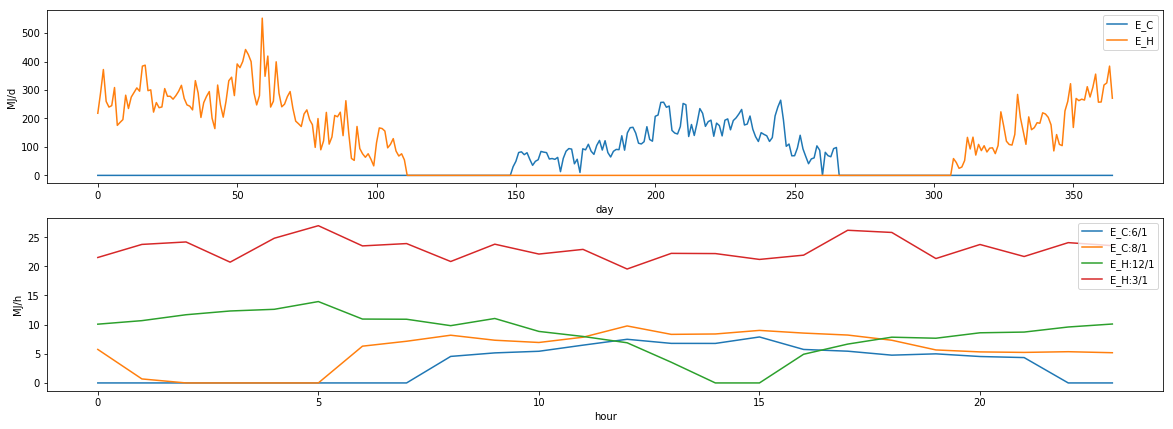

In [84]:
get_each_graph(_E_C_d_t_1, _E_H_d_t_1)

### 計算条件2

In [85]:
param_base = {"region": 1, "A_A": 120.08, "A_MR": 29.81, "A_OR": 51.34, "A_env": 307.51, "U_A": 0.87,"eta_A_H": 4.3, "eta_A_C": 2.8}

H_A = {'type': 'ダクト式セントラル空調機','duct_insulation': '全てもしくは一部が断熱区画外である','VAV': False,
       'general_ventilation': True,'EquipmentSpec': '入力しない'}

C_A = {'type': 'ダクト式セントラル空調機','duct_insulation': '全てもしくは一部が断熱区画外である','VAV': False,
       'general_ventilation': True,'EquipmentSpec': '入力しない'}

_E_C_d_t_2, _E_H_d_t_2 = calc_results(param_base, C_A, H_A)

一次エネルギー消費量 E_C:3151.6467125592953MJ/y、E_H:141367.326695553MJ/y


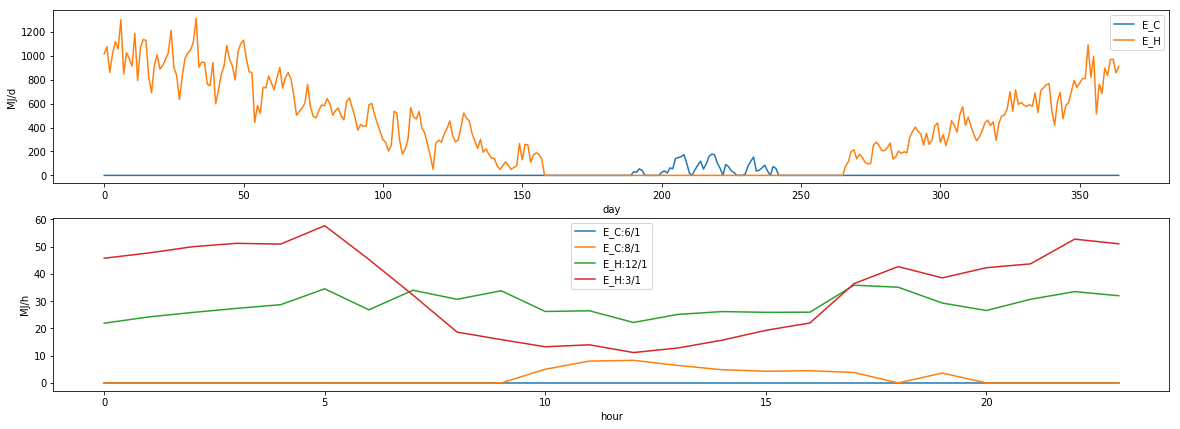

In [86]:
get_each_graph(_E_C_d_t_2, _E_H_d_t_2)

### 計算条件3

In [87]:
param_base = {"region": 6, "A_A": 90, "A_MR": 25, "A_OR": 40, "A_env": 250, "U_A": 0.87,"eta_A_H": 4.3, "eta_A_C": 2.8}

H_A = {'type': 'ダクト式セントラル空調機','duct_insulation': '全てもしくは一部が断熱区画外である','VAV': False,
       'general_ventilation': True,'EquipmentSpec': '入力しない'}

C_A = {'type': 'ダクト式セントラル空調機','duct_insulation': '全てもしくは一部が断熱区画外である','VAV': False,
       'general_ventilation': True,'EquipmentSpec': '入力しない'}

_E_C_d_t_3, _E_H_d_t_3 = calc_results(param_base, C_A, H_A)



一次エネルギー消費量 E_C:12064.848995914122MJ/y、E_H:32734.351845529964MJ/y


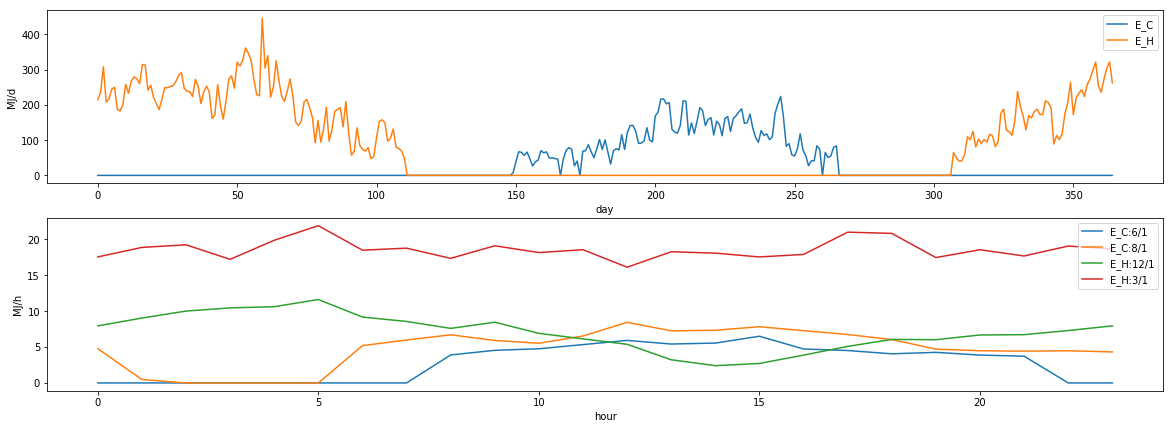

In [88]:
get_each_graph(_E_C_d_t_3, _E_H_d_t_3)

### 計算条件4

In [89]:
param_base = {"region": 6, "A_A": 120.08, "A_MR": 29.81, "A_OR": 51.34, "A_env": 307.51, "U_A": 0.6,"eta_A_H": 4.3, "eta_A_C": 2.8}

H_A = {'type': 'ダクト式セントラル空調機','duct_insulation': '全てもしくは一部が断熱区画外である','VAV': False,
       'general_ventilation': True,'EquipmentSpec': '入力しない'}

C_A = {'type': 'ダクト式セントラル空調機','duct_insulation': '全てもしくは一部が断熱区画外である','VAV': False,
       'general_ventilation': True,'EquipmentSpec': '入力しない'}

_E_C_d_t_4, _E_H_d_t_4 = calc_results(param_base, C_A, H_A)



一次エネルギー消費量 E_C:15776.744106489657MJ/y、E_H:28097.11553361559MJ/y


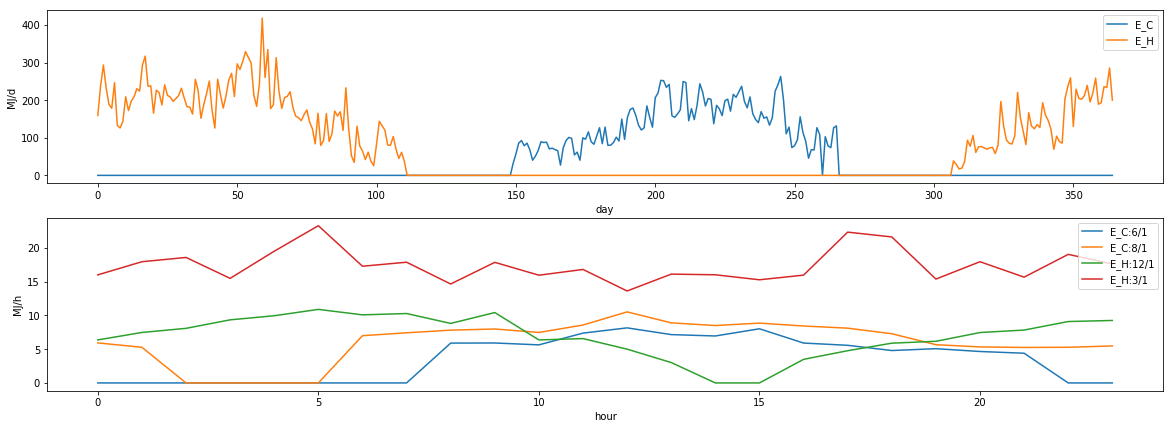

In [90]:
get_each_graph(_E_C_d_t_4, _E_H_d_t_4)

### 計算条件5

In [91]:
param_base = {"region": 6, "A_A": 120.08, "A_MR": 29.81, "A_OR": 51.34, "A_env": 307.51, "U_A": 0.87,"eta_A_H": 3.0, "eta_A_C": 2.8}

H_A = {'type': 'ダクト式セントラル空調機','duct_insulation': '全てもしくは一部が断熱区画外である','VAV': False,
       'general_ventilation': True,'EquipmentSpec': '入力しない'}

C_A = {'type': 'ダクト式セントラル空調機','duct_insulation': '全てもしくは一部が断熱区画外である','VAV': False,
       'general_ventilation': True,'EquipmentSpec': '入力しない'}

_E_C_d_t_5, _E_H_d_t_5 = calc_results(param_base, C_A, H_A)



一次エネルギー消費量 E_C:14746.052998129611MJ/y、E_H:42553.81444879265MJ/y


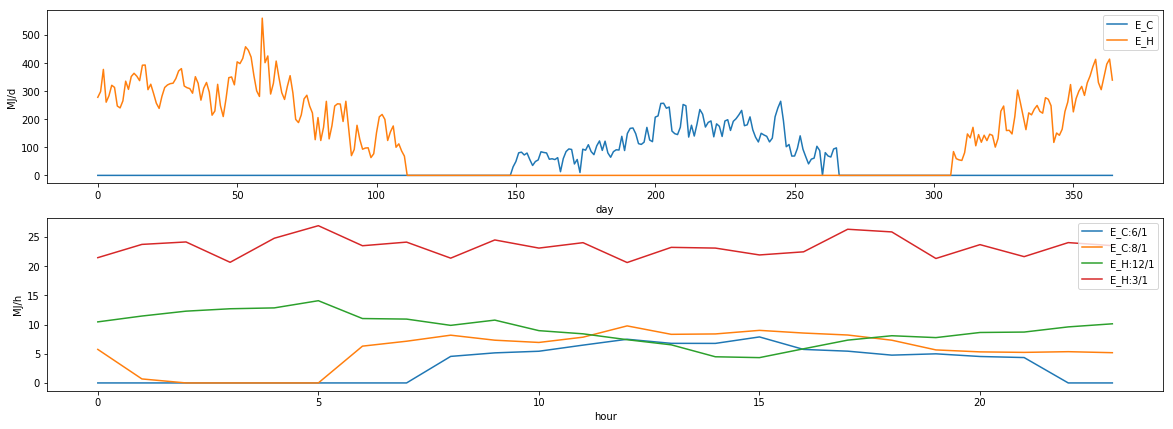

In [92]:
get_each_graph(_E_C_d_t_5, _E_H_d_t_5)

### 計算条件6

In [93]:
param_base = {"region": 6, "A_A": 120.08, "A_MR": 29.81, "A_OR": 51.34, "A_env": 307.51, "U_A": 0.87,"eta_A_H": 4.3, "eta_A_C": 2.0}

H_A = {'type': 'ダクト式セントラル空調機','duct_insulation': '全てもしくは一部が断熱区画外である','VAV': False,
       'general_ventilation': True,'EquipmentSpec': '入力しない'}

C_A = {'type': 'ダクト式セントラル空調機','duct_insulation': '全てもしくは一部が断熱区画外である','VAV': False,
       'general_ventilation': True,'EquipmentSpec': '入力しない'}

_E_C_d_t_6, _E_H_d_t_6 = calc_results(param_base, C_A, H_A)



一次エネルギー消費量 E_C:12603.125355747807MJ/y、E_H:36310.32799729332MJ/y


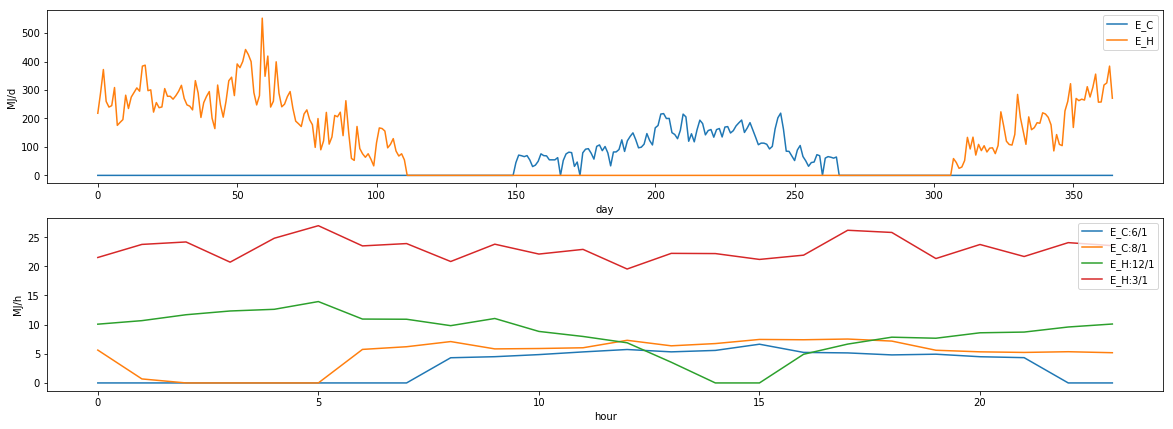

In [94]:
get_each_graph(_E_C_d_t_6, _E_H_d_t_6)

### 計算条件7

In [95]:
param_base = {"region": 6, "A_A": 120.08, "A_MR": 29.81, "A_OR": 51.34, "A_env": 307.51, "U_A": 0.87,"eta_A_H": 4.3, "eta_A_C": 2.8}

H_A = {'type': 'ダクト式セントラル空調機','duct_insulation': '全てもしくは一部が断熱区画外である','VAV': False,
       'general_ventilation': True,'EquipmentSpec': '定格能力試験の値を入力する', 'q_hs_rtd_H': 5500, 'P_hs_rtd_H': 1500,
       'V_fan_rtd_H': 2000, 'P_fan_rtd_H': 150}

C_A = {'type': 'ダクト式セントラル空調機','duct_insulation': '全てもしくは一部が断熱区画外である','VAV': False,
       'general_ventilation': True,'EquipmentSpec': '定格能力試験の値を入力する', 'q_hs_rtd_C': 5000, 'P_hs_rtd_C': 1500, 
       'V_fan_rtd_C': 2000, 'P_fan_rtd_C': 150}

_E_C_d_t_7, _E_H_d_t_7 = calc_results(param_base, C_A, H_A)



一次エネルギー消費量 E_C:13087.721204357189MJ/y、E_H:34608.12124230976MJ/y


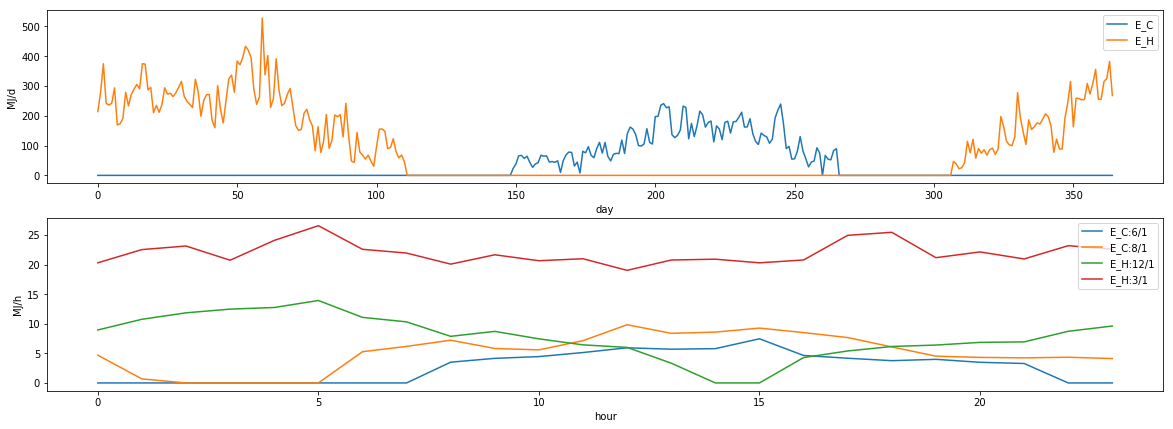

In [96]:
get_each_graph(_E_C_d_t_7, _E_H_d_t_7)

### 計算条件8

In [97]:
param_base = {"region": 6, "A_A": 120.08, "A_MR": 29.81, "A_OR": 51.34, "A_env": 307.51, "U_A": 0.87,"eta_A_H": 4.3, "eta_A_C": 2.8}

H_A = {'type': 'ダクト式セントラル空調機','duct_insulation': '全てもしくは一部が断熱区画外である','VAV': False,
       'general_ventilation': True,'EquipmentSpec': '定格能力試験と中間能力試験の値を入力する', 'q_hs_rtd_H': 5500, 'P_hs_rtd_H': 1500,
       'V_fan_rtd_H': 2000, 'P_fan_rtd_H': 150, 'q_hs_mid_H': 3200, 'P_hs_mid_H': 1000, 'V_fan_mid_H': 1000, 'P_fan_mid_H': 80,
       'V_hs_dsgn_H': 1500}

C_A = {'type': 'ダクト式セントラル空調機','duct_insulation': '全てもしくは一部が断熱区画外である','VAV': False,
       'general_ventilation': True,'EquipmentSpec': '定格能力試験と中間能力試験の値を入力する', 'q_hs_rtd_C': 5000, 'P_hs_rtd_C': 1500, 
       'V_fan_rtd_C': 2000, 'P_fan_rtd_C': 150, 'q_hs_mid_C': 3000, 'P_hs_mid_C': 1000, 'V_fan_mid_C': 1000, 'P_fan_mid_C': 80,
       'V_hs_dsgn_C': 1500}

_E_C_d_t_8, _E_H_d_t_8 = calc_results(param_base, C_A, H_A)



一次エネルギー消費量 E_C:13501.274781274133MJ/y、E_H:36253.68181018293MJ/y


### 比較

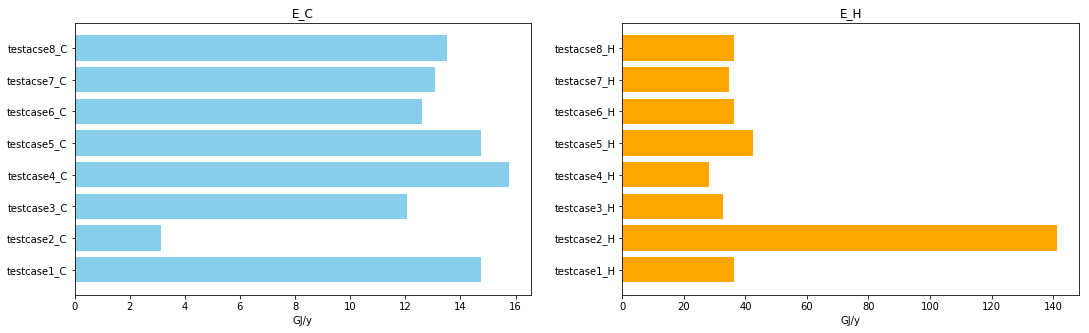

In [98]:
import matplotlib.pyplot as plt

dat_C = {"testcase1_C": np.sum(_E_C_d_t_1)/1000, "testcase2_C": np.sum(_E_C_d_t_2)/1000, "testcase3_C": np.sum(_E_C_d_t_3)/1000, 
         "testcase4_C": np.sum(_E_C_d_t_4)/1000, "testcase5_C": np.sum(_E_C_d_t_5)/1000, "testcase6_C": np.sum(_E_C_d_t_6)/1000,
         "testacse7_C": np.sum(_E_C_d_t_7)/1000, "testacse8_C": np.sum(_E_C_d_t_8)/1000}
dat_H = {"testcase1_H": np.sum(_E_H_d_t_1)/1000, "testcase2_H": np.sum(_E_H_d_t_2)/1000, "testcase3_H": np.sum(_E_H_d_t_3)/1000, 
         "testcase4_H": np.sum(_E_H_d_t_4)/1000, "testcase5_H": np.sum(_E_H_d_t_5)/1000, "testcase6_H": np.sum(_E_H_d_t_6)/1000,
         "testacse7_H": np.sum(_E_H_d_t_7)/1000, "testacse8_H": np.sum(_E_H_d_t_8)/1000}

x_C = list(dat_C.keys())
x_H = list(dat_H.keys())
y_C = list(dat_C.values())
y_H = list(dat_H.values())

fig = plt.figure(figsize=(18,5))
grh_C = fig.add_subplot(121)
grh_C.barh(x_C,y_C, color = "skyblue")
grh_C.set_title("E_C")
grh_C.set_xlabel("GJ/y")

grh_H = fig.add_subplot(122)
grh_H.barh(x_H,y_H, color = "orange")
grh_H.set_xlabel("GJ/y")
grh_H.set_title("E_H")

plt.show()